<a href="https://colab.research.google.com/github/SeiTAKANE/smt_airport_rct_data/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
#!git clone https://github.com/SeiTAKANE/smt_airport_rct_data

In [ ]:
#set package environment
import os
import pandas as pd
import numpy as np
import glob
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import ast
from math import floor, ceil

pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 80)

!pip install plotnine
!pip install patchworklib


from plotnine import *


import pkg_resources
import sys

def print_python_and_package_info():
    # Print Python version
    print(f"Python Version: {sys.version}")

    # Print installed packages and their versions
    print("\nInstalled Packages:")
    for dist in sorted(pkg_resources.working_set, key=lambda x: x.project_name.lower()):
        print(f"{dist.project_name} {dist.version}")

print_python_and_package_info()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 297.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: mizani
    Found existing installation: mizani 0.13.1
    Uninstalling mizani-0.13.1:
      Successfully uninstalled mizani-0.13.1
  Attempting uninstall: plotnine
    Found existing installation: plotnine 0.14.5
    Uninstalling plotnine-0.14.5:
      Successfully uninstalled plotnine-0.14.5


<ipython-input-2-1875a2992204>:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html


Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]

Installed Packages:
absl-py 1.4.0
accelerate 1.5.2
aiohappyeyeballs 2.6.1
aiohttp 3.11.14
aiosignal 1.3.2
alabaster 1.0.0
albucore 0.0.23
albumentations 2.0.5
ale-py 0.10.2
altair 5.5.0
annotated-types 0.7.0
anyio 4.9.0
argon2-cffi 23.1.0
argon2-cffi-bindings 21.2.0
array-record 0.7.1
arviz 0.21.0
astropy 7.0.1
astropy-iers-data 0.2025.3.17.0.34.53
astunparse 1.6.3
atpublic 5.1
attrs 25.3.0
audioread 3.0.1
autocommand 2.2.2
autograd 1.7.0
babel 2.17.0
backcall 0.2.0
backports.tarfile 1.2.0
beautifulsoup4 4.13.3
betterproto 2.0.0b6
bigframes 1.41.0
bigquery-magics 0.8.0
bleach 6.2.0
blinker 1.9.0
blis 1.2.0
blosc2 3.2.0
bokeh 3.6.3
Bottleneck 1.4.2
bqplot 0.12.44
branca 0.8.1
cachecontrol 0.14.2
cachetools 5.5.2
catalogue 2.0.10
certifi 2025.1.31
cffi 1.17.1
chardet 5.2.0
charset-normalizer 3.4.1
chex 0.1.89
clarabel 0.10.0
click 8.1.8
cloudpathlib 0.21.0
cloudpickle 3.1.1
cmake 3.31.6
cmdstanpy 1.2.5
colorcet 3.1.0
col

In [ ]:
#set directory path
data_dir = os.path.join(os.getcwd(), 'data')
#data_dir = '/content/drive/MyDrive/rec_sys_new/replication/smt_airport_rct_data/data'
recommendation_group_path = os.path.join(data_dir, "df_recommendation_group.csv")
control_group_path = os.path.join(data_dir, "df_control_group.csv")

#read data
#recommendation group
df_rec = pd.read_csv(recommendation_group_path, encoding='utf-8-sig')
#contorol group
df_ctr = pd.read_csv(control_group_path, encoding='utf-8-sig')

In [ ]:
#pre-processing
df_rec['Departure_Date'] = pd.to_datetime(df_rec['Departure_Date'])
df_ctr['Departure_Date'] = pd.to_datetime(df_ctr['Departure_Date'])

# Create unique Member_IDs for each dataframe
df_rec['Member_ID'] = range(1, len(df_rec) + 1)
df_ctr['Member_ID'] = range(len(df_rec) + 1, len(df_rec) + len(df_ctr) + 1)

# Mapping Group Number
group_mapping_rec = {1.0: 'Randomized', 2.0: 'BPR', 3.0: 'Wide & Deep'}
df_rec['Group_Name'] = df_rec['Group_Number'].map(group_mapping_rec)

group_mapping_ctr = {1.0: 'Randomized (Empty)', 2.0: 'BPR (Empty)', 3.0: 'Wide & Deep (Empty)'}
df_ctr['Group_Name'] = df_ctr['Group_Number'].map(group_mapping_ctr)



# Add 'is_coupon' column to df_rec and set value to 1
df_rec['is_coupon'] = 1

# Add 'is_coupon' column to df_ctr and set value to 0
df_ctr['is_coupon'] = 0

# Concatenate both DataFrames vertically
df_anl_cp = pd.concat([df_rec, df_ctr], ignore_index=True)
df_anl_cp_non_null = df_anl_cp[
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(0).all(axis=1)
]
df_anl_cp_null = df_anl_cp[
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(1).all(axis=1)
]



# Create dummy variables for 'Group_Name'
dummies = pd.get_dummies(df_anl_cp['Group_Name'])

# Create DataFrame for Randomized group
rd_groups = ['Randomized', 'Randomized (Empty)']
df_anl_cp_rd = df_anl_cp[df_anl_cp['Group_Name'].isin(rd_groups)]
df_anl_cp_rd_non_null = df_anl_cp[
    (df_anl_cp['Group_Name'].isin(rd_groups)) &
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(0).all(axis=1)
]
df_anl_cp_rd_null = df_anl_cp[
    (df_anl_cp['Group_Name'].isin(rd_groups)) &
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(1).all(axis=1)
]

# Create DataFrame for BPR group
bpr_groups = ['BPR', 'BPR (Empty)']
df_anl_cp_bpr = df_anl_cp[df_anl_cp['Group_Name'].isin(bpr_groups)]
df_anl_cp_bpr_non_null = df_anl_cp[
    (df_anl_cp['Group_Name'].isin(bpr_groups)) &
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(0).all(axis=1)
]
df_anl_cp_bpr_null = df_anl_cp[
    (df_anl_cp['Group_Name'].isin(bpr_groups)) &
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(1).all(axis=1)
]

# Create DataFrame for Wide & Deep group
wd_groups = ['Wide & Deep', 'Wide & Deep (Empty)']
df_anl_cp_wd = df_anl_cp[df_anl_cp['Group_Name'].isin(wd_groups)]
df_anl_cp_wd_non_null = df_anl_cp[
    (df_anl_cp['Group_Name'].isin(wd_groups)) &
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(0).all(axis=1)
]
df_anl_cp_wd_null = df_anl_cp[
    (df_anl_cp['Group_Name'].isin(wd_groups)) &
    df_anl_cp[['Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence']].eq(1).all(axis=1)
]

## Descriptive Statistics

In [ ]:
def descriptive_stats_table(df, group_order):
    """
    Function to calculate descriptive statistics for a given dataframe and group order.
    """
    # 列名の統一：'Sex' → 'Gender'
    df = df.rename(columns={'Sex': 'Gender'})

    results = []
    for group in group_order:
        group_data = df[df['Group_Name'] == group]
        n = len(group_data)

        stats = {
            'Group_Name': group,
            'N': n,
            'Gender': group_data['Gender'].value_counts(dropna=False).to_dict(),
            'Age': group_data['Age'].value_counts(dropna=False).to_dict(),
            'Region': group_data['Region'].value_counts(dropna=False).to_dict(),
            'Has Missing Gender (mean)': round(group_data['Has_NaN_Sex'].mean(), 2) if not pd.isna(group_data['Has_NaN_Sex'].mean()) else None,
            'Has Missing Gender (sd)': round(group_data['Has_NaN_Sex'].std(), 2) if not pd.isna(group_data['Has_NaN_Sex'].std()) else None,
            'Has Missing Age (mean)': round(group_data['Has_NaN_Age'].mean(), 2) if not pd.isna(group_data['Has_NaN_Age'].mean()) else None,
            'Has Missing Age (sd)': round(group_data['Has_NaN_Age'].std(), 2) if not pd.isna(group_data['Has_NaN_Age'].std()) else None,
            'Has Missing Region (mean)': round(group_data['Has_NaN_Residence'].mean(), 2) if not pd.isna(group_data['Has_NaN_Residence'].mean()) else None,
            'Has Missing Region (sd)': round(group_data['Has_NaN_Residence'].std(), 2) if not pd.isna(group_data['Has_NaN_Residence'].std()) else None,
            'Pre-order (Counts) (mean)': round(group_data['Pre-order_Count'].mean(), 2) if not pd.isna(group_data['Pre-order_Count'].mean()) else None,
            'Pre-order (Counts) (sd)': round(group_data['Pre-order_Count'].std(), 2) if not pd.isna(group_data['Pre-order_Count'].std()) else None,
            'Diff Departure Pre-order (Day) (mean)': round(group_data['Diff_Dep_Pre'].mean(), 2) if not pd.isna(group_data['Diff_Dep_Pre'].mean()) else None,
            'Diff Departure Pre-order (Day) (sd)': round(group_data['Diff_Dep_Pre'].std(), 2) if not pd.isna(group_data['Diff_Dep_Pre'].std()) else None,
            'Sales Revenue of Recommended Products (JPY) (mean)': round(group_data['sales'].mean(), 2) if not pd.isna(group_data['sales'].mean()) else None,
            'Sales Revenue of Recommended Products (JPY) (sd)': round(group_data['sales'].std(), 2) if not pd.isna(group_data['sales'].std()) else None,
            'Sales Quantity of Recommended Products (mean)': round(group_data['quantity'].mean(), 2) if not pd.isna(group_data['quantity'].mean()) else None,
            'Sales Quantity of Recommended Products (sd)': round(group_data['quantity'].std(), 2) if not pd.isna(group_data['quantity'].std()) else None
        }

        results.append(stats)

    results_df = pd.DataFrame(results)

    for col in ['Gender', 'Age', 'Region']:
        unique_values = sorted(df[col].unique(), key=lambda x: (pd.isna(x), x))
        results_df[col] = results_df[col].apply(lambda x: {k: x.get(k, 0) for k in unique_values})

    # Adjust column order
    results_df = results_df[[
        'Group_Name', 'Gender', 'Age', 'Region',
        'Has Missing Gender (mean)', 'Has Missing Gender (sd)',
        'Has Missing Age (mean)', 'Has Missing Age (sd)',
        'Has Missing Region (mean)', 'Has Missing Region (sd)',
        'Pre-order (Counts) (mean)', 'Pre-order (Counts) (sd)',
        'Diff Departure Pre-order (Day) (mean)', 'Diff Departure Pre-order (Day) (sd)',
        'Sales Revenue of Recommended Products (JPY) (mean)', 'Sales Revenue of Recommended Products (JPY) (sd)',
        'Sales Quantity of Recommended Products (mean)', 'Sales Quantity of Recommended Products (sd)',
        'N'
    ]]
    return results_df

def transpose_table(df):
    """
    Function to transpose a descriptive statistics table.
    """
    # Set 'Group_Name' as the index
    df = df.set_index('Group_Name')

    # Perform transposition
    transposed_df = df.T

    # Remove index name
    transposed_df.index.name = None
    return transposed_df

group_order_rec = ['Randomized', 'BPR', 'Wide & Deep']
group_order_ctr = ['Randomized (Empty)', 'BPR (Empty)', 'Wide & Deep (Empty)']

# Generate descriptive statistics tables
rec_table = descriptive_stats_table(df_rec, group_order_rec)
ctr_table = descriptive_stats_table(df_ctr, group_order_ctr)

# Transpose tables
transposed_rec_table = transpose_table(rec_table)
transposed_ctr_table = transpose_table(ctr_table)

print("Recommendation Groups")
print(transposed_rec_table.to_markdown(numalign="left", stralign="left"))
print("Control Groups")
print(transposed_ctr_table.to_markdown(numalign="left", stralign="left"))

Recommendation Groups
|                                                    | Randomized                                                                                              | BPR                                                                                                    | Wide & Deep                                                                                            |
|:---------------------------------------------------|:--------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------|
| Gender                                             | {'Female': 891, 'Male': 411, nan: 2845}                                                                 | {'Female': 745, 'Male': 375, nan: 2241}                                    

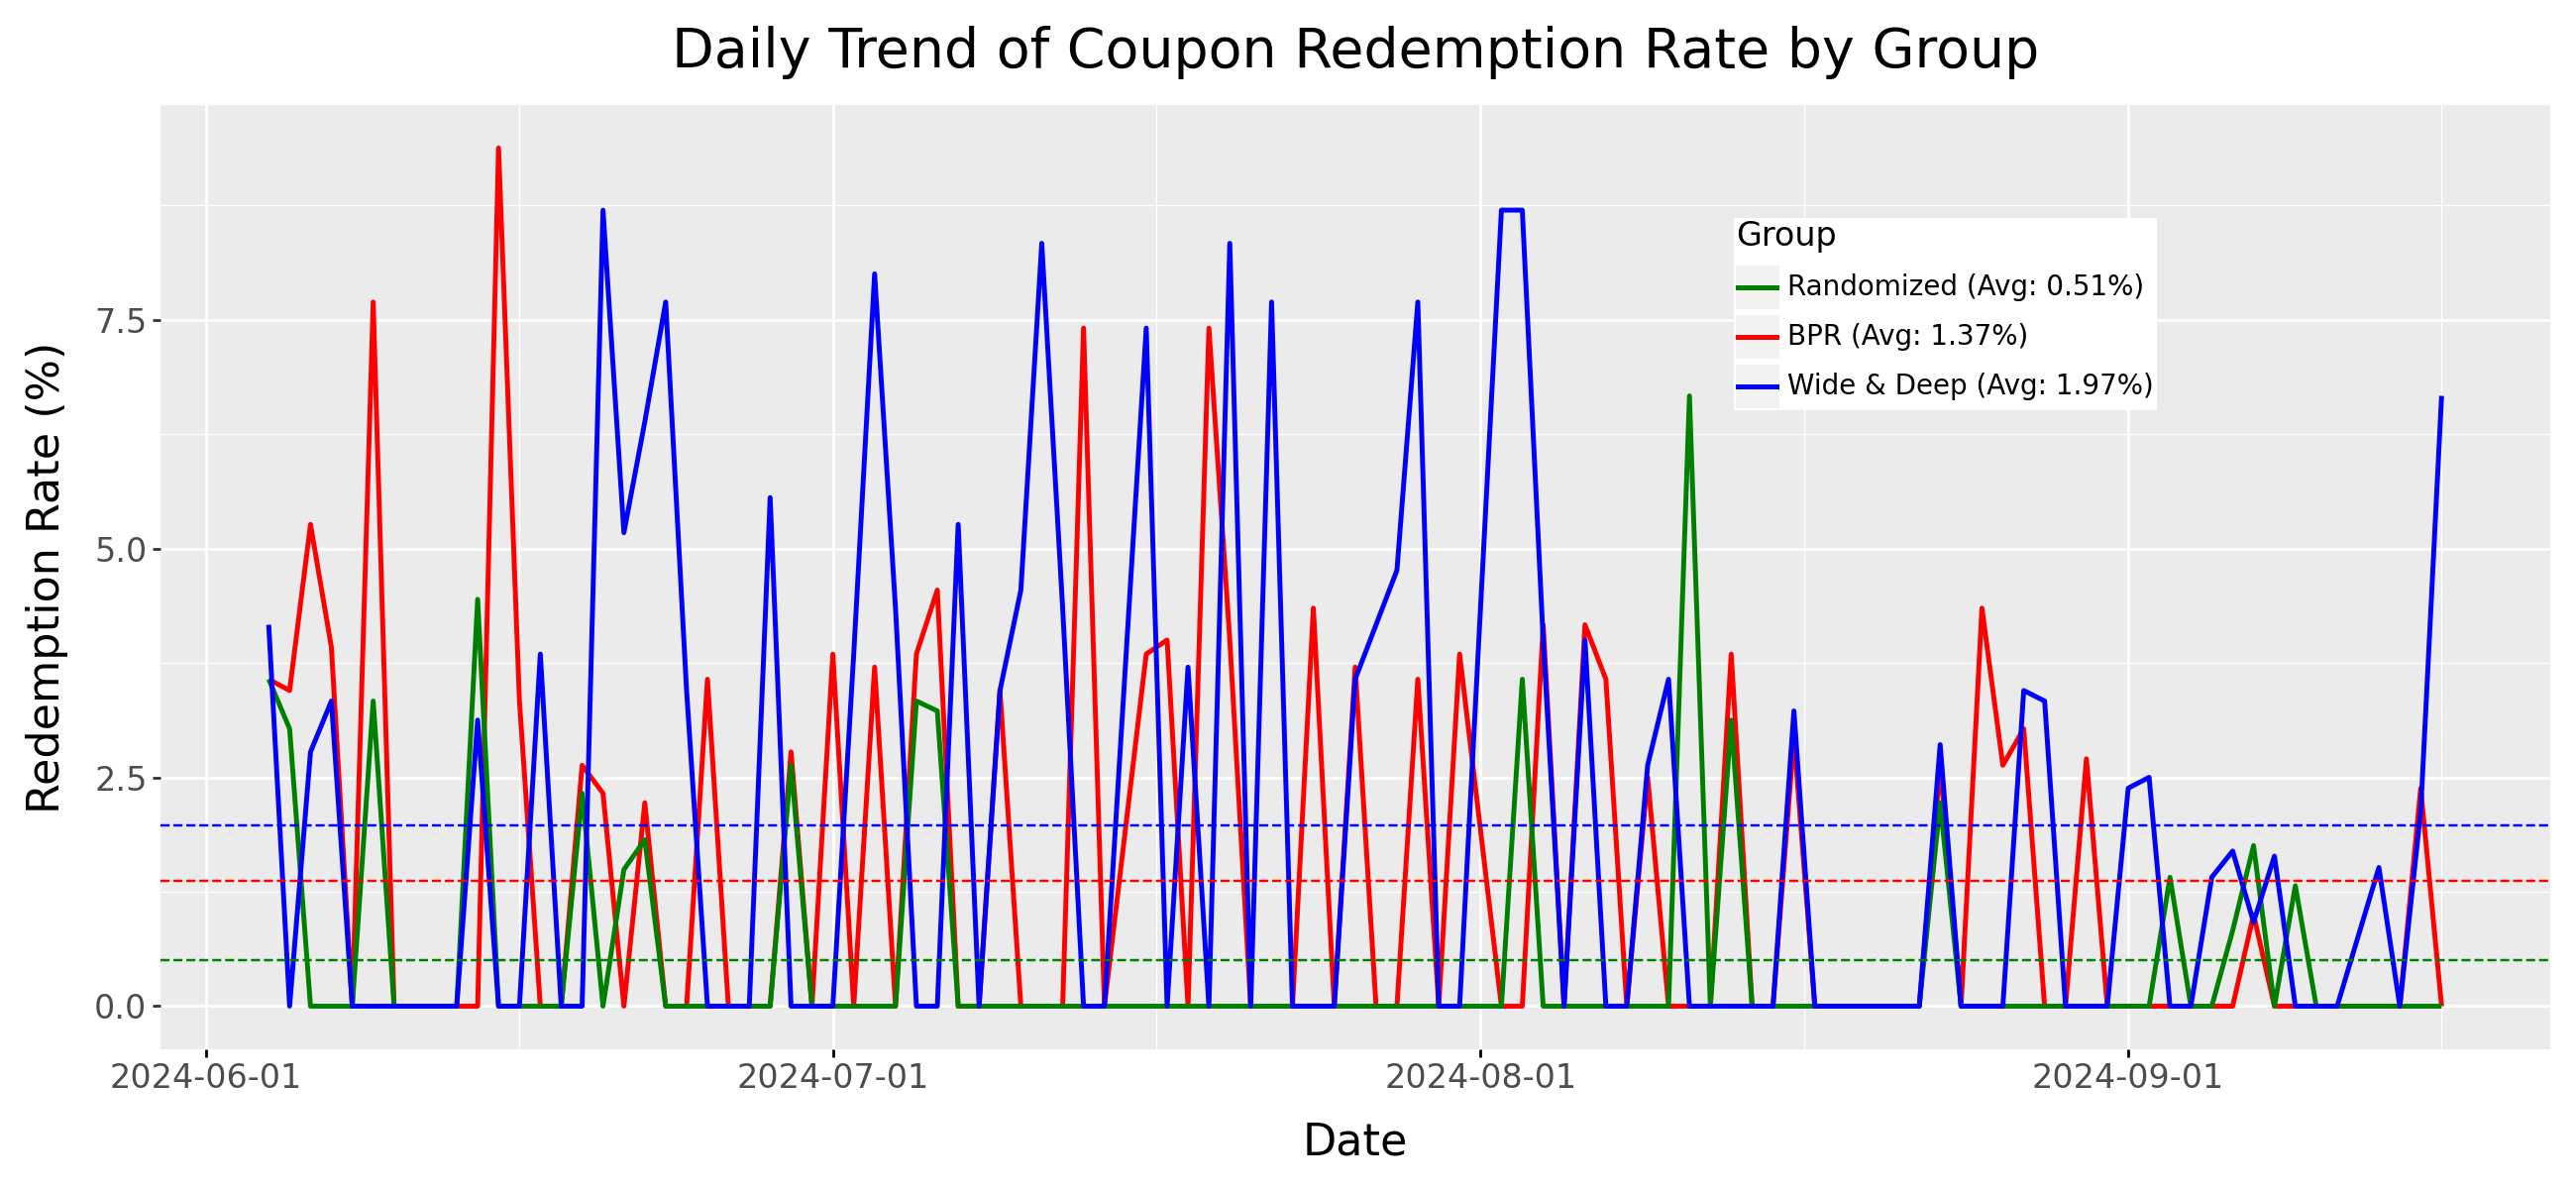

In [ ]:
#The Coupon Redemption Rate by Group
# Group and count the total records for each Departure_Date and Group_Name
target_counts = df_rec.groupby(['Departure_Date', 'Group_Name']).size().reset_index(name='count')
target_counts['target'] = target_counts['count']

# Filter engaged records and count unique engaged Member_IDs
grouped_engaged = df_rec[df_rec['engaged'] == 1]
grouped_engaged = (
    grouped_engaged
    .groupby(['Departure_Date', 'Group_Name'])['Member_ID']
    .nunique()
    .reset_index(name='engaged_count')
)

# Merge target counts and engaged counts
merged_data = pd.merge(target_counts, grouped_engaged, on=['Departure_Date', 'Group_Name'], how='left')
merged_data['engaged_count'] = merged_data['engaged_count'].fillna(0)  # Fill NaN with 0
merged_data['target'] = merged_data['target'].replace(0, 1e-10)  # Avoid division by zero

# Calculate engagement rate for each group
merged_data['engagement_rate'] = (merged_data['engaged_count'] / merged_data['target']) * 100

# Aggregate totals and calculate overall engagement rate
total_data = merged_data.groupby(['Departure_Date', 'Group_Name']).agg({
    'engaged_count': 'sum',
    'target': 'sum'
}).reset_index()
total_data['total_engagement_rate'] = (total_data['engaged_count'] / total_data['target']) * 100

# Calculate the average engagement rate for each group
group_average_rates = df_rec.groupby('Group_Name')['engaged'].mean() * 100

# Define the order of groups and corresponding colors
group_order = ['Randomized', 'BPR', 'Wide & Deep']
colors = ['green', 'red', 'blue']

# Create a dataframe for the legend
legend_df = pd.DataFrame({
    'Group_Name': group_order,
    'average_rate': [group_average_rates[group] for group in group_order]
})

# Format labels for each group including the average engagement rate
legend_df['label'] = legend_df.apply(lambda row: f"{row['Group_Name']} (Avg: {row['average_rate']:.2f}%)", axis=1)

# Plot the engagement rate trend by group
p = (
    ggplot(total_data, aes(x='Departure_Date', y='total_engagement_rate', color='Group_Name'))
    + geom_line(size=1)
    + scale_color_manual(values=colors, breaks=group_order, labels=legend_df['label'].tolist())
    + scale_x_datetime(date_breaks="1 month")
    + labs(
        title='Daily Trend of Coupon Redemption Rate by Group',
        x='Date',
        y='Redemption Rate (%)',
        color='Group'  # Set legend title
    )
    # Add horizontal lines indicating the average engagement rate for each group
    + geom_hline(legend_df, aes(yintercept='average_rate', color='Group_Name'), linetype='--')
    + theme(
        figure_size=(13, 6.0),
        axis_title=element_text(size=16),
        axis_text=element_text(size=12),
        title=element_text(size=20),
        legend_position=(0.8, 0.85),
        legend_title=element_text(size=12),  # Set legend title size
        legend_text=element_text(size=10)
    )
)
p

In [ ]:
# Calculate the rank of Departure_Date
df_rec['rank'] = df_rec['Departure_Date'].rank(method='first')

# Get the median rank
median_rank = df_rec['rank'].median()

# Get the threshold Departure_Date (the minimum date where rank is greater than or equal to the median)
median_departure_date = df_rec.loc[df_rec['rank'] >= median_rank, 'Departure_Date'].min()

# Split the data into first and second halves
df_rec['half'] = np.where(df_rec['rank'] < median_rank, 'first_half', 'second_half')

# Calculate the average engagement rate for each group in the first and second halves
half_engagement_rates = (
    df_rec.groupby(['Group_Name', 'half'])['engaged']
    .mean()
    .unstack()
    .mul(100)
    .reset_index()
    .rename(columns={'first_half': 'first_half_rate', 'second_half': 'second_half_rate'})
)

# Add the threshold Departure_Date to the DataFrame
half_engagement_rates['median_departure_date'] = median_departure_date


# Ensure Group_Name is a categorical variable with the specified order
half_engagement_rates['Group_Name'] = pd.Categorical(
    half_engagement_rates['Group_Name'],
    categories=group_order,
    ordered=True
)

# Sort the DataFrame by the specified Group_Name order
half_engagement_rates = half_engagement_rates.sort_values('Group_Name')
half_engagement_rates

half,Group_Name,first_half_rate,second_half_rate,median_departure_date
1,Randomized,0.571429,0.439668,2024-08-04
0,BPR,1.998824,0.722892,2024-08-04
2,Wide & Deep,2.886978,1.103368,2024-08-04


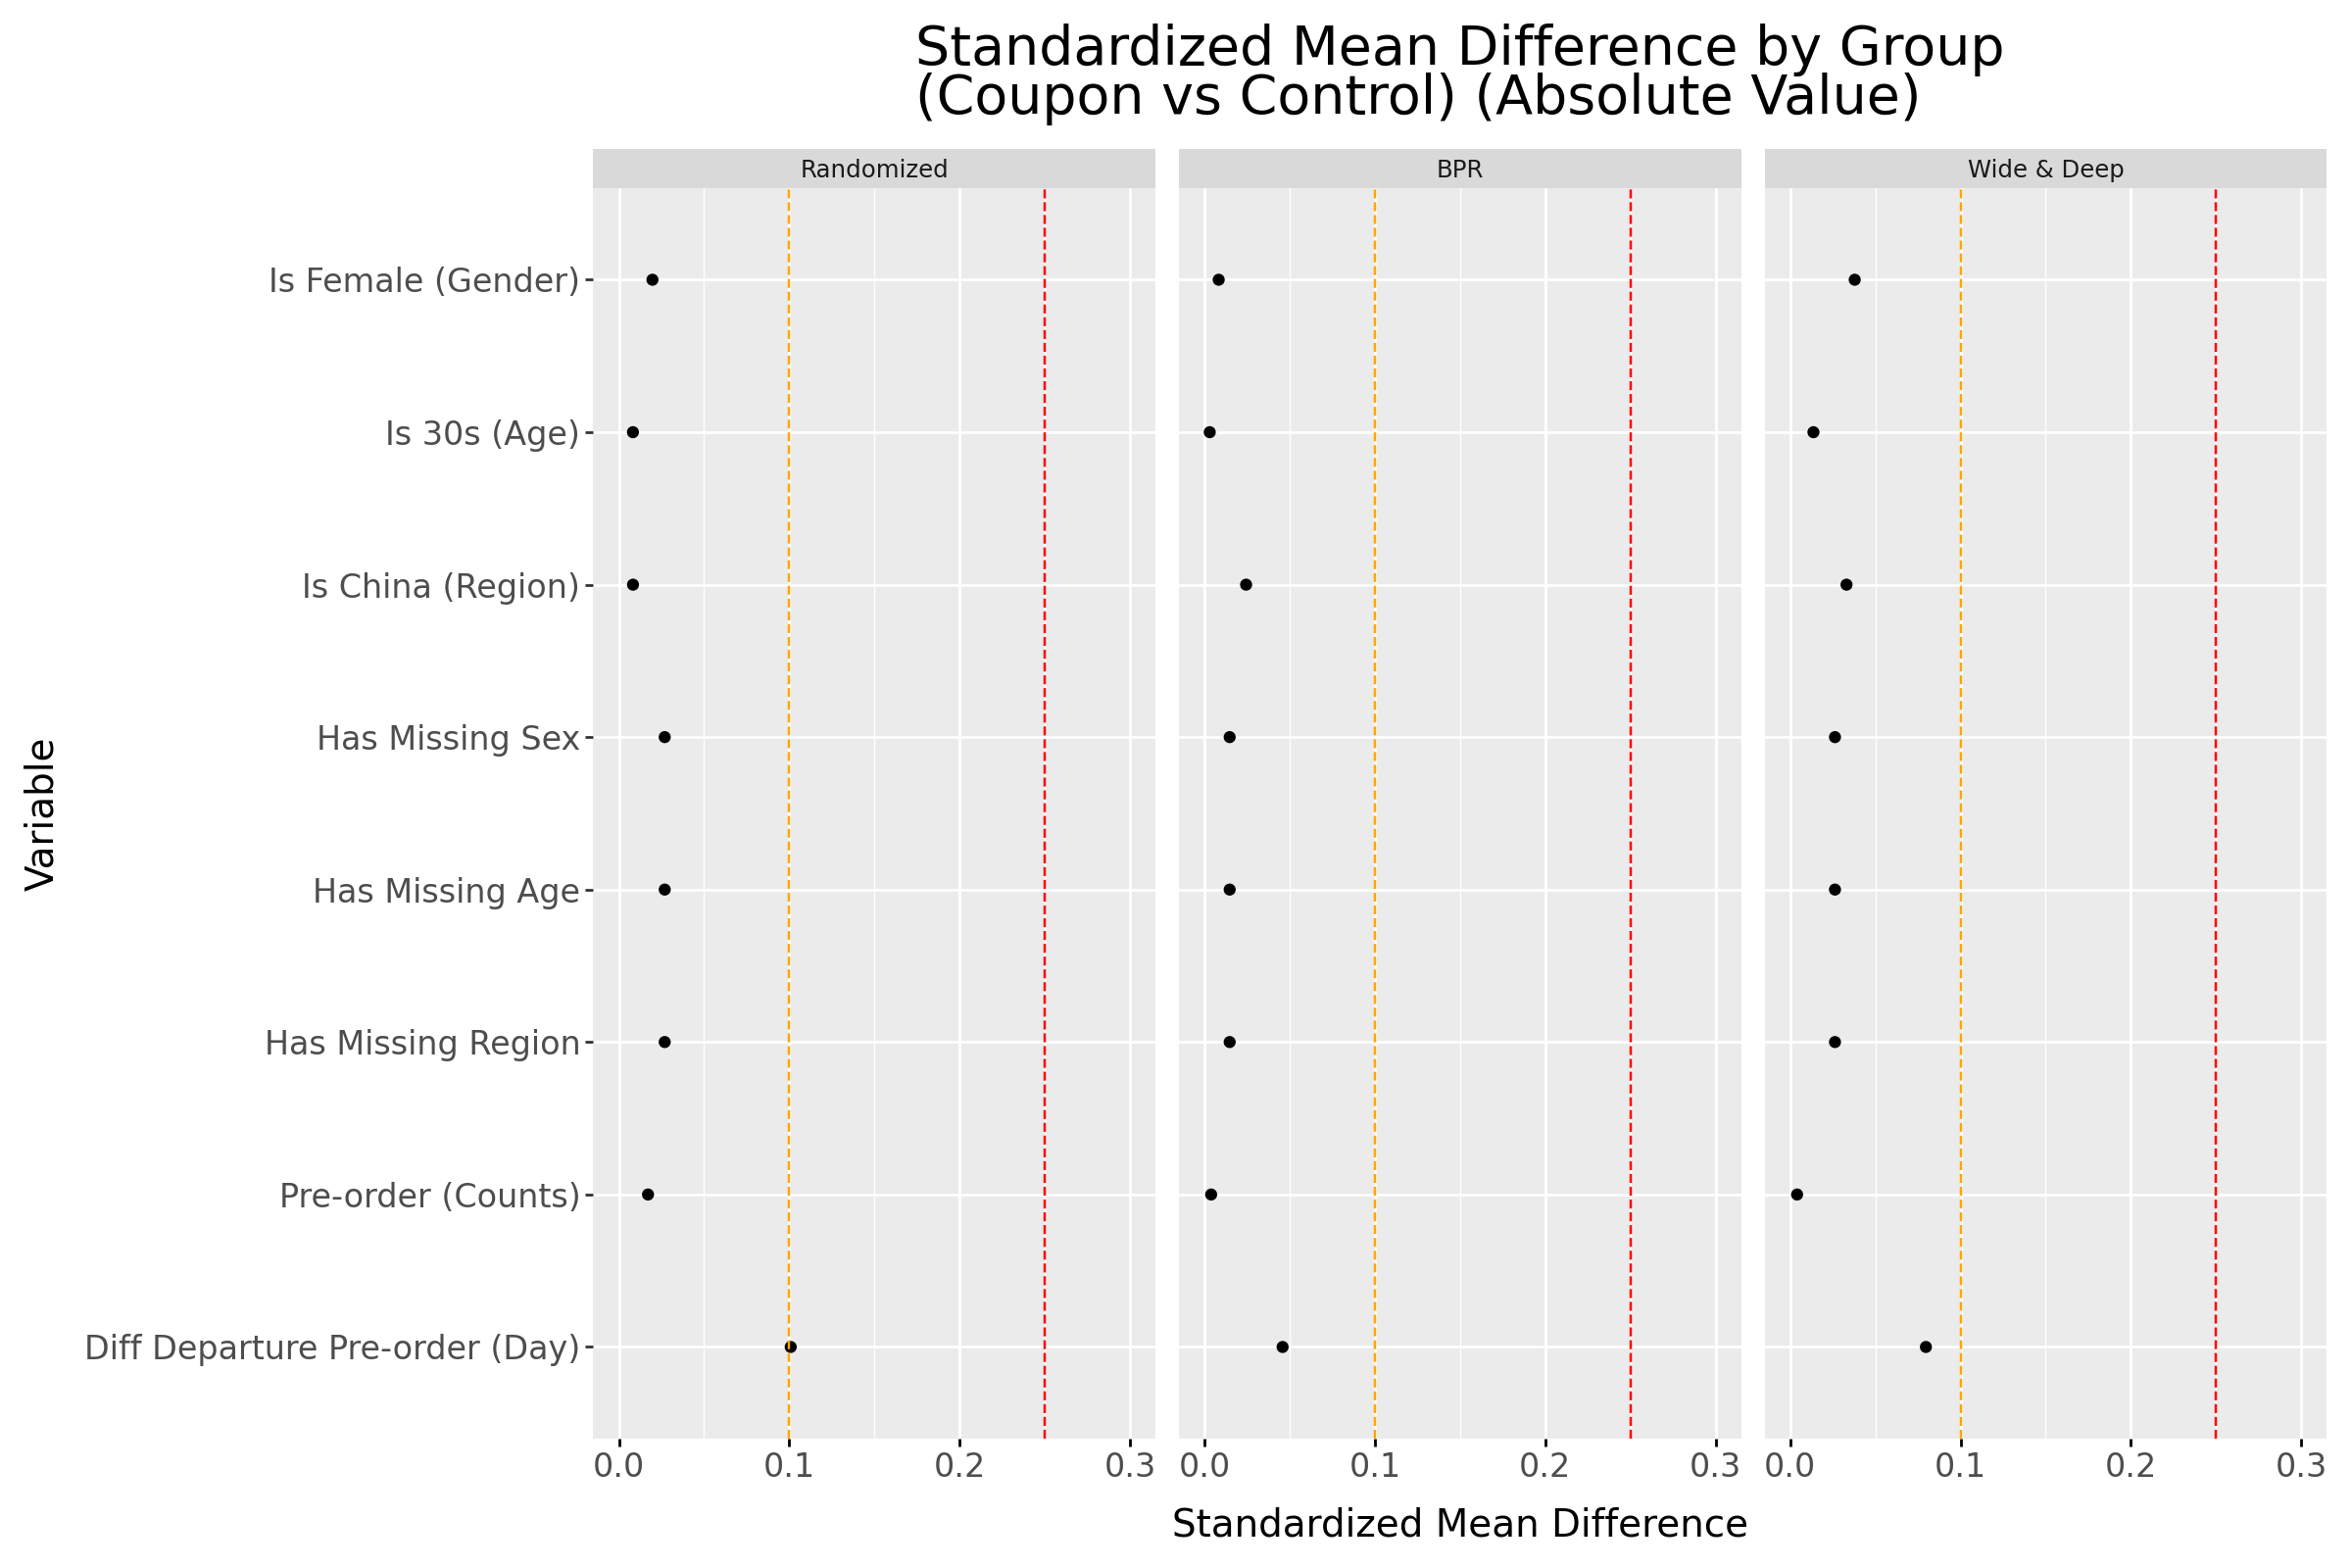

In [ ]:
# Function to calculate standardized mean difference
def calculate_standardized_difference(group1, group2, columns, is_binary=True):  # Added is_binary argument
    results = {}
    for col in columns:
        mean1, mean2 = group1[col].mean(), group2[col].mean()

        # If is_binary is True (binary variables)
        if is_binary:
            var1 = mean1 * (1 - mean1)
            var2 = mean2 * (1 - mean2)
        # If is_binary is False (continuous variables)
        else:
            var1, var2 = group1[col].var(), group2[col].var()

        pooled_std = np.sqrt((var1 + var2) / 2)
        std_diff = (mean1 - mean2) / pooled_std if pooled_std != 0 else 0
        results[col] = abs(std_diff)  # Use absolute value
    return results

columns_to_check = ['Is_Female', 'Is_30s', 'Is_China', 'Has_NaN_Sex', 'Has_NaN_Age', 'Has_NaN_Residence', 'Pre-order_Count', 'Diff_Dep_Pre']

# Mapping of groups and names
group_names = {1.0: 'Randomized', 2.0: 'BPR', 3.0: 'Wide & Deep'}

# Mapping for variable labels
label_mapping = {
    'Is_Female': 'Is Female (Gender)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Has_NaN_Sex': 'Has Missing Sex',
    'Has_NaN_Age': 'Has Missing Age',
    'Has_NaN_Residence': 'Has Missing Region',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
}

# Calculate standardized mean differences for each group
std_diffs = {}
for group in [1.0, 2.0, 3.0]:
    ctr_group = df_ctr[df_ctr['Group_Number'] == group]
    ex_group = df_rec[df_rec['Group_Number'] == group]

    binary_cols = [col for col in columns_to_check if col not in ['Pre-order_Count', 'Diff_Dep_Pre']]
    preorder_cols = ['Pre-order_Count', 'Diff_Dep_Pre']

    std_diffs[group_names[group]] = {
        **calculate_standardized_difference(ctr_group, ex_group, binary_cols, is_binary=True),
        **calculate_standardized_difference(ctr_group, ex_group, preorder_cols, is_binary=False)
    }

# Prepare data for visualization using plotnine
plot_data = []
for group_name, std_diff in std_diffs.items():
    for col, diff in std_diff.items():
        plot_data.append({'Group': group_name, 'Variable': col, 'Standardized Difference': diff})
plot_df = pd.DataFrame(plot_data)

# Convert Group column to categorical type with defined order
plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=list(group_names.values()))

# Convert Variable column to categorical type to control display order
plot_df['Variable'] = pd.Categorical(plot_df['Variable'], categories=columns_to_check)

# Apply label mapping
plot_df['Variable_Label'] = plot_df['Variable'].map(label_mapping)

# Plot
p = (
    ggplot(plot_df, aes(x='Standardized Difference', y='Variable_Label'))
    + geom_point()
    + facet_wrap('~ Group')
    + geom_vline(xintercept=0.1, color='orange', linetype='--')
    + geom_vline(xintercept=0.25, color='red', linetype='--')
    + labs(title='Standardized Mean Difference by Group\n(Coupon vs Control) (Absolute Value)',
           x='Standardized Mean Difference', y='Variable')
    + theme(figure_size=(12, 8), axis_text=element_text(size=12), axis_title=element_text(size=14),
            plot_title=element_text(size=20))
    + coord_cartesian(xlim=(0, 0.3))
    + scale_y_discrete(limits=plot_df['Variable_Label'].unique()[::-1])  # Control display order of y-axis
)

p

In [ ]:
print(std_diffs)

{'Randomized': {'Is_Female': np.float64(0.019701580421675188), 'Is_30s': np.float64(0.008250977363620472), 'Is_China': np.float64(0.008291442872978677), 'Has_NaN_Sex': np.float64(0.02690794083948784), 'Has_NaN_Age': np.float64(0.02690794083948784), 'Has_NaN_Residence': np.float64(0.02690794083948784), 'Pre-order_Count': np.float64(0.01710180933911791), 'Diff_Dep_Pre': np.float64(0.10087301913641623)}, 'BPR': {'Is_Female': np.float64(0.00832245950075862), 'Is_30s': np.float64(0.003061011055346304), 'Is_China': np.float64(0.024403229684320012), 'Has_NaN_Sex': np.float64(0.0147532615889181), 'Has_NaN_Age': np.float64(0.0147532615889181), 'Has_NaN_Residence': np.float64(0.0147532615889181), 'Pre-order_Count': np.float64(0.003885527552174953), 'Diff_Dep_Pre': np.float64(0.04582751431782711)}, 'Wide & Deep': {'Is_Female': np.float64(0.03788985686640748), 'Is_30s': np.float64(0.013653776507537269), 'Is_China': np.float64(0.03306877022232774), 'Has_NaN_Sex': np.float64(0.026294066116803717), '

## The Effects of Coupon

### sales revenue

In [ ]:
# Define explanatory and dependent variables (Naive Model)
X = df_anl_cp['is_coupon']
y = df_anl_cp['sales']

# Add constant term (intercept)
X = sm.add_constant(X)

# Create and train the naive model
model = sm.OLS(y, X)
results_sales_nv = model.fit()

# Define explanatory and dependent variables (Full Model)
X = df_anl_cp[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y = df_anl_cp['sales']

# Add constant term (intercept)
X = sm.add_constant(X)

# Create and train the full model
model = sm.OLS(y, X)
results_sales_total = model.fit()

# Define explanatory and dependent variables for Randomized group
X_rd = df_anl_cp_rd[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_rd = df_anl_cp_rd['sales']

# Convert sales column to numeric and handle missing values
y_rd = pd.to_numeric(y_rd, errors='coerce')
y_rd.dropna(inplace=True)
X_rd = X_rd.loc[y_rd.index]

# Add constant term (intercept)
X_rd = sm.add_constant(X_rd)

# Create and train the model
model_rd = sm.OLS(y_rd, X_rd)
results_sales_rd = model_rd.fit()

# Define explanatory and dependent variables for BPR group
X_bpr = df_anl_cp_bpr[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_bpr = df_anl_cp_bpr['sales']

# Convert sales column to numeric and handle missing values
y_bpr = pd.to_numeric(y_bpr, errors='coerce')
y_bpr.dropna(inplace=True)
X_bpr = X_bpr.loc[y_bpr.index]

# Add constant term (intercept)
X_bpr = sm.add_constant(X_bpr)

# Create and train the model
model_bpr = sm.OLS(y_bpr, X_bpr)
results_sales_bpr = model_bpr.fit()

# Define explanatory and dependent variables for Wide & Deep group
X_wd = df_anl_cp_wd[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_wd = df_anl_cp_wd['sales']

# Convert sales column to numeric and handle missing values
y_wd = pd.to_numeric(y_wd, errors='coerce')
y_wd.dropna(inplace=True)
X_wd = X_wd.loc[y_wd.index]

# Add constant term (intercept)
X_wd = sm.add_constant(X_wd)

# Create and train the model
model_wd = sm.OLS(y_wd, X_wd)
results_sales_wd = model_wd.fit()

# Store results in a list
all_results = [
    ("Total (Naive)", results_sales_nv),
    ("Total", results_sales_total),
    ("Randomized", results_sales_rd),
    ("BPR", results_sales_bpr),
    ("Wide & Deep", results_sales_wd),
]

# List to store DataFrames of results
results_dfs = []

for name, results in all_results:
    if results:
        # Extract necessary information from the summary
        coef = results.params
        conf_int = results.conf_int()
        observations = results.nobs

        # Combine coefficient and confidence intervals into a string
        coef_with_ci = []
        for param_name in coef.index:
            coef_value = coef[param_name]
            ci_lower, ci_upper = conf_int.loc[param_name]
            coef_with_ci.append(f"{coef_value:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

        # Create DataFrame
        df = pd.DataFrame({name: coef_with_ci}, index=coef.index)
        df.loc['Observations', name] = int(observations)

        results_dfs.append(df)
    else:
        print(f"{name} Regression failed.")

# Combine DataFrames
final_df = pd.concat(results_dfs, axis=1, sort=False).fillna('')

# Adjust index order
new_index = ['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre', 'const', 'Observations']
final_df_sales = final_df.reindex(new_index)

# Convert values to '〇' or '×' except for 'const', 'is_coupon', and 'Observations'
for col in final_df_sales.columns:
    for index in final_df_sales.index:
        if index not in ['is_coupon', 'Observations', 'const']:
            if isinstance(final_df_sales.loc[index, col], str) and final_df_sales.loc[index, col] != '':
                final_df_sales.loc[index, col] = '〇'
            else:
                final_df_sales.loc[index, col] = '×'

# Mapping for index labels
index_mapping_cp = {
    'is_coupon': 'Coupon',
    'Is_Female': 'Is Female (Gender)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
    'const': 'Constant',
    'Observations': 'N'
}

# Rename index labels
final_df_sales = final_df_sales.rename(index=index_mapping_cp)

# Output as Markdown format
reg_table_sales_cp = final_df_sales.to_markdown(numalign='left', stralign='left')
print(reg_table_sales_cp)

|                                | Total (Naive)                | Total                        | Randomized                   | BPR                        | Wide & Deep                  |
|:-------------------------------|:-----------------------------|:-----------------------------|:-----------------------------|:---------------------------|:-----------------------------|
| Coupon                         | -167.957 [-277.221, -58.693] | -169.580 [-278.859, -60.301] | -175.445 [-306.981, -43.909] | 39.440 [-121.334, 200.213] | -351.975 [-618.091, -85.860] |
| Is Female (Gender)             | ×                            | 〇                           | 〇                           | 〇                         | 〇                           |
| Is 30s (Age)                   | ×                            | 〇                           | 〇                           | 〇                         | 〇                           |
| Is China (Region)              | ×                            | 〇 

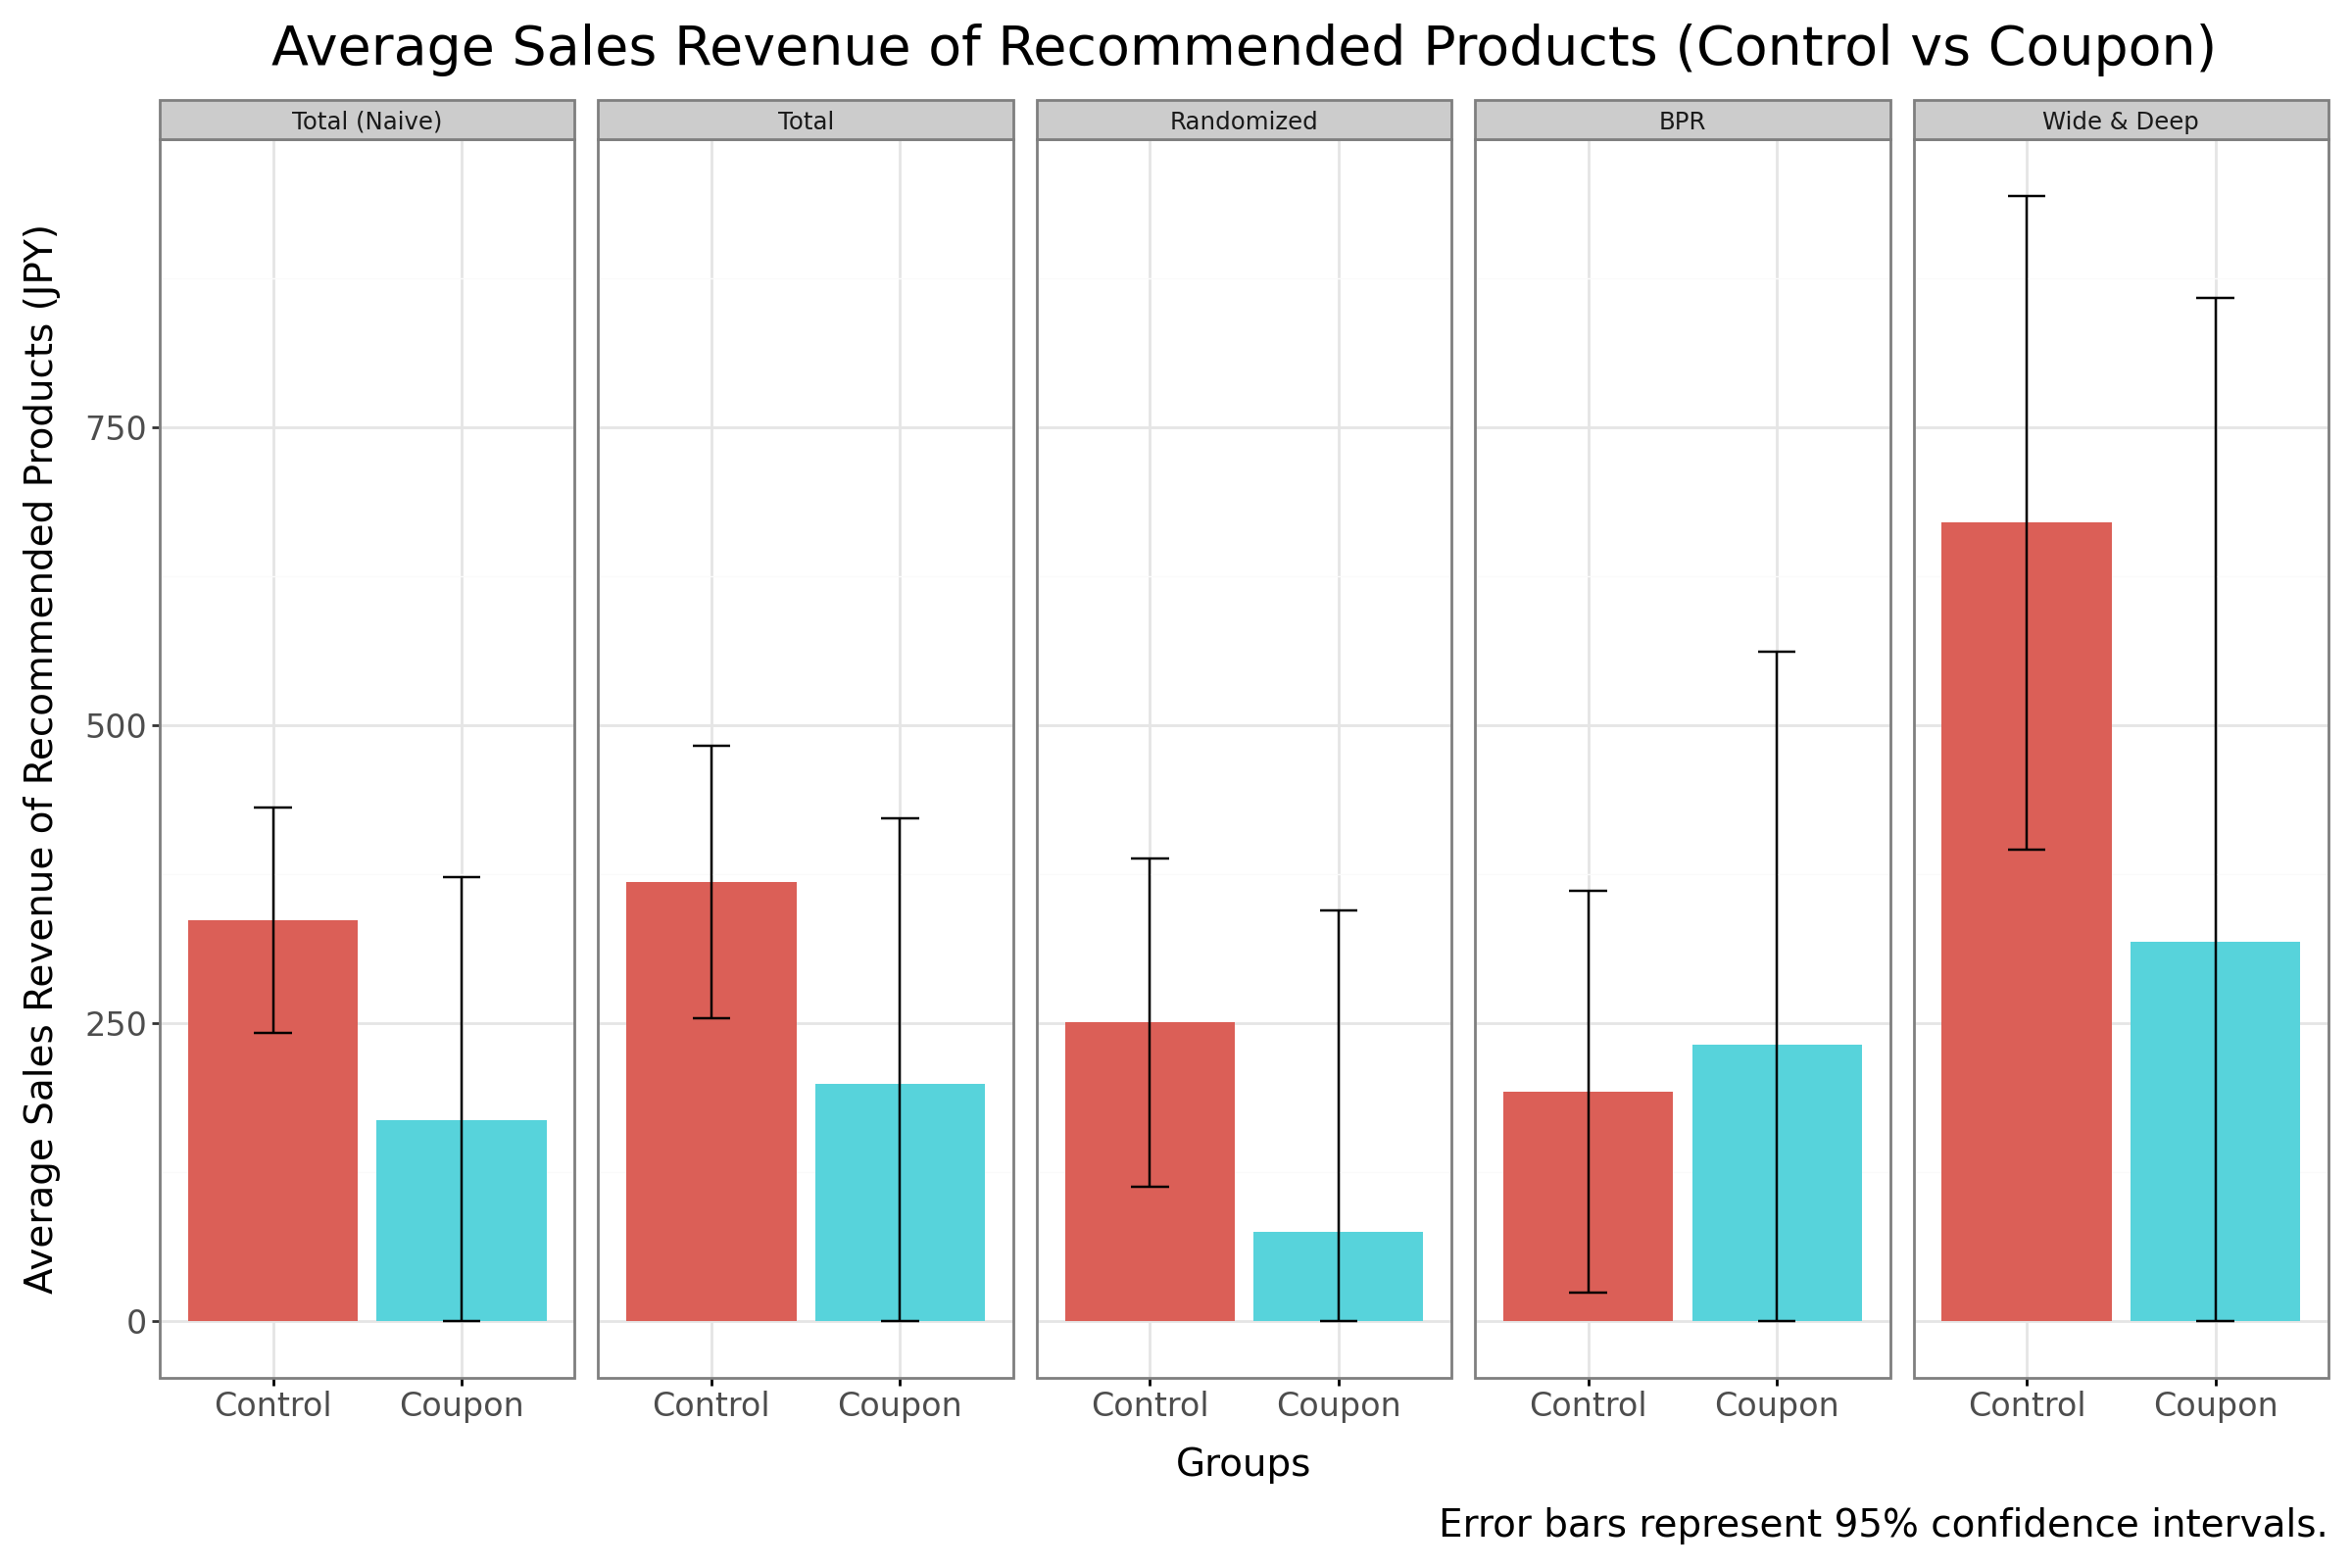

In [ ]:
def create_plot_df(results, model_name):
    """
    Function to create a DataFrame for plotting from regression results.
    """
    if results is None:
        return None

    coef = results.params
    conf_int = results.conf_int()

    data = []
    intercept, ci_lower_const, ci_upper_const = None, None, None

    if 'const' in coef.index:
        intercept = coef['const']
        ci_lower_const, ci_upper_const = conf_int.loc['const']
        ci_lower_const = max(0, ci_lower_const)  # Prevent negative values
        data.append({'Variable': 'Control', 'Estimate': intercept, 'CI_Lower': ci_lower_const, 'CI_Upper': ci_upper_const, 'Model': model_name})

    if 'is_coupon' in coef.index and intercept is not None:
        coef_value = coef['is_coupon']
        ci_lower_coupon, ci_upper_coupon = conf_int.loc['is_coupon']

        # Calculate confidence intervals for Coupon using Control's confidence intervals
        adjusted_ci_lower = max(0, ci_lower_const + ci_lower_coupon)  # Control upper limit + Coupon lower limit
        adjusted_ci_upper = ci_upper_const + ci_upper_coupon  # Control lower limit + Coupon upper limit

        data.append({'Variable': 'Coupon', 'Estimate': coef_value + intercept, 'CI_Lower': adjusted_ci_lower, 'CI_Upper': adjusted_ci_upper, 'Model': model_name})

    return pd.DataFrame(data)

# Create DataFrame for plotting
plot_data = pd.concat([
    create_plot_df(results_sales_nv, "Total (Naive)"),
    create_plot_df(results_sales_total, "Total"),
    create_plot_df(results_sales_rd, "Randomized"),
    create_plot_df(results_sales_bpr, "BPR"),
    create_plot_df(results_sales_wd, "Wide & Deep"),
], ignore_index=True)

# Remove rows with None values from plot data
plot_data = plot_data.dropna()

# Define order of models
model_order = ["Total (Naive)", "Total", "Randomized", "BPR", "Wide & Deep"]

# Convert 'Model' column to categorical type with specified order
plot_data['Model'] = pd.Categorical(plot_data['Model'], categories=model_order, ordered=True)

# Create plot
p = (
    ggplot(plot_data, aes(x='Variable', y='Estimate', fill='Variable'))
    + geom_bar(stat='identity', position=position_dodge(width=0.5))
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, position=position_dodge(width=0.5))
    + facet_grid('.~Model')
    + theme_bw()
    + theme(
        figure_size=(12, 8),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        plot_title=element_text(size=20),
        plot_caption=element_text(size=14, hjust=1, vjust=0)  # Adjust caption to bottom right
    )
    + labs(
        title="Average Sales Revenue of Recommended Products (Control vs Coupon)",
        x="Groups",
        y="Average Sales Revenue of Recommended Products (JPY)",
        caption="Error bars represent 95% confidence intervals."  # Add caption
    )
    + guides(fill=False)  # Remove legend
)

p

In [ ]:
#post-preorde sales revenue
print(df_anl_cp['Sales_in_real'].mean())
print(df_anl_cp_rd['Sales_in_real'].mean())
print(df_anl_cp_bpr['Sales_in_real'].mean())
print(df_anl_cp_wd['Sales_in_real'].mean())

30266.470863755338
30251.856594110115
30024.3173480663
30526.22359699514


### sales qunatity

In [ ]:
# Define explanatory and dependent variables (Naive Model)
X = df_anl_cp[['is_coupon']]
y = df_anl_cp['quantity']

# Convert quantity column to numeric and handle missing values
y = pd.to_numeric(y, errors='coerce')
y.dropna(inplace=True)
X = X.loc[y.index]

# Add constant term (intercept)
X = sm.add_constant(X)

# Create and train the naive model
model = sm.OLS(y, X)
results_quantity_nv = model.fit()

# Define explanatory and dependent variables (Full Model)
X = df_anl_cp[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y = df_anl_cp['quantity']

# Convert quantity column to numeric and handle missing values
y = pd.to_numeric(y, errors='coerce')
y.dropna(inplace=True)
X = X.loc[y.index]

# Add constant term (intercept)
X = sm.add_constant(X)

# Create and train the full model
model = sm.OLS(y, X)
results_quantity_total = model.fit()

# Define explanatory and dependent variables for Randomized group
X_rd = df_anl_cp_rd[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_rd = df_anl_cp_rd['quantity']

# Convert quantity column to numeric and handle missing values
y_rd = pd.to_numeric(y_rd, errors='coerce')
y_rd.dropna(inplace=True)
X_rd = X_rd.loc[y_rd.index]

# Add constant term (intercept)
X_rd = sm.add_constant(X_rd)

# Create and train the model
model_rd = sm.OLS(y_rd, X_rd)
results_quantity_rd = model_rd.fit()

# Define explanatory and dependent variables for Wide & Deep group
X_wd = df_anl_cp_wd[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_wd = df_anl_cp_wd['quantity']

# Convert quantity column to numeric and handle missing values
y_wd = pd.to_numeric(y_wd, errors='coerce')
y_wd.dropna(inplace=True)
X_wd = X_wd.loc[y_wd.index]

# Add constant term (intercept)
X_wd = sm.add_constant(X_wd)

# Create and train the model
model_wd = sm.OLS(y_wd, X_wd)
results_quantity_wd = model_wd.fit()

# Define explanatory and dependent variables for BPR group
X_bpr = df_anl_cp_bpr[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_bpr = df_anl_cp_bpr['quantity']

# Convert quantity column to numeric and handle missing values
y_bpr = pd.to_numeric(y_bpr, errors='coerce')
y_bpr.dropna(inplace=True)
X_bpr = X_bpr.loc[y_bpr.index]

# Add constant term (intercept)
X_bpr = sm.add_constant(X_bpr)

# Create and train the model
model_bpr = sm.OLS(y_bpr, X_bpr)
results_quantity_bpr = model_bpr.fit()

# Store results in a list
all_results_quantity = [
    ("Total (Naive)", results_quantity_nv),
    ("Total", results_quantity_total),
    ("Randomized", results_quantity_rd),
    ("BPR", results_quantity_bpr),
    ("Wide & Deep", results_quantity_wd),
]

# List to store DataFrames of results
results_dfs_quantity = []

for name, results in all_results_quantity:
    if results:
        # Extract necessary information from the summary
        coef = results.params
        conf_int = results.conf_int()
        observations = results.nobs

        # Combine coefficient and confidence intervals into a string
        coef_with_ci = []
        for param_name in coef.index:
            coef_value = coef[param_name]
            ci_lower, ci_upper = conf_int.loc[param_name]
            coef_with_ci.append(f"{coef_value:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

        # Create DataFrame
        df = pd.DataFrame({name: coef_with_ci}, index=coef.index)
        df.loc['Observations', name] = int(observations)

        results_dfs_quantity.append(df)
    else:
        print(f"{name} Regression failed.")

# Combine DataFrames
final_df_quantity = pd.concat(results_dfs_quantity, axis=1, sort=False).fillna('')

# Adjust index order
new_index = ['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre', 'const', 'Observations']
final_df_quantity = final_df_quantity.reindex(new_index)

# Convert values to '〇' or '×' except for 'const', 'is_coupon', and 'Observations'
for col in final_df_quantity.columns:
    for index in final_df_quantity.index:
        if index not in ['is_coupon', 'Observations', 'const']:
            if isinstance(final_df_quantity.loc[index, col], str) and final_df_quantity.loc[index, col] != '':
                final_df_quantity.loc[index, col] = '〇'
            else:
                final_df_quantity.loc[index, col] = '×'

# Mapping for index labels
index_mapping_cp = {
    'is_coupon': 'Coupon',
    'Is_Female': 'Is Female (Gender)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
    'const': 'Constant',
    'Observations': 'N'
}

# Rename index labels
final_df_quantity = final_df_quantity.rename(index=index_mapping_cp)

# Output as Markdown format
reg_table_quantity_cp = final_df_quantity.to_markdown(numalign='left', stralign='left')
print(reg_table_quantity_cp)

|                                | Total (Naive)           | Total                   | Randomized              | BPR                    | Wide & Deep             |
|:-------------------------------|:------------------------|:------------------------|:------------------------|:-----------------------|:------------------------|
| Coupon                         | -0.042 [-0.067, -0.018] | -0.043 [-0.067, -0.018] | -0.040 [-0.068, -0.012] | -0.004 [-0.036, 0.028] | -0.080 [-0.143, -0.018] |
| Is Female (Gender)             | ×                       | 〇                      | 〇                      | 〇                     | 〇                      |
| Is 30s (Age)                   | ×                       | 〇                      | 〇                      | 〇                     | 〇                      |
| Is China (Region)              | ×                       | 〇                      | 〇                      | 〇                     | 〇                      |
| Pre-order (Counts)        

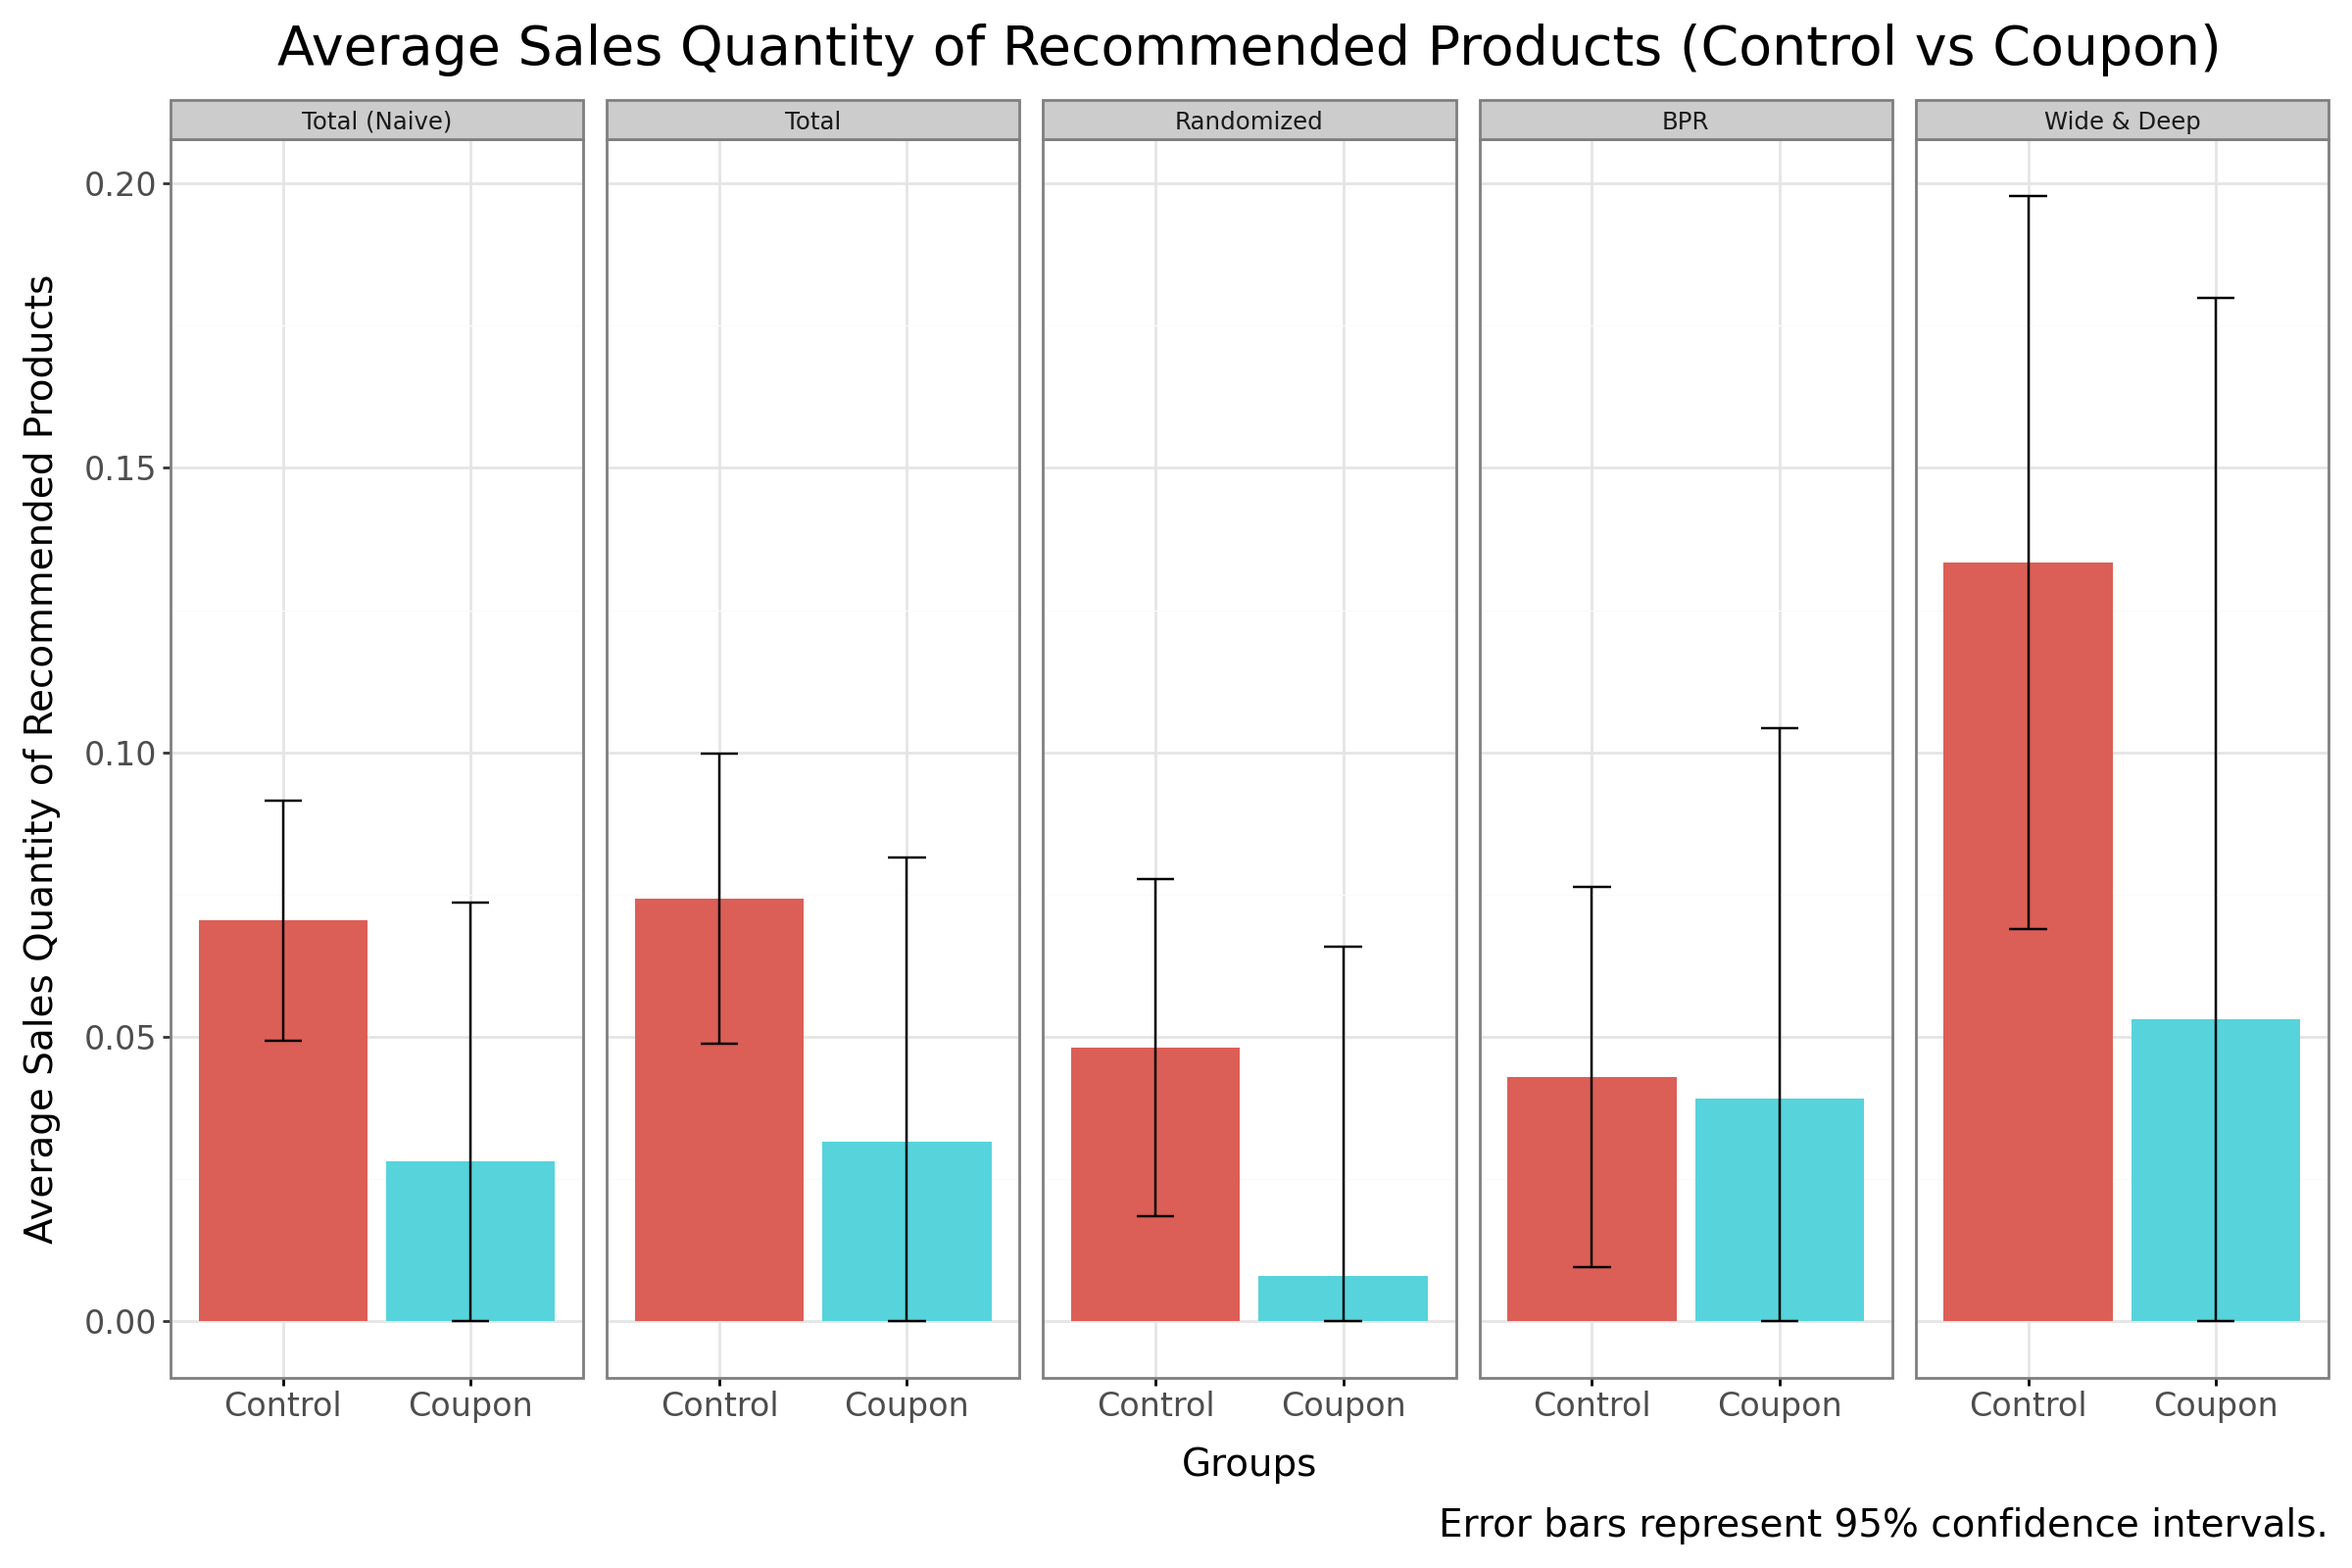

In [ ]:
def create_plot_df_quantity(results, model_name):
    """
    Function to create a DataFrame for plotting from regression results (Quantity model).
    """
    if results is None:
        return None

    coef = results.params
    conf_int = results.conf_int()

    data = []
    intercept, ci_lower_const, ci_upper_const = None, None, None

    if 'const' in coef.index:
        intercept = coef['const']
        ci_lower_const, ci_upper_const = conf_int.loc['const']
        ci_lower_const = max(0, ci_lower_const)  # Prevent negative values
        data.append({'Variable': 'Control', 'Estimate': intercept, 'CI_Lower': ci_lower_const, 'CI_Upper': ci_upper_const, 'Model': model_name})

    if 'is_coupon' in coef.index and intercept is not None:
        coef_value = coef['is_coupon']
        ci_lower_coupon, ci_upper_coupon = conf_int.loc['is_coupon']

        # Calculate confidence intervals for Coupon using Control's confidence intervals
        adjusted_ci_lower = max(0, ci_lower_const + ci_lower_coupon)
        adjusted_ci_upper = ci_upper_const + ci_upper_coupon

        data.append({'Variable': 'Coupon', 'Estimate': coef_value + intercept, 'CI_Lower': adjusted_ci_lower, 'CI_Upper': adjusted_ci_upper, 'Model': model_name})

    return pd.DataFrame(data)

# Create DataFrame for plotting (Quantity model)
plot_data_quantity = pd.concat([
    create_plot_df_quantity(results_quantity_nv, "Total (Naive)"),
    create_plot_df_quantity(results_quantity_total, "Total"),
    create_plot_df_quantity(results_quantity_rd, "Randomized"),
    create_plot_df_quantity(results_quantity_bpr, "BPR"),
    create_plot_df_quantity(results_quantity_wd, "Wide & Deep"),
], ignore_index=True)

# Remove rows with None values from plot data
plot_data_quantity = plot_data_quantity.dropna()

# Define order of models
model_order = ["Total (Naive)", "Total", "Randomized", "BPR", "Wide & Deep"]

# Convert 'Model' column to categorical type with specified order
plot_data_quantity['Model'] = pd.Categorical(plot_data_quantity['Model'], categories=model_order, ordered=True)

# Create plot (Quantity model)
p = (
    ggplot(plot_data_quantity, aes(x='Variable', y='Estimate', fill='Variable'))
    + geom_bar(stat='identity', position=position_dodge(width=0.5))
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, position=position_dodge(width=0.5))
    + facet_grid('.~Model')
    + theme_bw()
    + theme(
        figure_size=(12, 8),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        plot_title=element_text(size=20),
        plot_caption=element_text(size=14, hjust=1, vjust=0)  # Adjust caption to bottom right
    )
    + labs(
        title="Average Sales Quantity of Recommended Products (Control vs Coupon)",
        x="Groups",
        y="Average Sales Quantity of Recommended Products",
        caption="Error bars represent 95% confidence intervals."  # Add caption
    )
    + guides(fill=False)  # Remove legend
)

p

In [ ]:
#post-pre-order sales quantity
print(df_anl_cp['Quantity_in_real'].mean())
print(df_anl_cp_rd['Quantity_in_real'].mean())
print(df_anl_cp_bpr['Quantity_in_real'].mean())
print(df_anl_cp_wd['Quantity_in_real'].mean())

7.922234467557515
7.940003658313517
7.830055248618785
7.992929739284136


## The Effects of Algorithms

### sales revenue

In [ ]:
# Extract coupon effect data
coupon_data = final_df_sales.loc['Coupon']
models = final_df_sales.columns
coupon_effect = coupon_data.str.extract(r'([-+]?\d*\.\d+|\d+)\s*\[([-+]?\d*\.\d+|\d+),\s*([-+]?\d*\.\d+|\d+)\]')
coupon_effect.columns = ['Estimate', 'CI_Lower', 'CI_Upper']
coupon_effect = coupon_effect.astype(float)
coupon_effect['Model'] = models

# Set Randomized as the baseline
baseline = coupon_effect[coupon_effect['Model'] == 'Randomized']

# Data for graph comparison
comparison_data = coupon_effect[coupon_effect['Model'].isin(['BPR', 'Wide & Deep'])]

# Baseline confidence interval
baseline_estimate = baseline['Estimate'].values[0]
baseline_ci_lower = baseline['CI_Lower'].values[0]
baseline_ci_upper = baseline['CI_Upper'].values[0]

# Create comparison table
comparison_table = comparison_data[['Model', 'Estimate', 'CI_Lower', 'CI_Upper']].copy()

# Compute Difference (vs Randomized)
comparison_table['Difference (vs Randomized)'] = comparison_table['Estimate'] - baseline_estimate

# Compute confidence intervals for the Difference
comparison_table['Difference CI Lower'] = comparison_table['CI_Lower'] - baseline_ci_upper
comparison_table['Difference CI Upper'] = comparison_table['CI_Upper'] - baseline_ci_lower

# Convert confidence intervals into formatted strings
comparison_table['Difference (vs Randomized)'] = comparison_table.apply(
    lambda row: f"{row['Difference (vs Randomized)']:.3f} [{row['Difference CI Lower']:.3f}, {row['Difference CI Upper']:.3f}]",
    axis=1
)

# Add confidence intervals to Average Treatment Effect
comparison_table['Average Treatment Effect'] = comparison_table.apply(
    lambda row: f"{row['Estimate']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]",
    axis=1
)

# Remove unnecessary columns
comparison_table = comparison_table[['Average Treatment Effect', 'Difference (vs Randomized)']]

# Convert to markdown format for display
comparison_table_md = comparison_table.to_markdown(index=True, numalign='left', stralign='left')

print(comparison_table_md)

|             | Average Treatment Effect     | Difference (vs Randomized)   |
|:------------|:-----------------------------|:-----------------------------|
| BPR         | 39.440 [-121.334, 200.213]   | 214.885 [-77.425, 507.194]   |
| Wide & Deep | -351.975 [-618.091, -85.860] | -176.530 [-574.182, 221.121] |


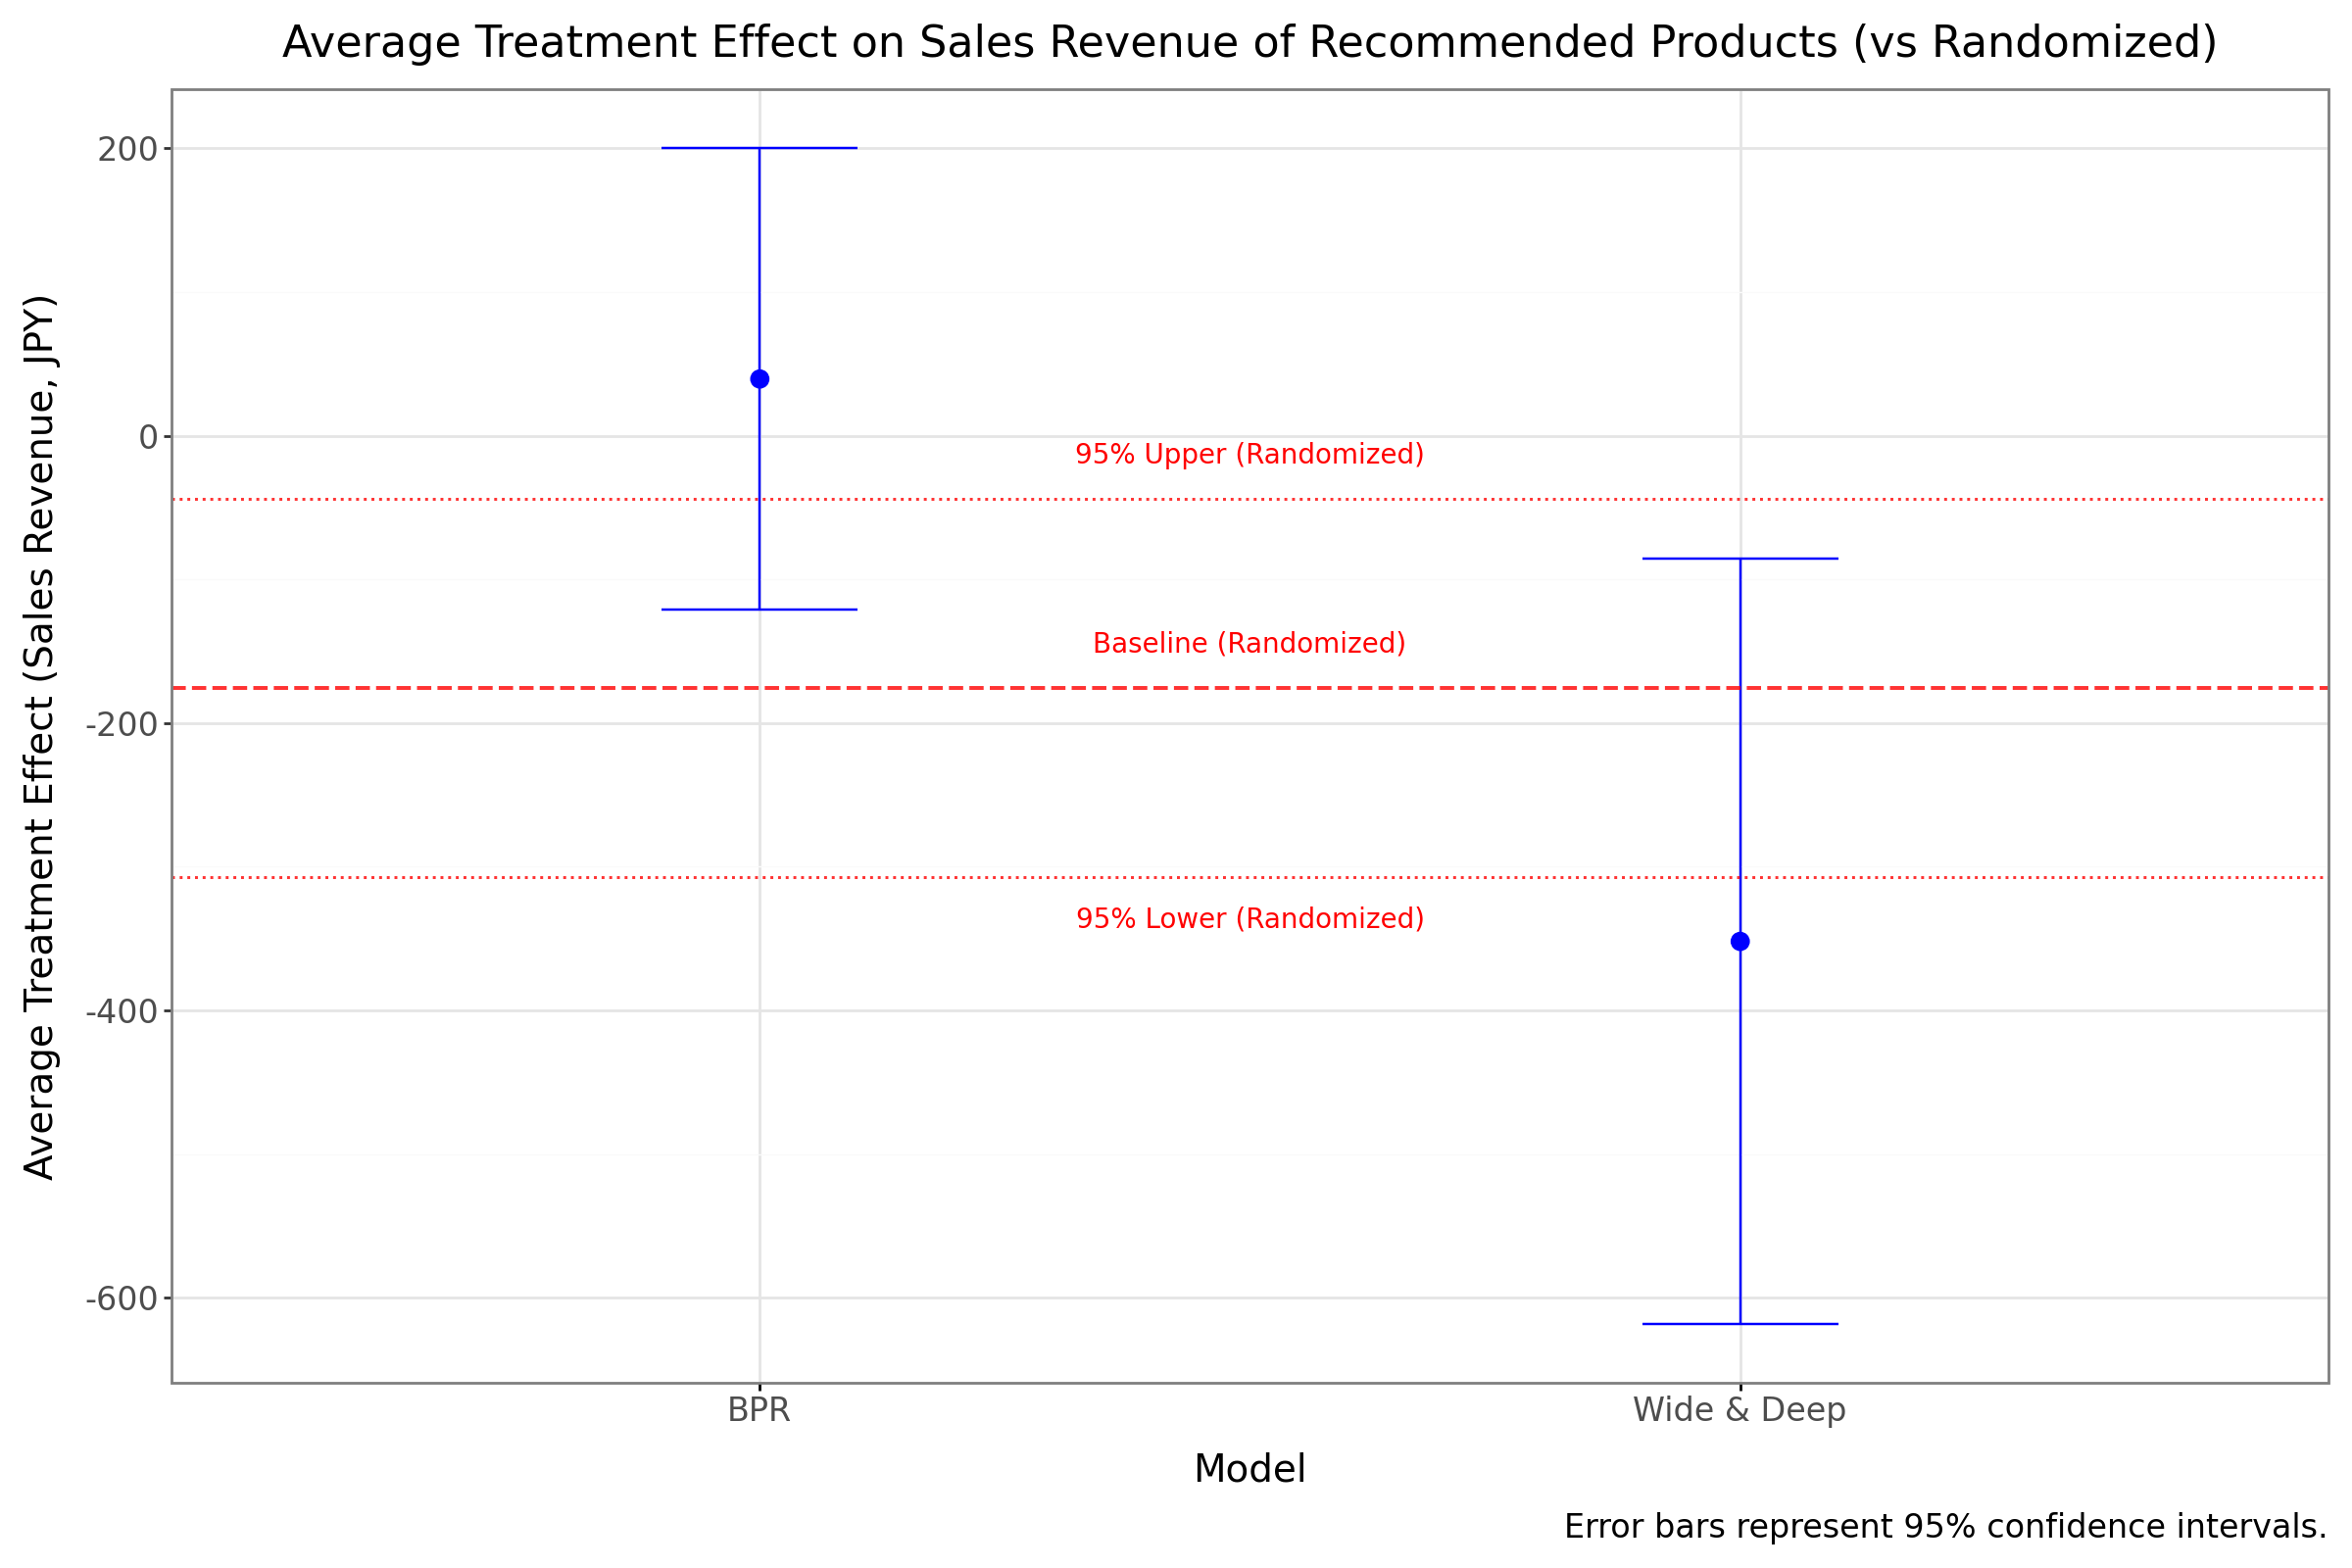

In [ ]:
# Create plot
p = (
    ggplot(comparison_data, aes(x='Model', y='Estimate'))
    + geom_point(size=3, color='blue')  # Draw points
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, color='blue')  # Draw error bars
    # Baseline average treatment effect
    + geom_hline(
        yintercept=baseline['Estimate'].values[0],
        linetype='dashed',
        color='red',
        size=0.8,
        alpha=0.8
    )
    + annotate('text', x=1.5, y=baseline['Estimate'].values[0] + 30, label='Baseline (Randomized)', color='red', size=10)
    # Baseline 95% confidence interval (Lower)
    + geom_hline(
        yintercept=baseline['CI_Lower'].values[0],
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )
    + annotate('text', x=1.5, y=baseline['CI_Lower'].values[0] - 30, label='95% Lower (Randomized)', color='red', size=10)
    # Baseline 95% confidence interval (Upper)
    + geom_hline(
        yintercept=baseline['CI_Upper'].values[0],
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )
    + annotate('text', x=1.5, y=baseline['CI_Upper'].values[0] + 30, label='95% Upper (Randomized)', color='red', size=10)
    + theme_bw()
    + theme(
        figure_size=(12, 8),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        plot_title=element_text(size=16),
        plot_caption=element_text(size=12, hjust=1)  # Align caption to the right
    )
    + labs(
        title='Average Treatment Effect on Sales Revenue of Recommended Products (vs Randomized)',
        x='Model',
        y='Average Treatment Effect (Sales Revenue, JPY)',
        caption='Error bars represent 95% confidence intervals.'  # Add caption
    )
)

p

### sales quantity

In [ ]:
# Extract coupon effect data for quantity
coupon_data_quantity = final_df_quantity.loc['Coupon']
models_quantity = final_df_quantity.columns
coupon_effect_quantity = coupon_data_quantity.str.extract(r'([-+]?\d*\.\d+|\d+)\s*\[([-+]?\d*\.\d+|\d+),\s*([-+]?\d*\.\d+|\d+)\]')
coupon_effect_quantity.columns = ['Estimate', 'CI_Lower', 'CI_Upper']
coupon_effect_quantity = coupon_effect_quantity.astype(float)
coupon_effect_quantity['Model'] = models_quantity

# Set Randomized as the baseline
baseline_quantity = coupon_effect_quantity[coupon_effect_quantity['Model'] == 'Randomized']

# Data for graph comparison
comparison_data_quantity = coupon_effect_quantity[coupon_effect_quantity['Model'].isin(['BPR', 'Wide & Deep'])]

# Baseline confidence interval
baseline_estimate_quantity = baseline_quantity['Estimate'].values[0]
baseline_ci_lower_quantity = baseline_quantity['CI_Lower'].values[0]
baseline_ci_upper_quantity = baseline_quantity['CI_Upper'].values[0]

# Create comparison table
comparison_table_quantity = comparison_data_quantity[['Model', 'Estimate', 'CI_Lower', 'CI_Upper']].copy()

# Compute Difference (vs Randomized)
comparison_table_quantity['Difference (vs Randomized)'] = comparison_table_quantity['Estimate'] - baseline_estimate_quantity

# Compute confidence intervals for the Difference
comparison_table_quantity['Difference CI Lower'] = comparison_table_quantity['CI_Lower'] - baseline_ci_upper_quantity
comparison_table_quantity['Difference CI Upper'] = comparison_table_quantity['CI_Upper'] - baseline_ci_lower_quantity

# Convert confidence intervals into formatted strings
comparison_table_quantity['Difference (vs Randomized)'] = comparison_table_quantity.apply(
    lambda row: f"{row['Difference (vs Randomized)']:.3f} [{row['Difference CI Lower']:.3f}, {row['Difference CI Upper']:.3f}]",
    axis=1
)

# Add confidence intervals to Average Treatment Effect
comparison_table_quantity['Average Treatment Effect'] = comparison_table_quantity.apply(
    lambda row: f"{row['Estimate']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]",
    axis=1
)

# Remove unnecessary columns
comparison_table_quantity = comparison_table_quantity[['Average Treatment Effect', 'Difference (vs Randomized)']]

# Convert to markdown format for display
comparison_table_quantity_md = comparison_table_quantity.to_markdown(index=True, numalign='left', stralign='left')

print(comparison_table_quantity_md)

|             | Average Treatment Effect   | Difference (vs Randomized)   |
|:------------|:---------------------------|:-----------------------------|
| BPR         | -0.004 [-0.036, 0.028]     | 0.036 [-0.024, 0.096]        |
| Wide & Deep | -0.080 [-0.143, -0.018]    | -0.040 [-0.131, 0.050]       |


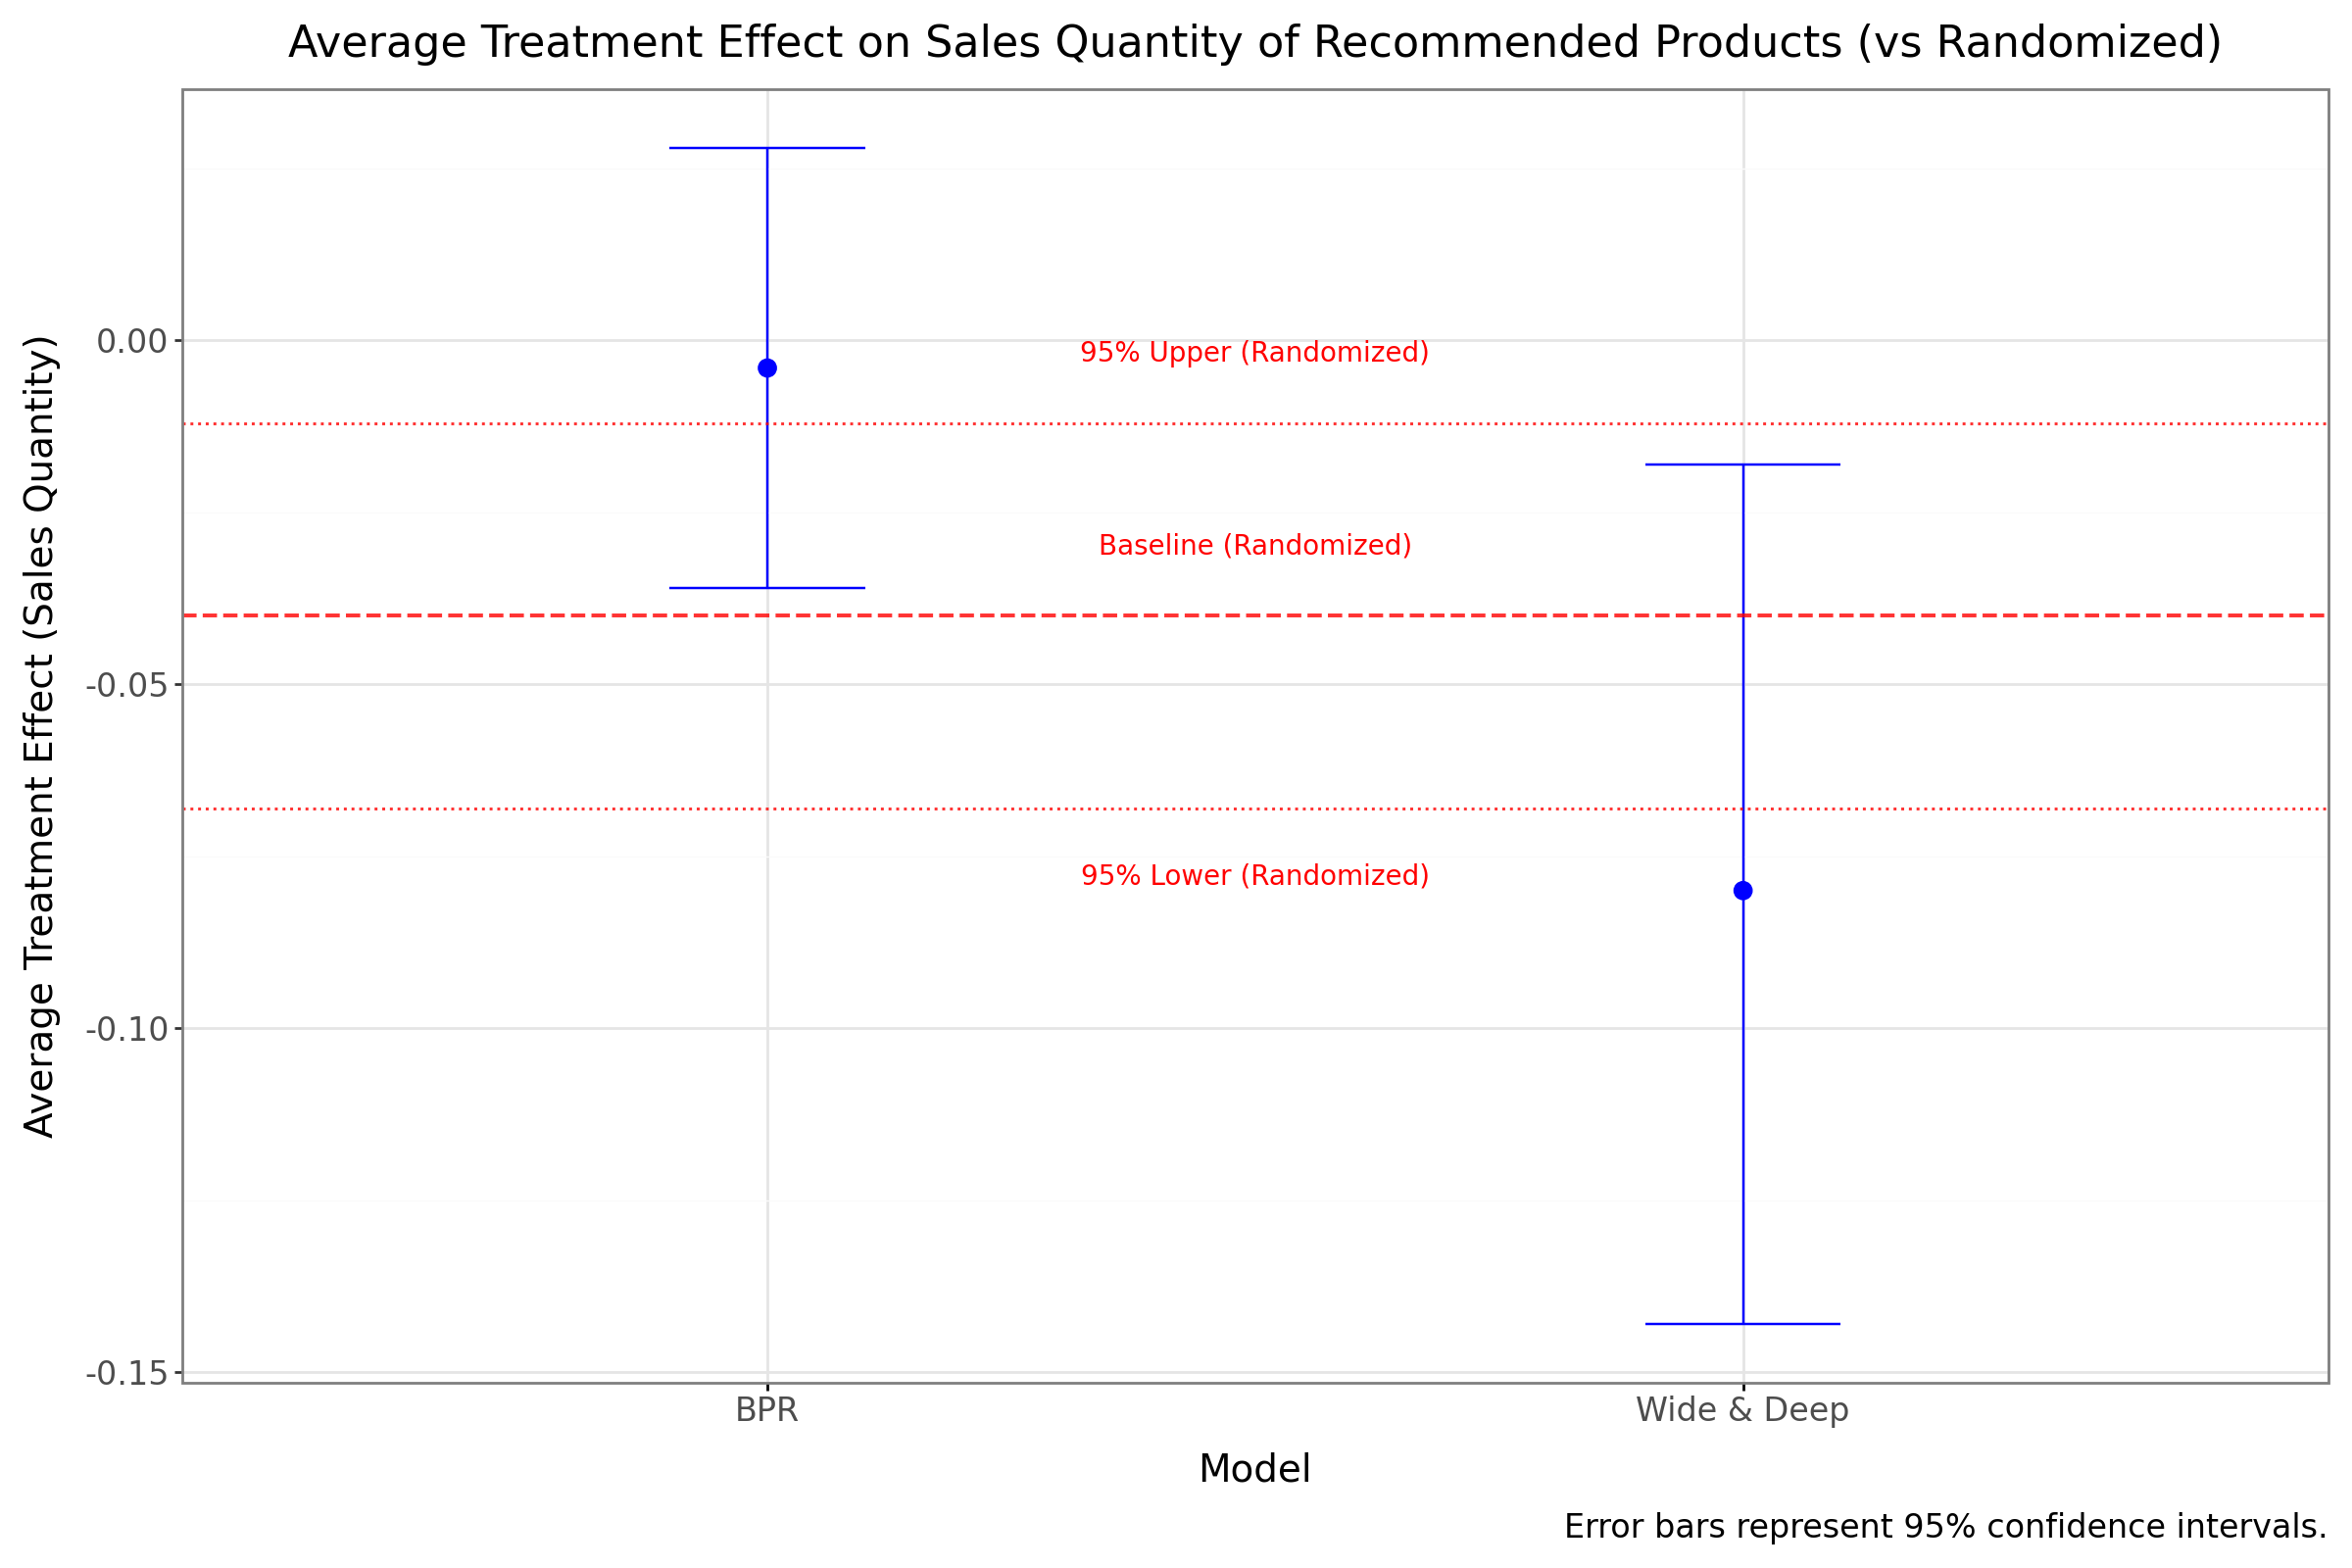

In [ ]:
# Create plot for Average Treatment Effect on Sales Quantity
p = (
    ggplot(comparison_data_quantity, aes(x='Model', y='Estimate'))
    + geom_point(size=3, color='blue')  # Draw points
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, color='blue')  # Draw error bars
    # Baseline average treatment effect
    + geom_hline(
        yintercept=baseline_quantity['Estimate'].values[0],
        linetype='dashed',
        color='red',
        size=0.8,
        alpha=0.8
    )
    + annotate('text', x=1.5, y=baseline_quantity['Estimate'].values[0] + 0.01, label='Baseline (Randomized)', color='red', size=10)
    # Baseline 95% confidence interval (Lower)
    + geom_hline(
        yintercept=baseline_quantity['CI_Lower'].values[0],
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )
    + annotate('text', x=1.5, y=baseline_quantity['CI_Lower'].values[0] - 0.01, label='95% Lower (Randomized)', color='red', size=10)
    # Baseline 95% confidence interval (Upper)
    + geom_hline(
        yintercept=baseline_quantity['CI_Upper'].values[0],
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )
    + annotate('text', x=1.5, y=baseline_quantity['CI_Upper'].values[0] + 0.01, label='95% Upper (Randomized)', color='red', size=10)
    + theme_bw()
    + theme(
        figure_size=(12, 8),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        plot_title=element_text(size=16),
        plot_caption=element_text(size=12, hjust=1)  # Align caption to the right
    )
    + labs(
        title='Average Treatment Effect on Sales Quantity of Recommended Products (vs Randomized)',
        x='Model',
        y='Average Treatment Effect (Sales Quantity)',
        caption='Error bars represent 95% confidence intervals.'  # Add caption
    )
)

p

## Differences in the Effects of Coupons and Algorithms Between Subjects With and Without Missing Attribute Information

### The Effect of Coupon

#### sales revenue

In [ ]:
# Total (Naive) model (null version)
X_nv_null = df_anl_cp_null['is_coupon']
y_nv_null = df_anl_cp_null['sales']
X_nv_null = sm.add_constant(X_nv_null)
model_nv_null = sm.OLS(y_nv_null, X_nv_null)
results_sales_nv_null = model_nv_null.fit()

# Total model (null version)
X_total_null = df_anl_cp_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_total_null = df_anl_cp_null['sales']
X_total_null = sm.add_constant(X_total_null)
model_total_null = sm.OLS(y_total_null, X_total_null)
results_sales_total_null = model_total_null.fit()

# Randomized model (null version)
X_rd_null = df_anl_cp_rd_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_rd_null = df_anl_cp_rd_null['sales']
X_rd_null = sm.add_constant(X_rd_null)
model_rd_null = sm.OLS(y_rd_null, X_rd_null)
results_sales_rd_null = model_rd_null.fit()

# BPR model (null version)
X_bpr_null = df_anl_cp_bpr_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_bpr_null = df_anl_cp_bpr_null['sales']
X_bpr_null = sm.add_constant(X_bpr_null)
model_bpr_null = sm.OLS(y_bpr_null, X_bpr_null)
results_sales_bpr_null = model_bpr_null.fit()

# Wide & Deep model (null version)
X_wd_null = df_anl_cp_wd_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_wd_null = df_anl_cp_wd_null['sales']
X_wd_null = sm.add_constant(X_wd_null)
model_wd_null = sm.OLS(y_wd_null, X_wd_null)
results_sales_wd_null = model_wd_null.fit()

# Store model results
all_results_null = [
    ("Total (Naive)", results_sales_nv_null),
    ("Total", results_sales_total_null),
    ("Randomized", results_sales_rd_null),
    ("BPR", results_sales_bpr_null),
    ("Wide & Deep", results_sales_wd_null),
]

# Total (Naive) model (non-null version)
X_nv_non_null = df_anl_cp_non_null['is_coupon']
y_nv_non_null = df_anl_cp_non_null['sales']
X_nv_non_null = sm.add_constant(X_nv_non_null)
model_nv_non_null = sm.OLS(y_nv_non_null, X_nv_non_null)
results_sales_nv_non_null = model_nv_non_null.fit()

# Total model (non-null version)
X_total_non_null = df_anl_cp_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_total_non_null = df_anl_cp_non_null['sales']
X_total_non_null = sm.add_constant(X_total_non_null)
model_total_non_null = sm.OLS(y_total_non_null, X_total_non_null)
results_sales_total_non_null = model_total_non_null.fit()

# Randomized model (non-null version)
X_rd_non_null = df_anl_cp_rd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_rd_non_null = df_anl_cp_rd_non_null['sales']
X_rd_non_null = sm.add_constant(X_rd_non_null)
model_rd_non_null = sm.OLS(y_rd_non_null, X_rd_non_null)
results_sales_rd_non_null = model_rd_non_null.fit()

# BPR model (non-null version)
X_bpr_non_null = df_anl_cp_bpr_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_bpr_non_null = df_anl_cp_bpr_non_null['sales']
X_bpr_non_null = sm.add_constant(X_bpr_non_null)
model_bpr_non_null = sm.OLS(y_bpr_non_null, X_bpr_non_null)
results_sales_bpr_non_null = model_bpr_non_null.fit()

# Wide & Deep model (non-null version)
X_wd_non_null = df_anl_cp_wd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_wd_non_null = df_anl_cp_wd_non_null['sales']
X_wd_non_null = sm.add_constant(X_wd_non_null)
model_wd_non_null = sm.OLS(y_wd_non_null, X_wd_non_null)
results_sales_wd_non_null = model_wd_non_null.fit()

# Store model results for non-null dataset
all_results_non_null = [
    ("Total (Naive)", results_sales_nv_non_null),
    ("Total", results_sales_total_non_null),
    ("Randomized", results_sales_rd_non_null),
    ("BPR", results_sales_bpr_non_null),
    ("Wide & Deep", results_sales_wd_non_null),
]


In [ ]:
# Function to generate regression results DataFrame
def create_results_df(all_results):
    results_dfs = []

    for name, results in all_results:
        if results:
            # Extract necessary information from the summary
            coef = results.params
            conf_int = results.conf_int()
            observations = results.nobs

            # Combine coefficient and confidence intervals into a formatted string
            coef_with_ci = []
            for param_name in coef.index:
                coef_value = coef[param_name]
                ci_lower, ci_upper = conf_int.loc[param_name]
                coef_with_ci.append(f"{coef_value:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

            # Create DataFrame
            df = pd.DataFrame({name: coef_with_ci}, index=coef.index)
            df.loc['Observations', name] = int(observations)

            results_dfs.append(df)
        else:
            print(f"{name} Regression failed.")

    # Combine DataFrames
    final_df = pd.concat(results_dfs, axis=1, sort=False).fillna('')
    return final_df

# Create DataFrame for non-null results
final_df_non_null = create_results_df(all_results_non_null)

# Create DataFrame for null results
final_df_null = create_results_df(all_results_null)

# Adjust index order
new_index = ['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre', 'const', 'Observations']
final_df_sales_non_null = final_df_non_null.reindex(new_index)
final_df_sales_null = final_df_null.reindex(new_index)

# Convert values to '〇' or '×' except for 'const', 'is_coupon', and 'Observations'
for df in [final_df_sales_non_null, final_df_sales_null]:
    for col in df.columns:
        for index in df.index:
            if index not in ['is_coupon', 'Observations', 'const']:
                if isinstance(df.loc[index, col], str) and df.loc[index, col] != '':
                    df.loc[index, col] = '〇'
                else:
                    df.loc[index, col] = '×'

# Mapping for index labels
index_mapping_cp = {
    'is_coupon': 'Coupon',
    'Is_Female': 'Is Female (Gender)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
    'const': 'Constant',
    'Observations': 'N'
}

# Rename index labels
final_df_sales_non_null = final_df_sales_non_null.rename(index=index_mapping_cp)
final_df_sales_null = final_df_sales_null.rename(index=index_mapping_cp)

# Convert DataFrames to markdown format
reg_table_sales_non_null = final_df_sales_non_null.to_markdown(index=True, numalign='left', stralign='left')
reg_table_sales_null = final_df_sales_null.to_markdown(index=True, numalign='left', stralign='left')


# Standardize required columns and index for merging
common_index = ['Coupon', 'Is Female (Gender)', 'Is 30s (Age)', 'Is China (Region)', 'Pre-order (Counts)', 'Diff Departure Pre-order (Day)', 'Constant', 'N']
common_columns = final_df_sales.columns

# Align all DataFrames to the standard format and fill missing values with "×"
final_df_sales_aligned = final_df_sales.reindex(index=common_index, columns=common_columns).fillna("×")
final_df_sales_null_aligned = final_df_sales_null.reindex(index=common_index, columns=common_columns).fillna("×")
final_df_sales_non_null_aligned = final_df_sales_non_null.reindex(index=common_index, columns=common_columns).fillna("×")

# Create Overall, Nan, Non-Nan results for each model
merged_dataframes = []

for model in common_columns:
    # Extract data for each model
    overall = final_df_sales_aligned[model]
    nan = final_df_sales_null_aligned[model]
    non_nan = final_df_sales_non_null_aligned[model]

    # Create DataFrame with MultiIndex for columns
    model_df = pd.DataFrame({
        (model, "Overall"): overall,
        (model, "Missing"): nan,
        (model, "Complete"): non_nan
    })

    merged_dataframes.append(model_df)

# Combine all model results
final_merged_df = pd.concat(merged_dataframes, axis=1)

# Set MultiIndex for columns
final_merged_df.columns = pd.MultiIndex.from_tuples(final_merged_df.columns)

# Convert to Markdown format
final_merged_md = final_merged_df.to_markdown(numalign="left", stralign="left")
print(final_merged_md)

|                                | ('Total (Naive)', 'Overall')   | ('Total (Naive)', 'Missing')   | ('Total (Naive)', 'Complete')   | ('Total', 'Overall')         | ('Total', 'Missing')          | ('Total', 'Complete')     | ('Randomized', 'Overall')    | ('Randomized', 'Missing')    | ('Randomized', 'Complete')   | ('BPR', 'Overall')         | ('BPR', 'Missing')          | ('BPR', 'Complete')         | ('Wide & Deep', 'Overall')   | ('Wide & Deep', 'Missing')    | ('Wide & Deep', 'Complete')   |
|:-------------------------------|:-------------------------------|:-------------------------------|:--------------------------------|:-----------------------------|:------------------------------|:--------------------------|:-----------------------------|:-----------------------------|:-----------------------------|:---------------------------|:----------------------------|:----------------------------|:-----------------------------|:------------------------------|:--------------------------

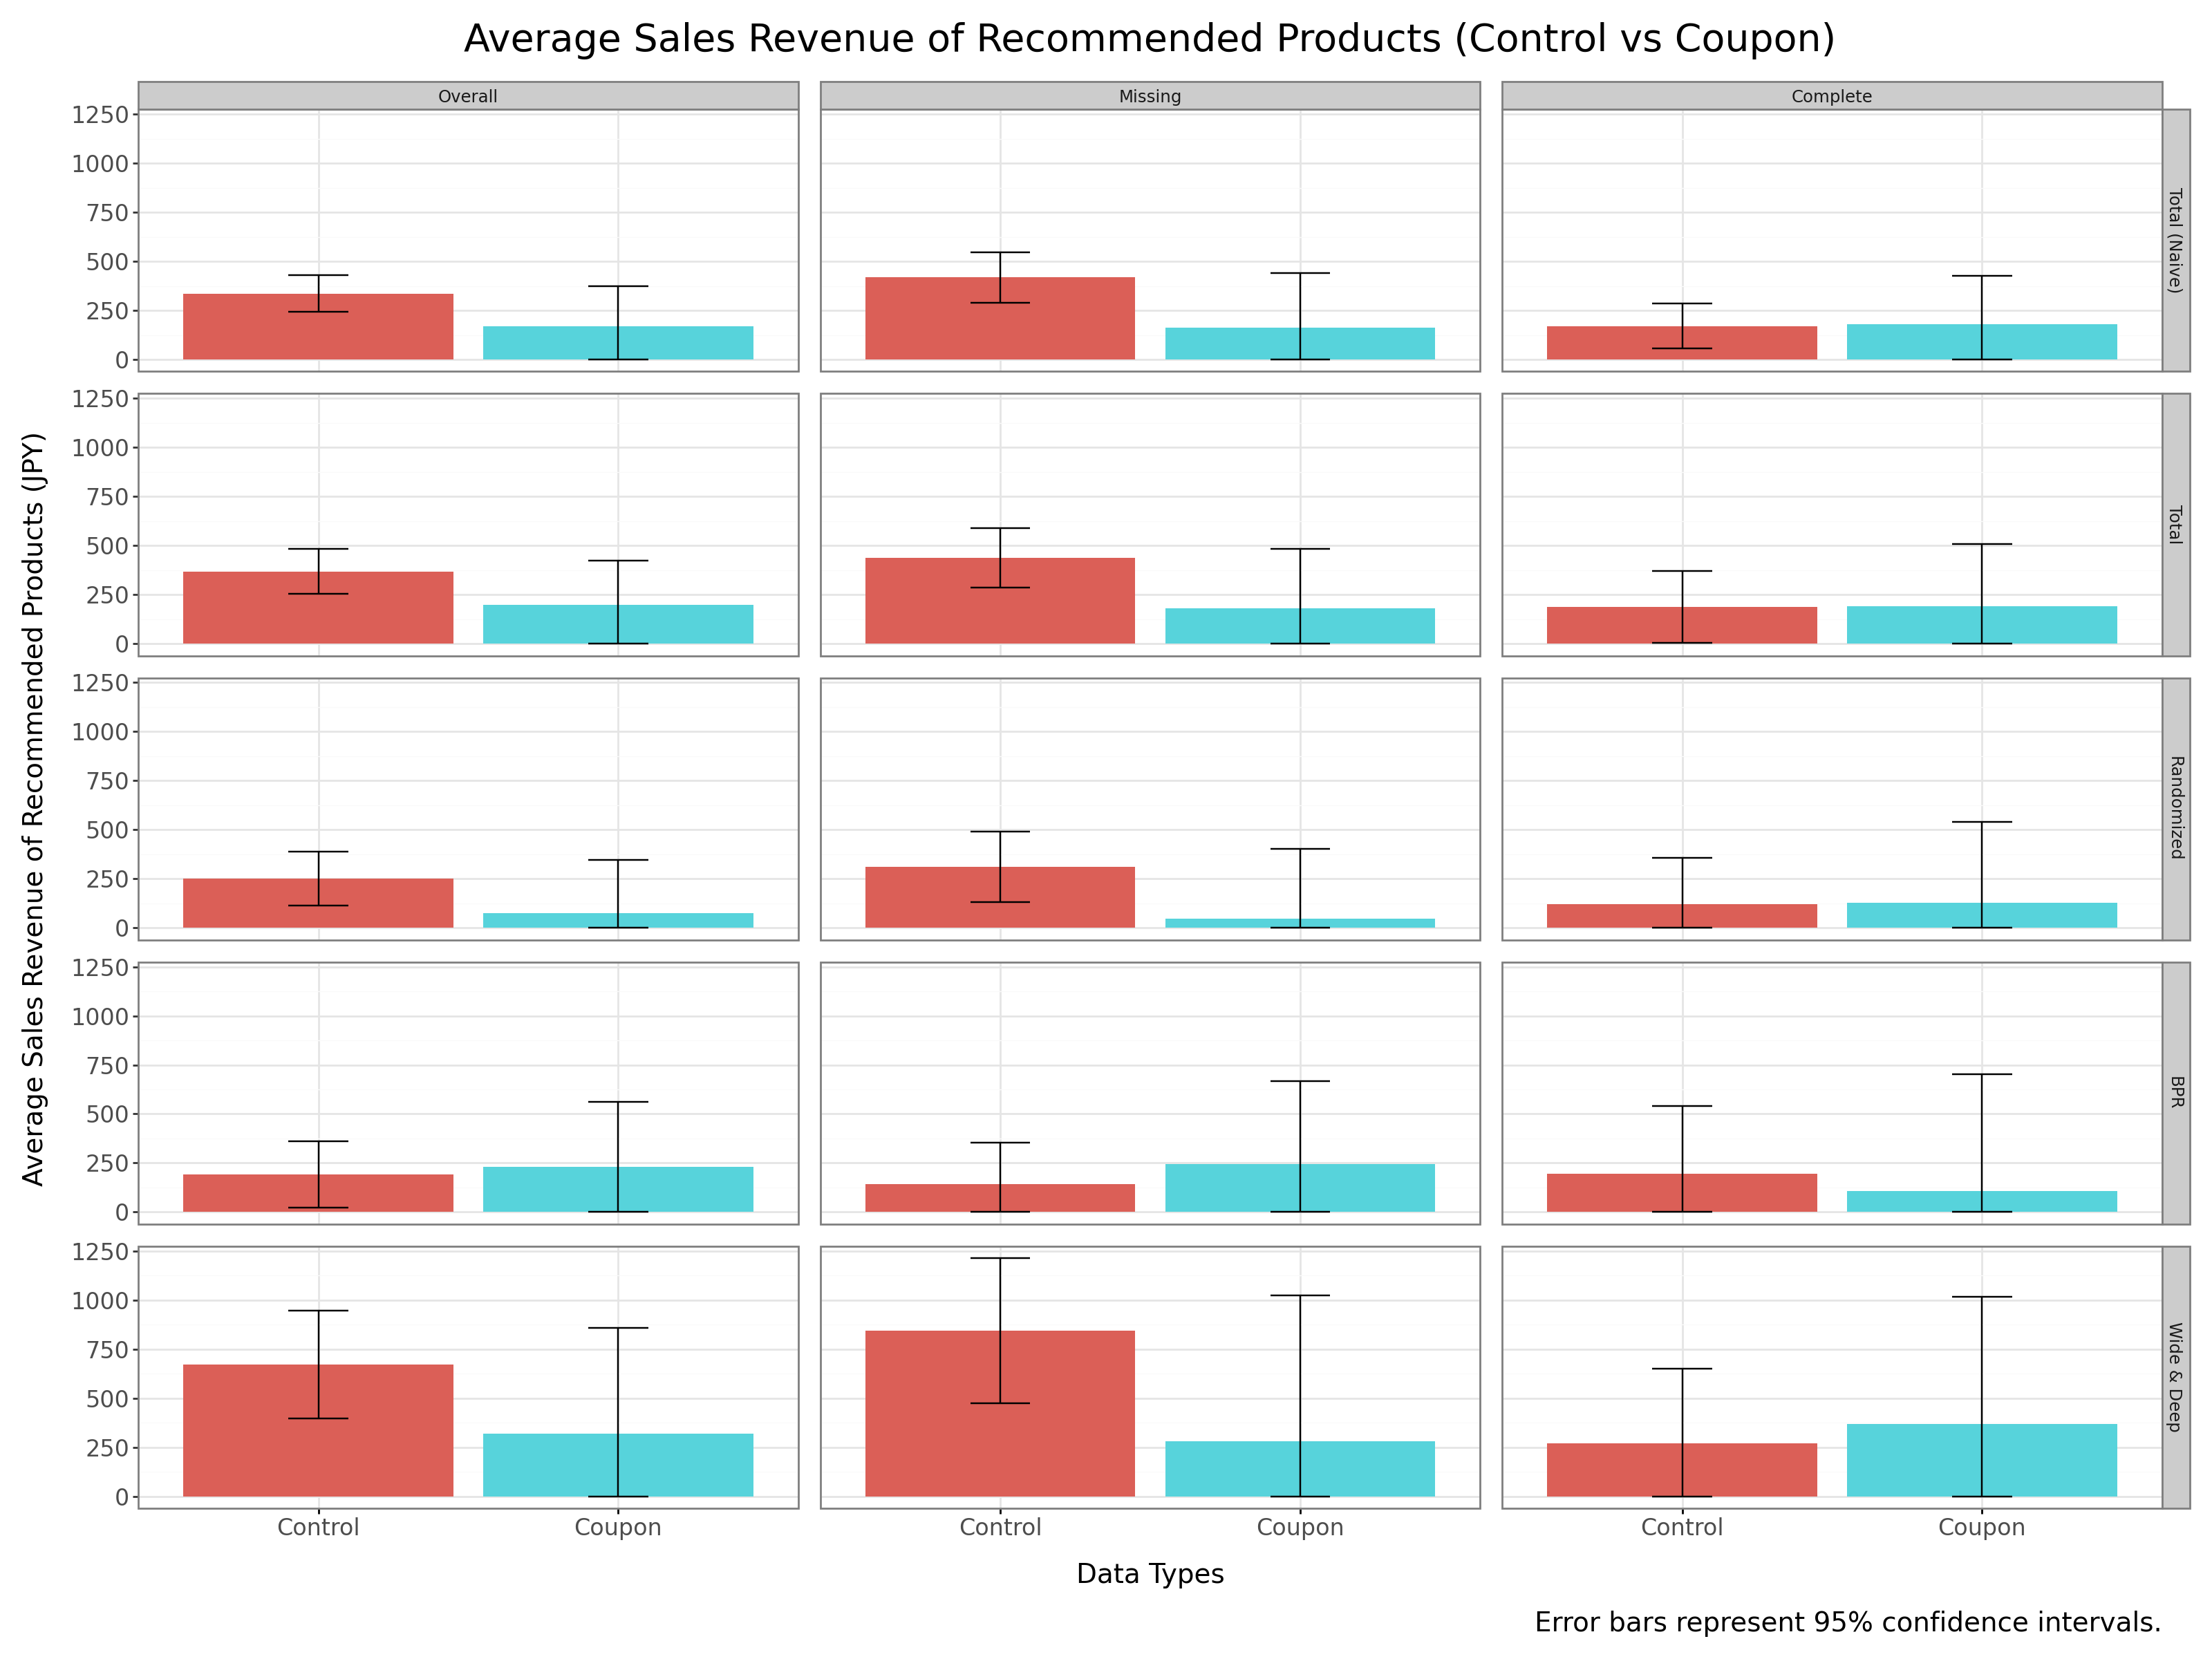

In [ ]:
# Create plot data for overall results
plot_data_overall = pd.concat([
    create_plot_df(results_sales_nv, "Total (Naive)"),
    create_plot_df(results_sales_total, "Total"),
    create_plot_df(results_sales_rd, "Randomized"),
    create_plot_df(results_sales_bpr, "BPR"),
    create_plot_df(results_sales_wd, "Wide & Deep"),
], ignore_index=True).dropna()

# Create plot data for non-null results
plot_data_non_null = pd.concat([
    create_plot_df(results_sales_nv_non_null, "Total (Naive)"),
    create_plot_df(results_sales_total_non_null, "Total"),
    create_plot_df(results_sales_rd_non_null, "Randomized"),
    create_plot_df(results_sales_bpr_non_null, "BPR"),
    create_plot_df(results_sales_wd_non_null, "Wide & Deep"),
], ignore_index=True).dropna()

# Convert Model column to categorical type for non-null data
plot_data_non_null['Model'] = pd.Categorical(plot_data_non_null['Model'], categories=model_order, ordered=True)

# Create plot data for null results
plot_data_null = pd.concat([
    create_plot_df(results_sales_nv_null, "Total (Naive)"),
    create_plot_df(results_sales_total_null, "Total"),
    create_plot_df(results_sales_rd_null, "Randomized"),
    create_plot_df(results_sales_bpr_null, "BPR"),
    create_plot_df(results_sales_wd_null, "Wide & Deep"),
], ignore_index=True).dropna()

# Convert Model column to categorical type for null data
plot_data_null['Model'] = pd.Categorical(plot_data_null['Model'], categories=model_order, ordered=True)

# Add "Data Type" column
plot_data_overall['Data Type'] = 'Overall'
plot_data_non_null['Data Type'] = 'Complete'
plot_data_null['Data Type'] = 'Missing'

# Convert Model column to categorical type for overall data
plot_data_overall['Model'] = pd.Categorical(plot_data_overall['Model'], categories=model_order, ordered=True)

# Combine the three datasets
combined_plot_data = pd.concat([plot_data_overall, plot_data_non_null, plot_data_null], ignore_index=True)

# Convert categorical columns for proper ordering
combined_plot_data['Data Type'] = pd.Categorical(combined_plot_data['Data Type'], categories=['Overall', 'Missing', 'Complete'], ordered=True)
combined_plot_data['Model'] = pd.Categorical(combined_plot_data['Model'], categories=model_order, ordered=True)

# Create combined plot
p = (
    ggplot(combined_plot_data, aes(x='Variable', y='Estimate', fill='Variable'))
    + geom_bar(stat='identity', position=position_dodge(width=0.5))
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, position=position_dodge(width=0.5))
    + facet_grid('Model~Data Type')  # Rows: Model, Columns: Data Type
    + theme_bw()
    + theme(
        figure_size=(16, 12),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        plot_title=element_text(size=20),
        plot_caption=element_text(size=14, hjust=1, vjust=0)  # Adjust caption to bottom right
    )
    + labs(
        title="Average Sales Revenue of Recommended Products (Control vs Coupon)",
        x="Data Types",
        y="Average Sales Revenue of Recommended Products (JPY)",
        caption="Error bars represent 95% confidence intervals."  # Add caption
    )
    + guides(fill=False)  # Remove legend
)

# Display plot
p

In [ ]:
#post-pre-order sales revenue
print(df_anl_cp_non_null['Sales_in_real'].mean())
print(df_anl_cp_rd_non_null['Sales_in_real'].mean())
print(df_anl_cp_bpr_non_null['Sales_in_real'].mean())
print(df_anl_cp_wd_non_null['Sales_in_real'].mean())

print(df_anl_cp_null['Sales_in_real'].mean())
print(df_anl_cp_rd_null['Sales_in_real'].mean())
print(df_anl_cp_bpr_null['Sales_in_real'].mean())
print(df_anl_cp_wd_null['Sales_in_real'].mean())

40773.9048220678
40099.504327755334
40892.80672823219
41432.892
25158.496263691268
25681.42983395822
24548.534729145897
25119.745538664905


#### sales quantity

In [ ]:
# Non-Null Model Results
X_nv_quantity_non_null = df_anl_cp_non_null['is_coupon']
y_nv_quantity_non_null = df_anl_cp_non_null['quantity']
X_nv_quantity_non_null = sm.add_constant(X_nv_quantity_non_null)
model_nv_quantity_non_null = sm.OLS(y_nv_quantity_non_null, X_nv_quantity_non_null)
results_quantity_nv_non_null = model_nv_quantity_non_null.fit()

X_total_quantity_non_null = df_anl_cp_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_total_quantity_non_null = df_anl_cp_non_null['quantity']
X_total_quantity_non_null = sm.add_constant(X_total_quantity_non_null)
model_total_quantity_non_null = sm.OLS(y_total_quantity_non_null, X_total_quantity_non_null)
results_quantity_total_non_null = model_total_quantity_non_null.fit()

X_rd_quantity_non_null = df_anl_cp_rd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_rd_quantity_non_null = df_anl_cp_rd_non_null['quantity']
X_rd_quantity_non_null = sm.add_constant(X_rd_quantity_non_null)
model_rd_quantity_non_null = sm.OLS(y_rd_quantity_non_null, X_rd_quantity_non_null)
results_quantity_rd_non_null = model_rd_quantity_non_null.fit()

X_bpr_quantity_non_null = df_anl_cp_bpr_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_bpr_quantity_non_null = df_anl_cp_bpr_non_null['quantity']
X_bpr_quantity_non_null = sm.add_constant(X_bpr_quantity_non_null)
model_bpr_quantity_non_null = sm.OLS(y_bpr_quantity_non_null, X_bpr_quantity_non_null)
results_quantity_bpr_non_null = model_bpr_quantity_non_null.fit()

X_wd_quantity_non_null = df_anl_cp_wd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_wd_quantity_non_null = df_anl_cp_wd_non_null['quantity']
X_wd_quantity_non_null = sm.add_constant(X_wd_quantity_non_null)
model_wd_quantity_non_null = sm.OLS(y_wd_quantity_non_null, X_wd_quantity_non_null)
results_quantity_wd_non_null = model_wd_quantity_non_null.fit()

# Store model results (Non-Null version)
all_results_quantity_non_null = [
    ("Total (Naive)", results_quantity_nv_non_null),
    ("Total", results_quantity_total_non_null),
    ("Randomized", results_quantity_rd_non_null),
    ("BPR", results_quantity_bpr_non_null),
    ("Wide & Deep", results_quantity_wd_non_null),
]

# Null Model Results
X_nv_quantity_null = df_anl_cp_null['is_coupon']
y_nv_quantity_null = df_anl_cp_null['quantity']
X_nv_quantity_null = sm.add_constant(X_nv_quantity_null)
model_nv_quantity_null = sm.OLS(y_nv_quantity_null, X_nv_quantity_null)
results_quantity_nv_null = model_nv_quantity_null.fit()

X_total_quantity_null = df_anl_cp_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_total_quantity_null = df_anl_cp_null['quantity']
X_total_quantity_null = sm.add_constant(X_total_quantity_null)
model_total_quantity_null = sm.OLS(y_total_quantity_null, X_total_quantity_null)
results_quantity_total_null = model_total_quantity_null.fit()

X_rd_quantity_null = df_anl_cp_rd_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_rd_quantity_null = df_anl_cp_rd_null['quantity']
X_rd_quantity_null = sm.add_constant(X_rd_quantity_null)
model_rd_quantity_null = sm.OLS(y_rd_quantity_null, X_rd_quantity_null)
results_quantity_rd_null = model_rd_quantity_null.fit()

X_bpr_quantity_null = df_anl_cp_bpr_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_bpr_quantity_null = df_anl_cp_bpr_null['quantity']
X_bpr_quantity_null = sm.add_constant(X_bpr_quantity_null)
model_bpr_quantity_null = sm.OLS(y_bpr_quantity_null, X_bpr_quantity_null)
results_quantity_bpr_null = model_bpr_quantity_null.fit()

X_wd_quantity_null = df_anl_cp_wd_null[['is_coupon', 'Pre-order_Count', 'Diff_Dep_Pre']]
y_wd_quantity_null = df_anl_cp_wd_null['quantity']
X_wd_quantity_null = sm.add_constant(X_wd_quantity_null)
model_wd_quantity_null = sm.OLS(y_wd_quantity_null, X_wd_quantity_null)
results_quantity_wd_null = model_wd_quantity_null.fit()

# Store model results (Null version)
all_results_quantity_null = [
    ("Total (Naive)", results_quantity_nv_null),
    ("Total", results_quantity_total_null),
    ("Randomized", results_quantity_rd_null),
    ("BPR", results_quantity_bpr_null),
    ("Wide & Deep", results_quantity_wd_null),
]


In [ ]:
# Function to create regression results DataFrame
def create_results_df(all_results):
    results_dfs = []

    for name, results in all_results:
        if results:
            coef = results.params
            conf_int = results.conf_int()
            observations = results.nobs

            coef_with_ci = []
            for param_name in coef.index:
                coef_value = coef[param_name]
                ci_lower, ci_upper = conf_int.loc[param_name]
                coef_with_ci.append(f"{coef_value:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

            df = pd.DataFrame({name: coef_with_ci}, index=coef.index)
            df.loc['Observations', name] = int(observations)

            results_dfs.append(df)
        else:
            print(f"{name} Regression failed.")

    return pd.concat(results_dfs, axis=1, sort=False).fillna('')

# Generate DataFrames for overall, non-null, and null cases
final_df_quantity_overall = create_results_df(all_results_quantity)
final_df_quantity_non_null = create_results_df(all_results_quantity_non_null)
final_df_quantity_null = create_results_df(all_results_quantity_null)

# Adjust index order
new_index_quantity = ['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre', 'const', 'Observations']
for df in [final_df_quantity_overall, final_df_quantity_non_null, final_df_quantity_null]:
    df.reindex(new_index_quantity)

# Convert values to '〇' or '×' except for 'const', 'is_coupon', and 'Observations'
for df in [final_df_quantity_overall, final_df_quantity_non_null, final_df_quantity_null]:
    for col in df.columns:
        for index in df.index:
            if index not in ['is_coupon', 'Observations', 'const']:
                if isinstance(df.loc[index, col], str) and df.loc[index, col] != '':
                    df.loc[index, col] = '〇'
                else:
                    df.loc[index, col] = '×'

# Rename index labels
index_mapping_cp_quantity = {
    'is_coupon': 'Coupon',
    'Is_Female': 'Is Female (Gender)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
    'const': 'Constant',
    'Observations': 'N'
}

final_df_quantity_overall = final_df_quantity_overall.rename(index=index_mapping_cp_quantity)
final_df_quantity_non_null = final_df_quantity_non_null.rename(index=index_mapping_cp_quantity)
final_df_quantity_null = final_df_quantity_null.rename(index=index_mapping_cp_quantity)

# Convert DataFrames to markdown format
reg_table_quantity_overall = final_df_quantity_overall.to_markdown(numalign='left', stralign='left')
reg_table_quantity_non_null = final_df_quantity_non_null.to_markdown(numalign='left', stralign='left')
reg_table_quantity_null = final_df_quantity_null.to_markdown(numalign='left', stralign='left')

# Standardizing required columns and index for merging
common_index_quantity = ['Coupon', 'Is Female (Sex)', 'Is 30s (Age)', 'Is China (Region)',
                         'Pre-order (Counts)', 'Diff Departure Pre-order (Day)', 'Constant', 'N']
common_columns_quantity = final_df_quantity_overall.columns

# Align all DataFrames to the standard format and fill missing values with "×"
final_df_quantity_overall_aligned = final_df_quantity_overall.reindex(index=common_index_quantity, columns=common_columns_quantity).fillna("×")
final_df_quantity_non_null_aligned = final_df_quantity_non_null.reindex(index=common_index_quantity, columns=common_columns_quantity).fillna("×")
final_df_quantity_null_aligned = final_df_quantity_null.reindex(index=common_index_quantity, columns=common_columns_quantity).fillna("×")

# Create Overall, Nan, Non-Nan results for each model
merged_dataframes_quantity = []

for model in common_columns_quantity:
    overall = final_df_quantity_overall_aligned[model]
    nan = final_df_quantity_null_aligned[model]
    non_nan = final_df_quantity_non_null_aligned[model]

    model_df_quantity = pd.DataFrame({
        (model, "Overall"): overall,
        (model, "Missing"): nan,
        (model, "Complete"): non_nan
    })

    merged_dataframes_quantity.append(model_df_quantity)

# Combine all model results
final_merged_df_quantity = pd.concat(merged_dataframes_quantity, axis=1)

# Set MultiIndex for columns
final_merged_df_quantity.columns = pd.MultiIndex.from_tuples(final_merged_df_quantity.columns)

# Convert to Markdown format
final_merged_md_quantity = final_merged_df_quantity.to_markdown(numalign="left", stralign="left")

print(final_merged_md_quantity)


|                                | ('Total (Naive)', 'Overall')   | ('Total (Naive)', 'Missing')   | ('Total (Naive)', 'Complete')   | ('Total', 'Overall')    | ('Total', 'Missing')    | ('Total', 'Complete')   | ('Randomized', 'Overall')   | ('Randomized', 'Missing')   | ('Randomized', 'Complete')   | ('BPR', 'Overall')     | ('BPR', 'Missing')    | ('BPR', 'Complete')    | ('Wide & Deep', 'Overall')   | ('Wide & Deep', 'Missing')   | ('Wide & Deep', 'Complete')   |
|:-------------------------------|:-------------------------------|:-------------------------------|:--------------------------------|:------------------------|:------------------------|:------------------------|:----------------------------|:----------------------------|:-----------------------------|:-----------------------|:----------------------|:-----------------------|:-----------------------------|:-----------------------------|:------------------------------|
| Coupon                         | -0.042 [-0.067, -0.01

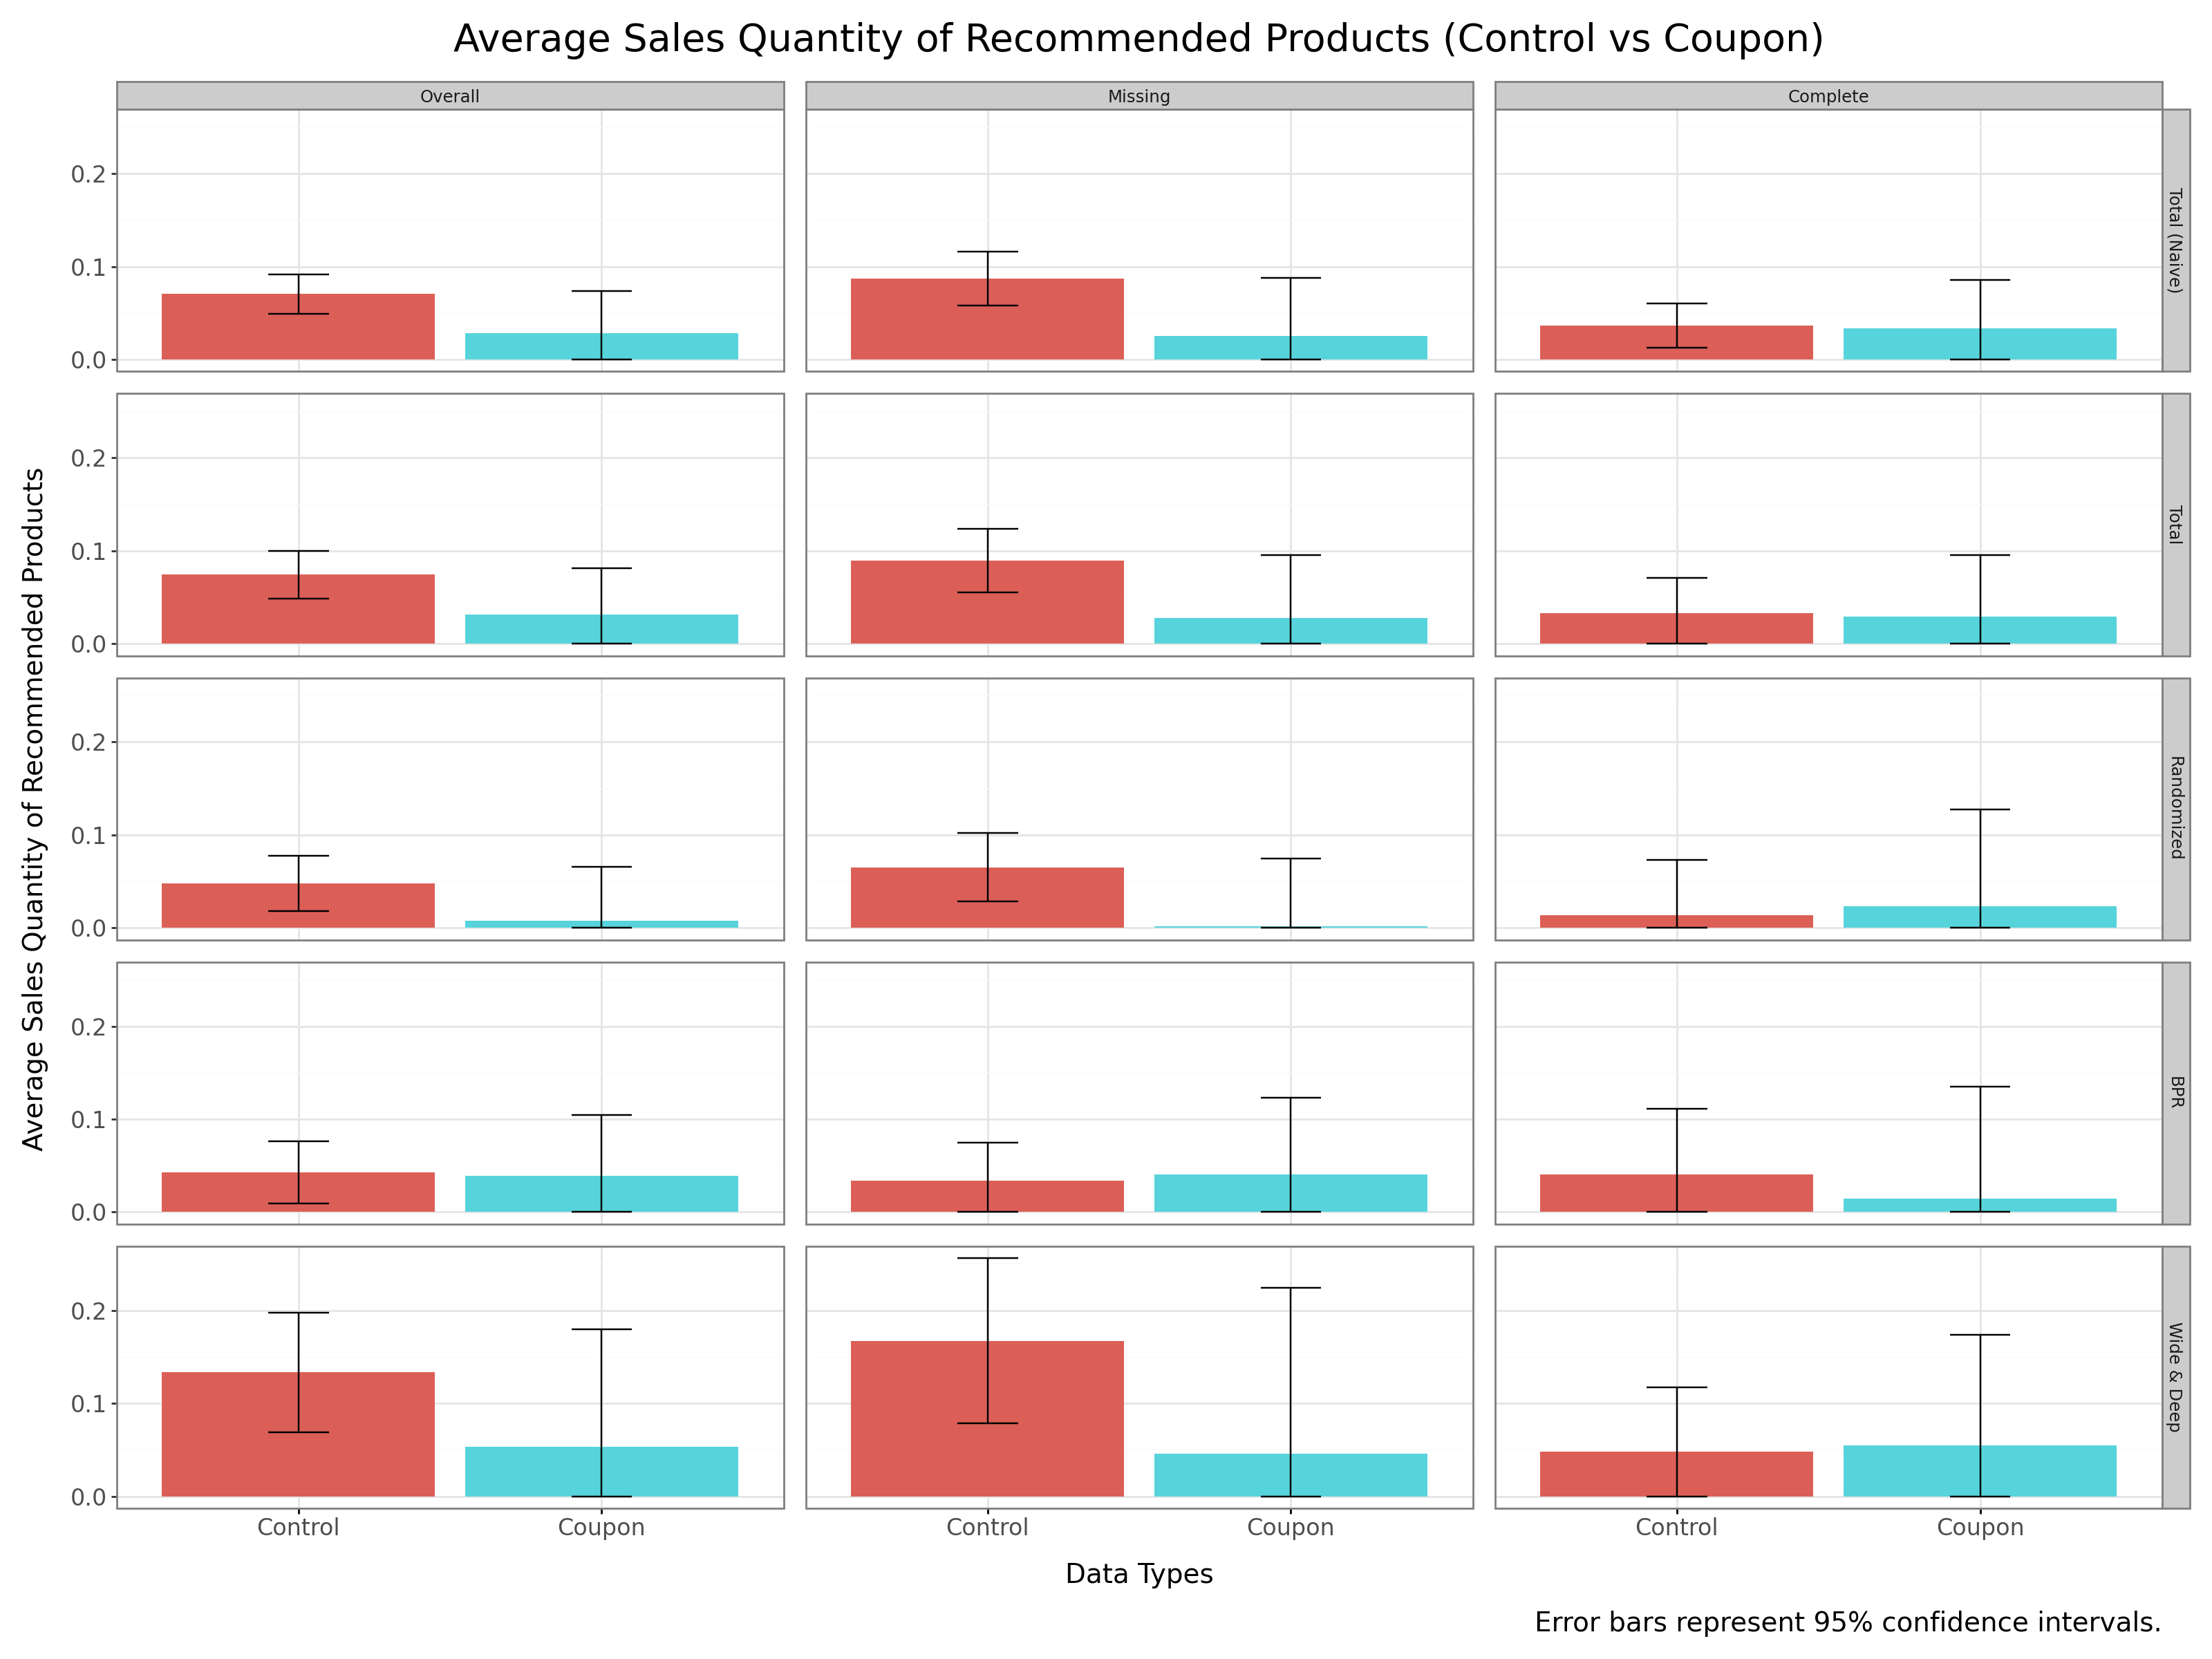

In [ ]:
# Create plot data for overall quantity results
plot_data_overall_quantity = pd.concat([
    create_plot_df(results_quantity_nv, "Total (Naive)"),
    create_plot_df(results_quantity_total, "Total"),
    create_plot_df(results_quantity_rd, "Randomized"),
    create_plot_df(results_quantity_bpr, "BPR"),
    create_plot_df(results_quantity_wd, "Wide & Deep"),
], ignore_index=True).dropna()

# Create plot data for non-null quantity results
plot_data_non_null_quantity = pd.concat([
    create_plot_df(results_quantity_nv_non_null, "Total (Naive)"),
    create_plot_df(results_quantity_total_non_null, "Total"),
    create_plot_df(results_quantity_rd_non_null, "Randomized"),
    create_plot_df(results_quantity_bpr_non_null, "BPR"),
    create_plot_df(results_quantity_wd_non_null, "Wide & Deep"),
], ignore_index=True).dropna()

# Convert "Model" column to categorical type for non-null data
plot_data_non_null_quantity['Model'] = pd.Categorical(
    plot_data_non_null_quantity['Model'], categories=model_order, ordered=True
)

# Create plot data for null quantity results
plot_data_null_quantity = pd.concat([
    create_plot_df(results_quantity_nv_null, "Total (Naive)"),
    create_plot_df(results_quantity_total_null, "Total"),
    create_plot_df(results_quantity_rd_null, "Randomized"),
    create_plot_df(results_quantity_bpr_null, "BPR"),
    create_plot_df(results_quantity_wd_null, "Wide & Deep"),
], ignore_index=True).dropna()

# Convert "Model" column to categorical type for null data
plot_data_null_quantity['Model'] = pd.Categorical(
    plot_data_null_quantity['Model'], categories=model_order, ordered=True
)

# Assign "Data Type" labels
plot_data_overall_quantity['Data Type'] = 'Overall'
plot_data_non_null_quantity['Data Type'] = 'Complete'
plot_data_null_quantity['Data Type'] = 'Missing'

# Convert "Model" column to categorical type for overall data
plot_data_overall_quantity['Model'] = pd.Categorical(
    plot_data_overall_quantity['Model'], categories=model_order, ordered=True
)

# Combine all datasets in the order: Overall → Missing → Complete
combined_plot_data_quantity = pd.concat([
    plot_data_overall_quantity, plot_data_null_quantity, plot_data_non_null_quantity
], ignore_index=True)

# Convert categorical columns for proper ordering
combined_plot_data_quantity['Data Type'] = pd.Categorical(
    combined_plot_data_quantity['Data Type'], categories=['Overall', 'Missing', 'Complete'], ordered=True
)
combined_plot_data_quantity['Model'] = pd.Categorical(
    combined_plot_data_quantity['Model'], categories=model_order, ordered=True
)

# Create the visualization
p = (
    ggplot(combined_plot_data_quantity, aes(x='Variable', y='Estimate', fill='Variable'))
    + geom_bar(stat='identity', position=position_dodge(width=0.5))
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, position=position_dodge(width=0.5))
    + facet_grid('Model~Data Type')
    + theme_bw()
    + theme(
        figure_size=(16, 12),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        plot_title=element_text(size=20),
        plot_caption=element_text(size=14, hjust=1, vjust=0)
    )
    + labs(
        title="Average Sales Quantity of Recommended Products (Control vs Coupon)",
        x="Data Types",
        y="Average Sales Quantity of Recommended Products",
        caption="Error bars represent 95% confidence intervals."
    )
    + guides(fill=False)
)

# Display the result
p

In [ ]:
#post-pre-order sales quantity
print(df_anl_cp_non_null['Quantity_in_real'].mean())
print(df_anl_cp_rd_non_null['Quantity_in_real'].mean())
print(df_anl_cp_bpr_non_null['Quantity_in_real'].mean())
print(df_anl_cp_wd_non_null['Quantity_in_real'].mean())

print(df_anl_cp_null['Quantity_in_real'].mean())
print(df_anl_cp_rd_null['Quantity_in_real'].mean())
print(df_anl_cp_bpr_null['Quantity_in_real'].mean())
print(df_anl_cp_wd_null['Quantity_in_real'].mean())

10.5028427037271
10.578765147143681
10.393799472295514
10.525333333333334
6.667724434435459
6.71531869309052
6.538384845463609
6.737607402511567


### The Effects of Algorithms

#### salese revenue

In [ ]:
# Function to extract and format coupon effect data
def prepare_coupon_effect_data(df, label):
    """Extract and format coupon effect data for visualization."""
    coupon_data = df.loc['Coupon']
    models = df.columns
    coupon_effect = coupon_data.str.extract(r'([-+]?\d*\.\d+|\d+)\s*\[([-+]?\d*\.\d+|\d+),\s*([-+]?\d*\.\d+|\d+)\]')
    coupon_effect.columns = ['Estimate', 'CI_Lower', 'CI_Upper']
    coupon_effect = coupon_effect.astype(float)
    coupon_effect['Model'] = models
    coupon_effect['Type'] = label  # Data type (Overall, Missing, Complete)
    return coupon_effect

# Prepare coupon effect data for each data type
coupon_effect_overall = prepare_coupon_effect_data(final_df_sales, 'Overall')
coupon_effect_null = prepare_coupon_effect_data(final_df_sales_null, 'Missing')
coupon_effect_non_null = prepare_coupon_effect_data(final_df_sales_non_null, 'Complete')

# Combine all data into a single DataFrame
coupon_effect_combined = pd.concat([coupon_effect_overall, coupon_effect_null, coupon_effect_non_null], ignore_index=True)

# Filter only BPR and Wide & Deep for visualization
comparison_data = coupon_effect_combined[coupon_effect_combined['Model'].isin(['BPR', 'Wide & Deep'])]

# Extract Baseline (Randomized) for each Type
baseline_data = coupon_effect_combined[coupon_effect_combined['Model'] == 'Randomized']
baseline_dict = baseline_data.set_index('Type').to_dict(orient='index')

# Ensure correct order for "Type" column
comparison_data['Type'] = pd.Categorical(
    comparison_data['Type'], categories=['Overall', 'Missing', 'Complete'], ordered=True
)

# Create comparison table
comparison_table = comparison_data[['Model', 'Type', 'Estimate', 'CI_Lower', 'CI_Upper']].copy()

# Compute differences vs Randomized baseline for each Type
comparison_table['Difference (vs Randomized)'] = comparison_table.apply(
    lambda row: row['Estimate'] - baseline_dict[row['Type']]['Estimate'], axis=1
)

# Compute confidence intervals for differences
comparison_table['Difference CI Lower'] = comparison_table.apply(
    lambda row: row['CI_Lower'] - baseline_dict[row['Type']]['CI_Upper'], axis=1
)
comparison_table['Difference CI Upper'] = comparison_table.apply(
    lambda row: row['CI_Upper'] - baseline_dict[row['Type']]['CI_Lower'], axis=1
)

# Format output with confidence intervals
comparison_table['Average Treatment Effect'] = comparison_table.apply(
    lambda row: f"{row['Estimate']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]", axis=1
)
comparison_table['Difference (vs Randomized)'] = comparison_table.apply(
    lambda row: f"{row['Difference (vs Randomized)']:.3f} [{row['Difference CI Lower']:.3f}, {row['Difference CI Upper']:.3f}]", axis=1
)

# Keep only necessary columns
comparison_table = comparison_table[['Model', 'Type', 'Average Treatment Effect', 'Difference (vs Randomized)']]

# Convert to Markdown format
comparison_table_md = comparison_table.to_markdown(index=False, numalign='left', stralign='left')

# Display the result
print(comparison_table_md)


| Model       | Type     | Average Treatment Effect      | Difference (vs Randomized)   |
|:------------|:---------|:------------------------------|:-----------------------------|
| BPR         | Overall  | 39.440 [-121.334, 200.213]    | 214.885 [-77.425, 507.194]   |
| Wide & Deep | Overall  | -351.975 [-618.091, -85.860]  | -176.530 [-574.182, 221.121] |
| BPR         | Missing  | 102.525 [-105.017, 310.066]   | 366.317 [-16.410, 749.043]   |
| Wide & Deep | Missing  | -564.316 [-937.505, -191.127] | -300.524 [-848.898, 247.850] |
| BPR         | Complete | -86.047 [-333.249, 161.155]   | -94.425 [-516.440, 327.591]  |
| Wide & Deep | Complete | 97.549 [-173.341, 368.440]    | 89.171 [-356.532, 534.876]   |


<ipython-input-28-8dcde928aa8d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-29-ec7acbe7156f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-29-ec7acbe7156f>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


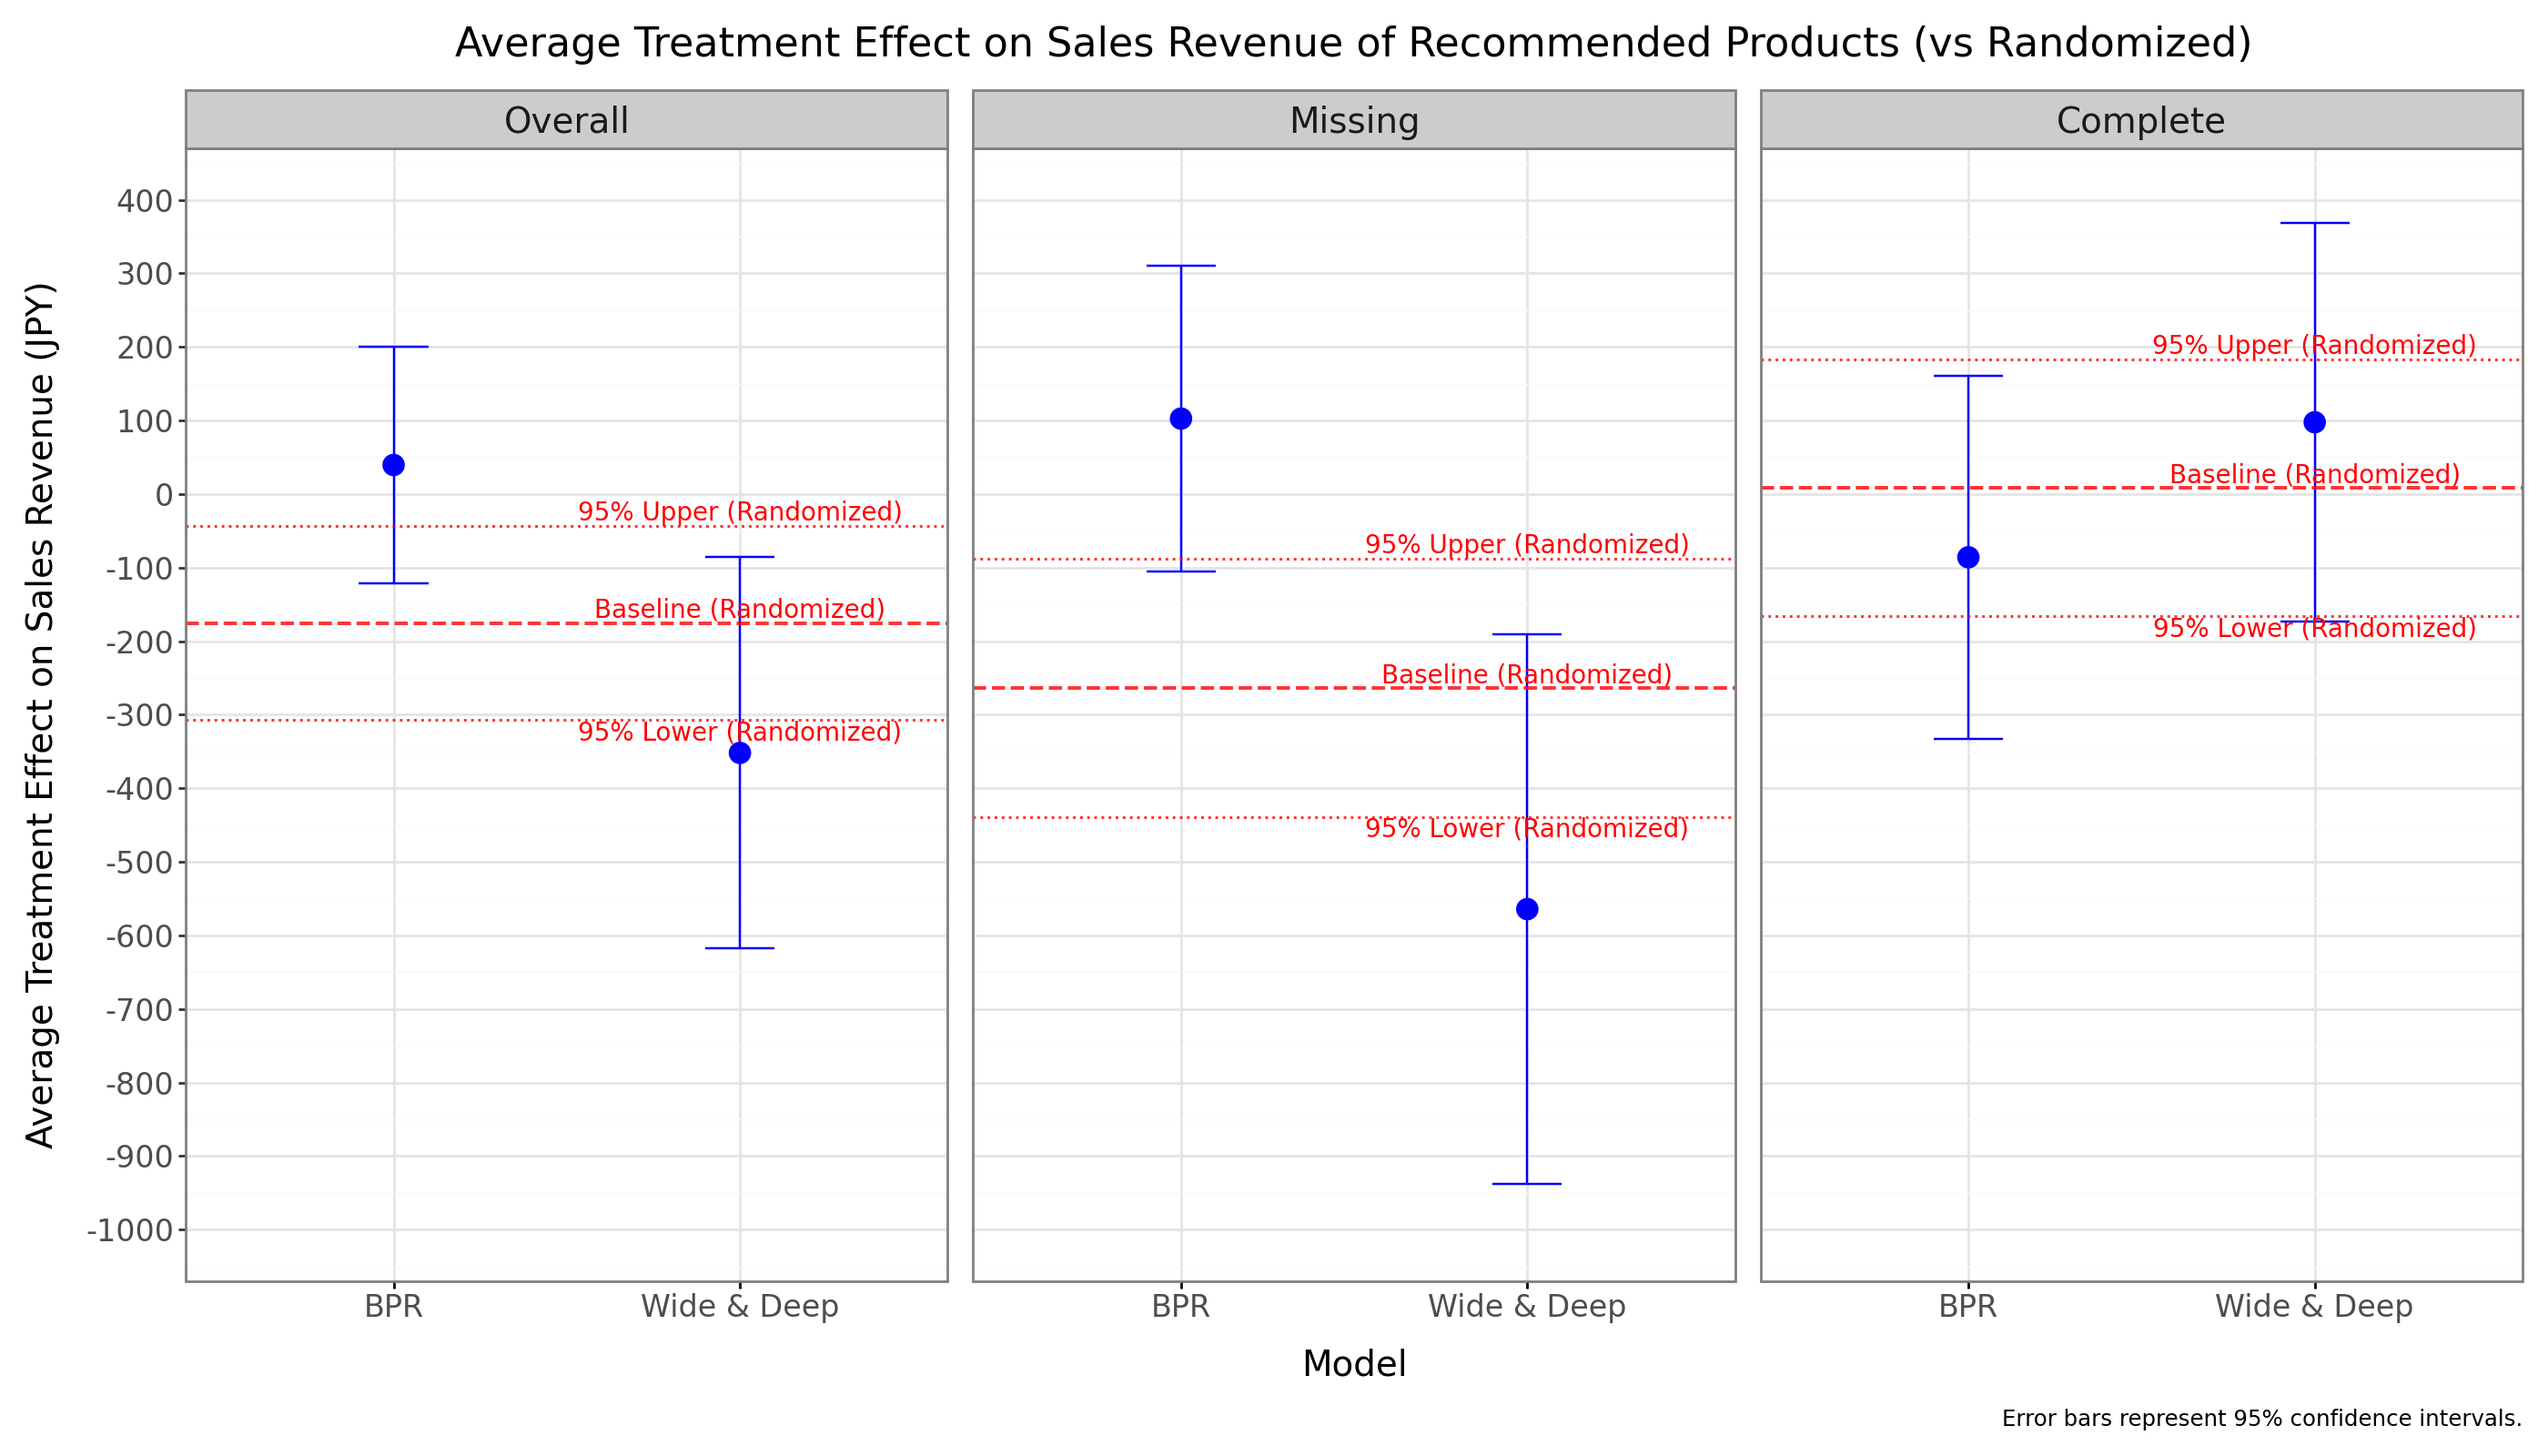

In [ ]:
# Ensure correct order for "Type" column
baseline_data['Type'] = pd.Categorical(
    baseline_data['Type'],
    categories=['Overall', 'Missing', 'Complete'],
    ordered=True
)

# Compute y-axis limits (rounded to the nearest 100)
y_min = int(comparison_data['CI_Lower'].min() // 100 * 100)  # Round down
y_max = int(comparison_data['CI_Upper'].max() // 100 * 100 + 100)  # Round up

# Compute grouped baseline data
baseline_data_grouped = baseline_data.groupby('Type').agg(
    Estimate=('Estimate', 'first'),
    CI_Lower=('CI_Lower', 'first'),
    CI_Upper=('CI_Upper', 'first')
).reset_index()

# Generate plot
p = (
    ggplot(comparison_data, aes(x='Model', y='Estimate'))
    + geom_point(size=4, color='blue', position=position_dodge(width=0.3))  # Points (blue)
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, color='blue', position=position_dodge(width=0.3))  # Error bars (blue)

    # Add Baseline lines for each "Type"
    + geom_hline(
        data=baseline_data,
        mapping=aes(yintercept='Estimate', group='Type'),
        linetype='dashed',
        color='red',
        size=0.8,
        alpha=0.8
    )
    + geom_hline(
        data=baseline_data,
        mapping=aes(yintercept='CI_Lower', group='Type'),
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )
    + geom_hline(
        data=baseline_data,
        mapping=aes(yintercept='CI_Upper', group='Type'),
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )

    # Add Baseline Labels for each "Type"
    + geom_text(
        data=baseline_data_grouped,
        mapping=aes(
            x=2,  # Shift text slightly right for clarity
            y='Estimate',
            label="'Baseline (Randomized)'"
        ),
        color='red',
        size=10,
        va='bottom'
    )
    + geom_text(
        data=baseline_data_grouped,
        mapping=aes(
            x=2,
            y='CI_Lower',
            label="'95% Lower (Randomized)'"
        ),
        color='red',
        size=10,
        va='top'
    )
    + geom_text(
        data=baseline_data_grouped,
        mapping=aes(
            x=2,
            y='CI_Upper',
            label="'95% Upper (Randomized)'"
        ),
        color='red',
        size=10,
        va='bottom'
    )

    # Facet wrap by "Type" (Overall, Missing, Complete)
    + facet_wrap('~Type', scales='fixed')

    # Adjust y-axis range and labels
    + scale_y_continuous(
        breaks=range(y_min, y_max + 100, 100),
        limits=(y_min, y_max)
    )

    # Styling
    + theme_bw()
    + theme(
        figure_size=(14, 8),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        strip_text=element_text(size=14),
        plot_title=element_text(size=16),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10)
    )

    # Labels
    + labs(
        title='Average Treatment Effect on Sales Revenue of Recommended Products (vs Randomized)',
        x='Model',
        y='Average Treatment Effect on Sales Revenue (JPY)',
        caption='Error bars represent 95% confidence intervals.'
    )
)

# Display the plot
p

#### salese quantity

In [ ]:
# Function to extract and format coupon effect data
def prepare_coupon_effect_data(df, label):
    """Extract and format coupon effect data"""
    coupon_data = df.loc['Coupon']
    models = df.columns
    coupon_effect = coupon_data.str.extract(r'([-+]?\d*\.\d+|\d+)\s*\[([-+]?\d*\.\d+|\d+),\s*([-+]?\d*\.\d+|\d+)\]')
    coupon_effect.columns = ['Estimate', 'CI_Lower', 'CI_Upper']
    coupon_effect = coupon_effect.astype(float)
    coupon_effect['Model'] = models
    coupon_effect['Type'] = label  # Data type (Overall, Missing, Complete)
    return coupon_effect

# Prepare coupon effect data for each data type (Quantity version)
coupon_effect_overall = prepare_coupon_effect_data(final_df_quantity, 'Overall')
coupon_effect_null = prepare_coupon_effect_data(final_df_quantity_null, 'Missing')
coupon_effect_non_null = prepare_coupon_effect_data(final_df_quantity_non_null, 'Complete')

# Combine all data
coupon_effect_combined = pd.concat([coupon_effect_overall, coupon_effect_null, coupon_effect_non_null], ignore_index=True)

# Filter data for visualization (only BPR and Wide & Deep)
comparison_data = coupon_effect_combined[coupon_effect_combined['Model'].isin(['BPR', 'Wide & Deep'])]

# Extract baseline (Randomized) for each data type
baseline_data = coupon_effect_combined[coupon_effect_combined['Model'] == 'Randomized']

# Set order for 'Type' column
comparison_data['Type'] = pd.Categorical(
    comparison_data['Type'],
    categories=['Overall', 'Missing', 'Complete'],
    ordered=True
)

# Compute grouped baseline data
baseline_data_grouped = baseline_data.groupby('Type').agg(
    Estimate=('Estimate', 'first'),
    CI_Lower=('CI_Lower', 'first'),
    CI_Upper=('CI_Upper', 'first')
).reset_index()

# Create comparison table
comparison_table_quantity = comparison_data[['Model', 'Type', 'Estimate', 'CI_Lower', 'CI_Upper']].copy()

# Convert baseline values into a dictionary for easy lookup
baseline_dict = baseline_data_grouped.set_index('Type').to_dict(orient='index')

# Compute Difference (vs Randomized) using type-specific baseline values
comparison_table_quantity['Difference (vs Randomized)'] = comparison_table_quantity.apply(
    lambda row: row['Estimate'] - baseline_dict[row['Type']]['Estimate'], axis=1
)

# Compute Difference CI Lower and Upper
comparison_table_quantity['Difference CI Lower'] = comparison_table_quantity.apply(
    lambda row: row['CI_Lower'] - baseline_dict[row['Type']]['CI_Upper'], axis=1
)

comparison_table_quantity['Difference CI Upper'] = comparison_table_quantity.apply(
    lambda row: row['CI_Upper'] - baseline_dict[row['Type']]['CI_Lower'], axis=1
)

# Format Difference (vs Randomized) with confidence intervals
comparison_table_quantity['Difference (vs Randomized)'] = comparison_table_quantity.apply(
    lambda row: f"{row['Difference (vs Randomized)']:.3f} [{row['Difference CI Lower']:.3f}, {row['Difference CI Upper']:.3f}]",
    axis=1
)

# Format Average Treatment Effect with confidence intervals
comparison_table_quantity['Average Treatment Effect'] = comparison_table_quantity.apply(
    lambda row: f"{row['Estimate']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]",
    axis=1
)

# Select relevant columns
comparison_table_quantity = comparison_table_quantity[['Model', 'Type', 'Average Treatment Effect', 'Difference (vs Randomized)']]

# Convert to Markdown format
comparison_table_quantity_md = comparison_table_quantity.to_markdown(index=False, numalign='left', stralign='left')

# Print the table
print(comparison_table_quantity_md)

| Model       | Type     | Average Treatment Effect   | Difference (vs Randomized)   |
|:------------|:---------|:---------------------------|:-----------------------------|
| BPR         | Overall  | -0.004 [-0.036, 0.028]     | 0.036 [-0.024, 0.096]        |
| Wide & Deep | Overall  | -0.080 [-0.143, -0.018]    | -0.040 [-0.131, 0.050]       |
| BPR         | Missing  | 0.007 [-0.033, 0.048]      | 0.071 [-0.005, 0.148]        |
| Wide & Deep | Missing  | -0.121 [-0.211, -0.032]    | -0.057 [-0.183, 0.068]       |
| BPR         | Complete | -0.026 [-0.076, 0.024]     | -0.035 [-0.130, 0.059]       |
| Wide & Deep | Complete | 0.007 [-0.043, 0.057]      | -0.002 [-0.097, 0.092]       |


<ipython-input-30-99a9009c55c1>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-31-e8fa03ee6a4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-31-e8fa03ee6a4a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-31-e8fa03ee6a4a>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


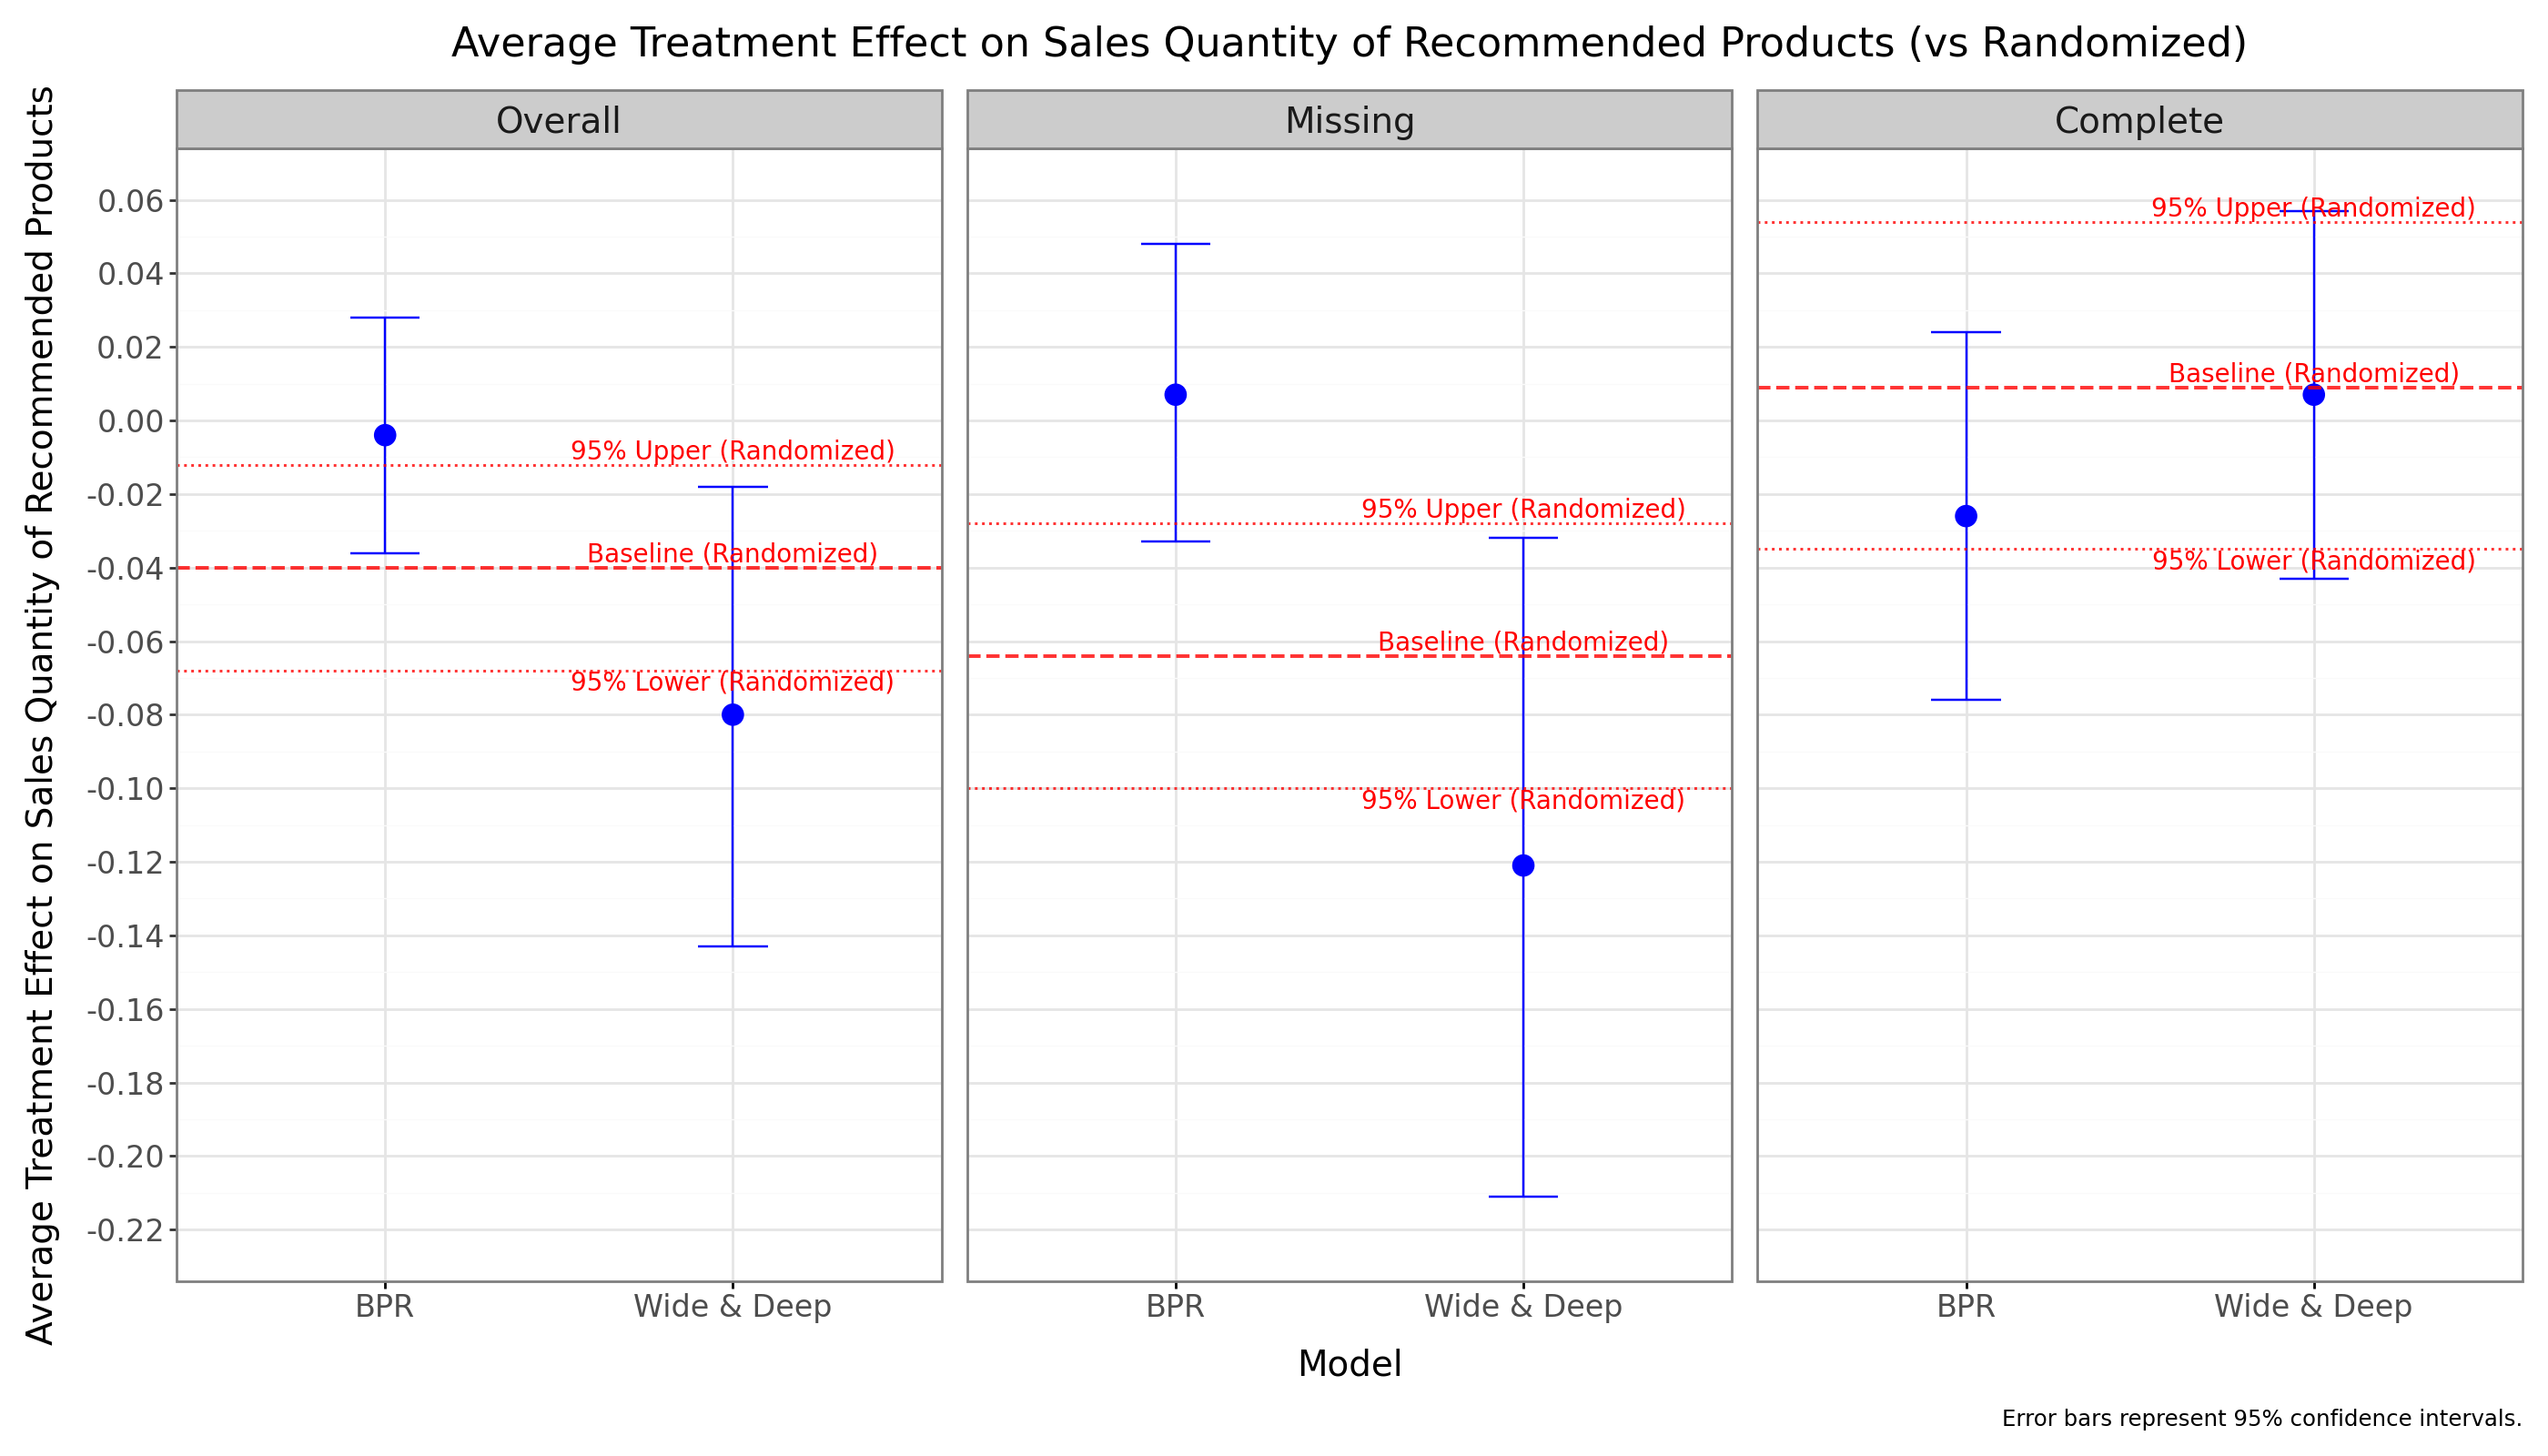

In [ ]:
# Ensure 'Model' column is a categorical variable with correct order
model_order = ["Total (Naive)", "Total", "Randomized", "BPR", "Wide & Deep"]
comparison_data['Model'] = pd.Categorical(comparison_data['Model'], categories=model_order, ordered=True)

# Set 'Type' column order
baseline_data['Type'] = pd.Categorical(
    baseline_data['Type'],
    categories=['Overall', 'Missing', 'Complete'],
    ordered=True
)

# Compute y-axis range (adjusted to a smaller range while considering negative values)
y_min = floor(comparison_data['CI_Lower'].min() * 50) / 50  # Round down to nearest 0.02
y_max = ceil(comparison_data['CI_Upper'].max() * 50) / 50  # Round up to nearest 0.02

# Compute grouped baseline data
baseline_data_grouped = baseline_data.groupby('Type').agg(
    Estimate=('Estimate', 'first'),
    CI_Lower=('CI_Lower', 'first'),
    CI_Upper=('CI_Upper', 'first')
).reset_index()

# Define y-axis ticks
y_ticks = np.arange(y_min, y_max + 0.02, 0.02)  # Generate ticks every 0.02

# Create plot (Quantity version)
p = (
    ggplot(comparison_data, aes(x='Model', y='Estimate'))
    + geom_point(size=4, color='blue', position=position_dodge(width=0.3))  # Blue points
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, color='blue', position=position_dodge(width=0.3))  # Blue error bars

    # Add Baseline (Randomized) horizontal lines for each Data Type
    + geom_hline(
        data=baseline_data,
        mapping=aes(yintercept='Estimate', group='Type'),
        linetype='dashed',
        color='red',
        size=0.8,
        alpha=0.8
    )
    + geom_hline(
        data=baseline_data,
        mapping=aes(yintercept='CI_Lower', group='Type'),
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )
    + geom_hline(
        data=baseline_data,
        mapping=aes(yintercept='CI_Upper', group='Type'),
        linetype='dotted',
        color='red',
        size=0.6,
        alpha=0.8
    )

    # Add Baseline labels
    + geom_text(
        data=baseline_data_grouped,
        mapping=aes(
            x=2,  # Adjust x position
            y='Estimate',
            label="'Baseline (Randomized)'"
        ),
        color='red',
        size=10,
        va='bottom'
    )
    + geom_text(
        data=baseline_data_grouped,
        mapping=aes(
            x=2,  # Adjust x position
            y='CI_Lower',
            label="'95% Lower (Randomized)'"
        ),
        color='red',
        size=10,
        va='top'
    )
    + geom_text(
        data=baseline_data_grouped,
        mapping=aes(
            x=2,  # Adjust x position
            y='CI_Upper',
            label="'95% Upper (Randomized)'"
        ),
        color='red',
        size=10,
        va='bottom'
    )

    # Facet grid by 'Type'
    + facet_wrap('~Type', scales='fixed')  # Split by data type

    # Set y-axis scale and limits
    + scale_y_continuous(
        breaks=y_ticks,  # Display ticks every 0.02
        limits=(y_min, y_max)  # Set axis limits
    )

    # Apply theme settings
    + theme_bw()
    + theme(
        figure_size=(14, 8),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        strip_text=element_text(size=14),
        plot_title=element_text(size=16),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10)
    )

    # Labels
    + labs(
        title='Average Treatment Effect on Sales Quantity of Recommended Products (vs Randomized)',
        x='Model',
        y='Average Treatment Effect on Sales Quantity of Recommended Products',
        caption='Error bars represent 95% confidence intervals.'
    )
)

# Display the plot
p

##  Heterogeneity in Coupon Effects

### sales revenue

In [ ]:
# Add interaction variables
df_anl_cp_non_null['coupon_female'] = df_anl_cp_non_null['is_coupon'] * df_anl_cp_non_null['Is_Female']
df_anl_cp_non_null['coupon_30s'] = df_anl_cp_non_null['is_coupon'] * df_anl_cp_non_null['Is_30s']
df_anl_cp_non_null['coupon_china'] = df_anl_cp_non_null['is_coupon'] * df_anl_cp_non_null['Is_China']

df_anl_cp_rd_non_null['coupon_female'] = df_anl_cp_rd_non_null['is_coupon'] * df_anl_cp_rd_non_null['Is_Female']
df_anl_cp_rd_non_null['coupon_30s'] = df_anl_cp_rd_non_null['is_coupon'] * df_anl_cp_rd_non_null['Is_30s']
df_anl_cp_rd_non_null['coupon_china'] = df_anl_cp_rd_non_null['is_coupon'] * df_anl_cp_rd_non_null['Is_China']

df_anl_cp_bpr_non_null['coupon_female'] = df_anl_cp_bpr_non_null['is_coupon'] * df_anl_cp_bpr_non_null['Is_Female']
df_anl_cp_bpr_non_null['coupon_30s'] = df_anl_cp_bpr_non_null['is_coupon'] * df_anl_cp_bpr_non_null['Is_30s']
df_anl_cp_bpr_non_null['coupon_china'] = df_anl_cp_bpr_non_null['is_coupon'] * df_anl_cp_bpr_non_null['Is_China']

df_anl_cp_wd_non_null['coupon_female'] = df_anl_cp_wd_non_null['is_coupon'] * df_anl_cp_wd_non_null['Is_Female']
df_anl_cp_wd_non_null['coupon_30s'] = df_anl_cp_wd_non_null['is_coupon'] * df_anl_cp_wd_non_null['Is_30s']
df_anl_cp_wd_non_null['coupon_china'] = df_anl_cp_wd_non_null['is_coupon'] * df_anl_cp_wd_non_null['Is_China']

# Total model with interaction terms
X_total_cross = df_anl_cp_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                     'coupon_female', 'coupon_30s', 'coupon_china']]
y_total = df_anl_cp_non_null['sales']
X_total_cross = sm.add_constant(X_total_cross)
model_total_cross = sm.OLS(y_total, X_total_cross)
results_sales_total_cross = model_total_cross.fit()

# Randomized model with interaction terms
X_rd_cross = df_anl_cp_rd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                     'coupon_female', 'coupon_30s', 'coupon_china']]
y_rd = df_anl_cp_rd_non_null['sales']
X_rd_cross = sm.add_constant(X_rd_cross)
model_rd_cross = sm.OLS(y_rd, X_rd_cross)
results_sales_rd_cross = model_rd_cross.fit()

# BPR model with interaction terms
X_bpr_cross = df_anl_cp_bpr_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                       'coupon_female', 'coupon_30s', 'coupon_china']]
y_bpr = df_anl_cp_bpr_non_null['sales']
X_bpr_cross = sm.add_constant(X_bpr_cross)
model_bpr_cross = sm.OLS(y_bpr, X_bpr_cross)
results_sales_bpr_cross = model_bpr_cross.fit()

# Wide & Deep model with interaction terms
X_wd_cross = df_anl_cp_wd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                     'coupon_female', 'coupon_30s', 'coupon_china']]
y_wd = df_anl_cp_wd_non_null['sales']
X_wd_cross = sm.add_constant(X_wd_cross)
model_wd_cross = sm.OLS(y_wd, X_wd_cross)
results_sales_wd_cross = model_wd_cross.fit()

# Store model results with interaction terms
all_results_cross = [
    ("Total", results_sales_total_cross),
    ("Randomized", results_sales_rd_cross),
    ("BPR", results_sales_bpr_cross),
    ("Wide & Deep", results_sales_wd_cross),
]

# Create a list to store DataFrames for cross-term model results
results_dfs_cross = []

for name, results in all_results_cross:
    if results:
        # Extract necessary information from the regression results
        coef = results.params
        conf_int = results.conf_int()
        observations = results.nobs

        # Combine coefficient and confidence interval values into a formatted string
        coef_with_ci = []
        for param_name in coef.index:
            coef_value = coef[param_name]
            ci_lower, ci_upper = conf_int.loc[param_name]
            coef_with_ci.append(f"{coef_value:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

        # Create a DataFrame
        df = pd.DataFrame({name: coef_with_ci}, index=coef.index)
        df.loc['Observations', name] = int(observations)

        results_dfs_cross.append(df)
    else:
        print(f"{name} Regression failed.")

# Combine all DataFrames
final_df_cross = pd.concat(results_dfs_cross, axis=1, sort=False).fillna('')

# Adjust the index order
new_index_cross = [
    'is_coupon', 'coupon_female', 'coupon_30s', 'coupon_china',
    'Is_Female', 'Is_30s', 'Is_China',
    'Pre-order_Count', 'Diff_Dep_Pre', 'const', 'Observations'
]
final_df_sales_cross = final_df_cross.reindex(new_index_cross)

# Convert variables to '〇' or '×' except for 'coupon_female', 'coupon_30s', 'coupon_china'
for col in final_df_sales_cross.columns:
    for index in final_df_sales_cross.index:
        if index not in ['is_coupon', 'Observations', 'const', 'coupon_female', 'coupon_30s', 'coupon_china']:
            if isinstance(final_df_sales_cross.loc[index, col], str) and final_df_sales_cross.loc[index, col] != '':
                final_df_sales_cross.loc[index, col] = '〇'
            else:
                final_df_sales_cross.loc[index, col] = '×'

# Rename index labels
index_mapping_cp_cross = {
    'is_coupon': 'Coupon',
    'coupon_female': 'Coupon × Female',
    'coupon_30s': 'Coupon × 30s',
    'coupon_china': 'Coupon × China',
    'Is_Female': 'Is Female (Sex)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
    'const': 'Constant',
    'Observations': 'N'
}
final_df_sales_cross = final_df_sales_cross.rename(index=index_mapping_cp_cross)

# Convert to Markdown format
reg_table_sales_cp_cross = final_df_sales_cross.to_markdown(numalign='left', stralign='left')
print(reg_table_sales_cp_cross)

<ipython-input-32-78a9638c5d61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-32-78a9638c5d61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-32-78a9638c5d61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-32-78a9638c5d61>

|                                | Total                        | Randomized                   | BPR                         | Wide & Deep                  |
|:-------------------------------|:-----------------------------|:-----------------------------|:----------------------------|:-----------------------------|
| Coupon                         | 111.090 [-202.080, 424.260]  | -25.775 [-422.110, 370.560]  | -39.014 [-632.396, 554.367] | 406.594 [-256.485, 1069.673] |
| Coupon × Female                | -122.188 [-436.251, 191.874] | -468.925 [-862.378, -75.473] | -33.947 [-650.830, 582.935] | 263.445 [-389.662, 916.552]  |
| Coupon × 30s                   | -125.089 [-404.713, 154.535] | 165.006 [-193.792, 523.803]  | 7.757 [-523.017, 538.530]   | -576.471 [-1159.323, 6.380]  |
| Coupon × China                 | 93.328 [-203.024, 389.681]   | 436.358 [61.323, 811.392]    | -54.260 [-628.675, 520.154] | -183.200 [-796.768, 430.367] |
| Is Female (Sex)                | 〇                

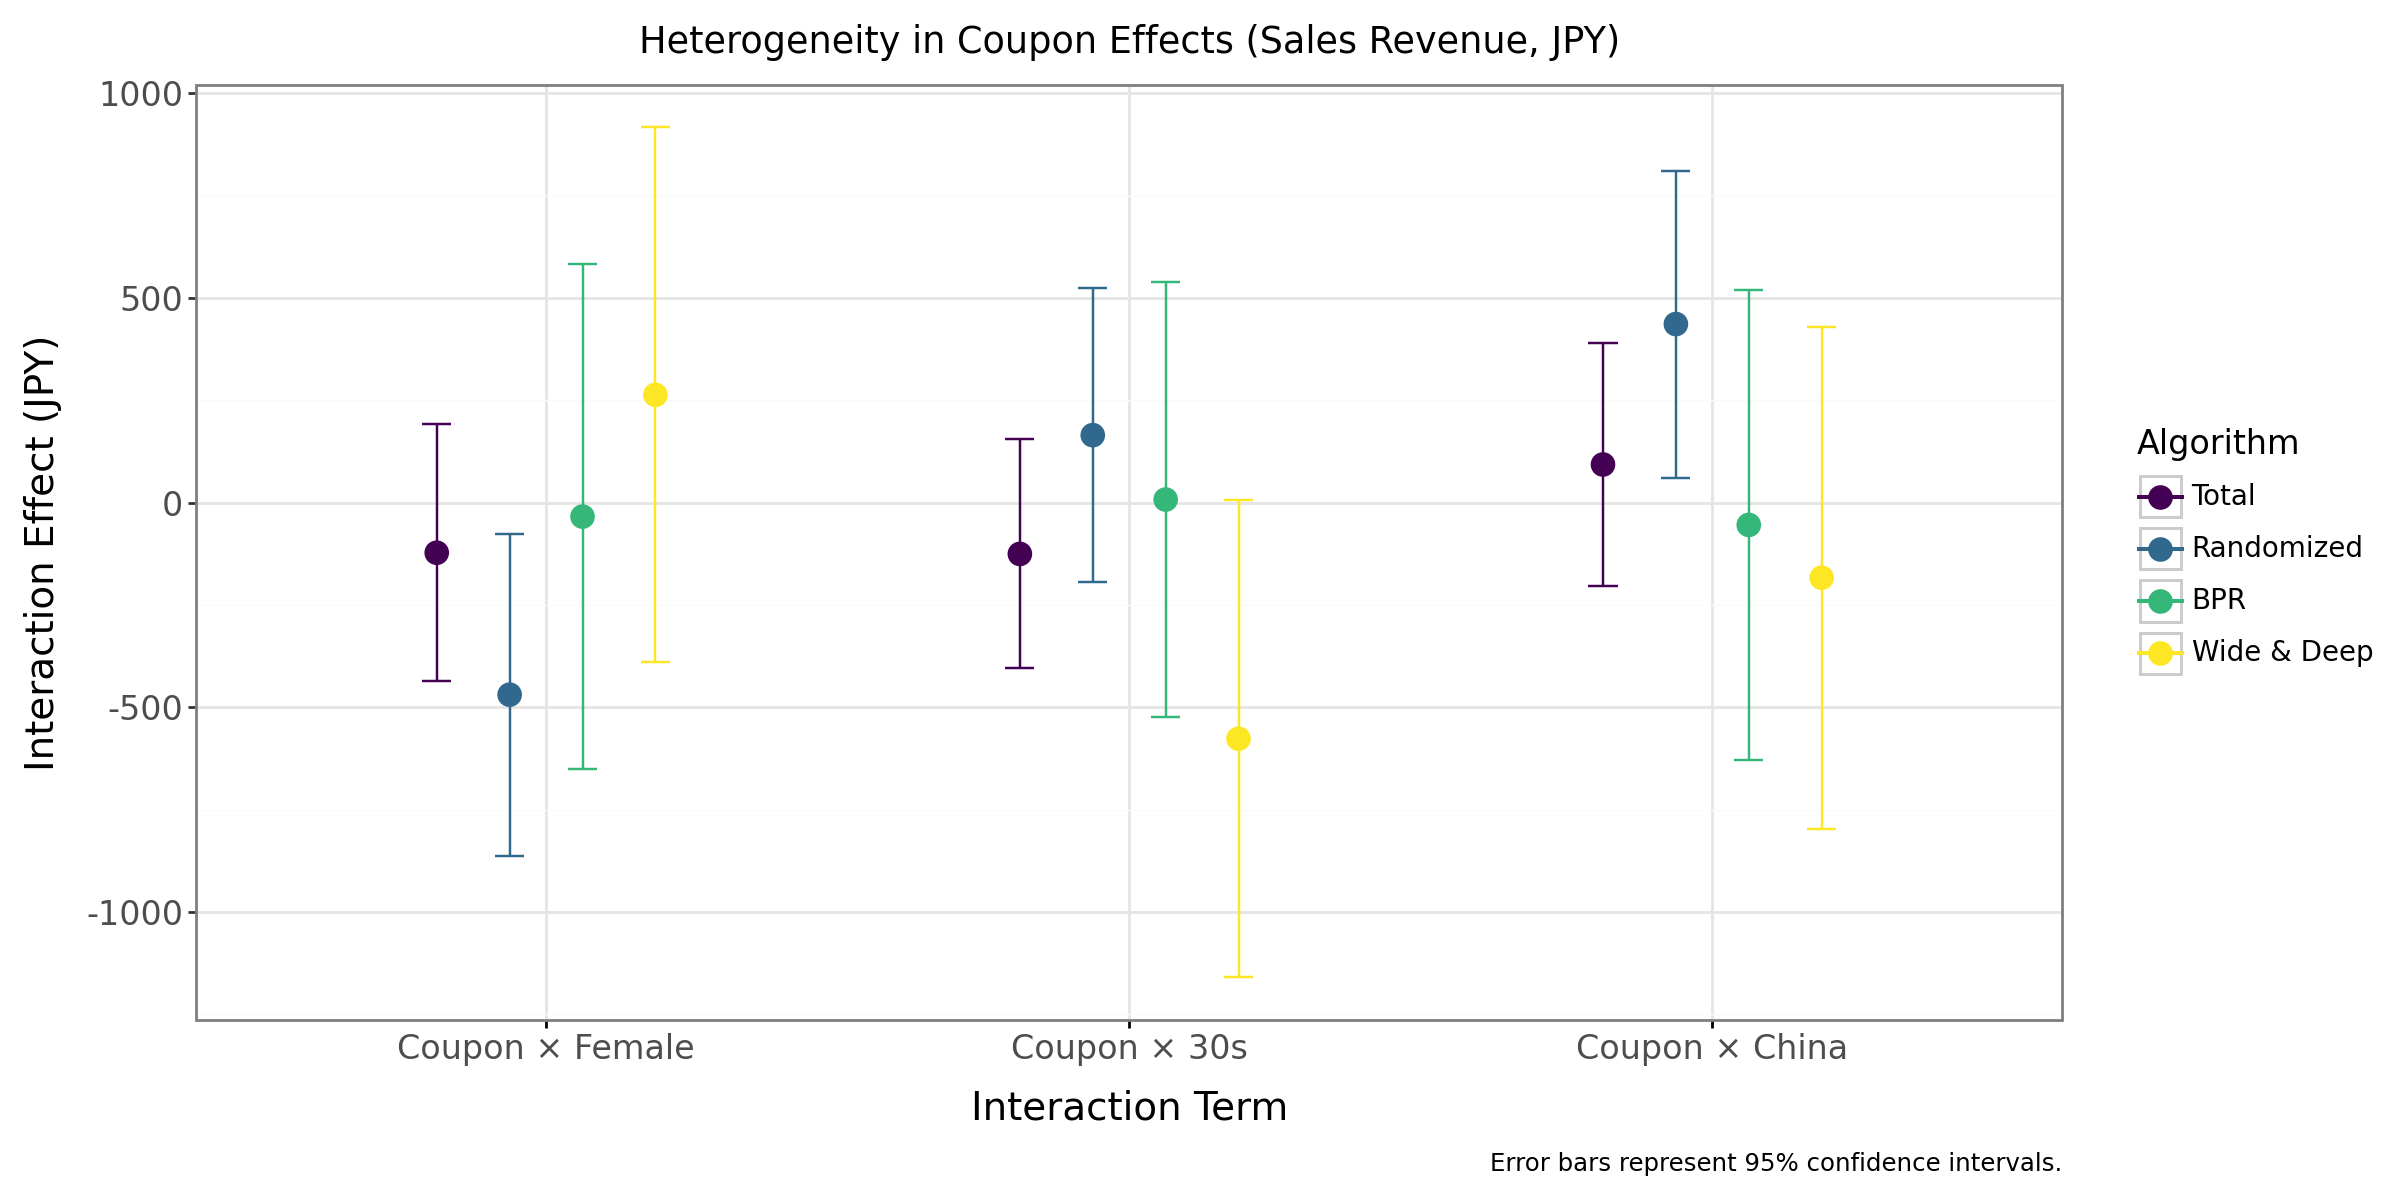

In [ ]:
# Preserve the model order from 'all_results_cross'
model_order = [name for name, _ in all_results_cross]

# Extract data for 'Coupon × Female', 'Coupon × 30s', and 'Coupon × China'
coef_terms = ["Coupon × Female", "Coupon × 30s", "Coupon × China"]
coef_data = final_df_sales_cross.loc[coef_terms].reset_index()
coef_data = coef_data.melt(id_vars='index', var_name='Model', value_name='Coefficient_CI')

# Parse confidence intervals
coef_data[['Coefficient', 'CI_Lower', 'CI_Upper']] = coef_data['Coefficient_CI'].str.extract(
    r'([-+]?\d*\.\d+|\d+)\s*\[([-+]?\d*\.\d+|\d+),\s*([-+]?\d*\.\d+|\d+)\]'
).astype(float)

# Sort by specified model order
coef_data['Model'] = pd.Categorical(coef_data['Model'], categories=model_order, ordered=True)

# Adjust the order of interaction terms ("Coupon × Female", "Coupon × 30s", "Coupon × China")
coef_data['index'] = pd.Categorical(coef_data['index'], categories=coef_terms, ordered=True)

# Rename column for clarity
coef_data.rename(columns={'Model': 'Algorithm'}, inplace=True)

# Create the plot
p = (
    ggplot(coef_data, aes(x='index', y='Coefficient', color='Algorithm'))
    + geom_point(size=4, position=position_dodge(width=0.5))
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, position=position_dodge(width=0.5))
    + theme_bw()
    + theme(
        figure_size=(12, 6),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10)
    )
    + labs(
        title='Heterogeneity in Coupon Effects (Sales Revenue, JPY)',
        x='Interaction Term',
        y='Interaction Effect (JPY)',
        caption='Error bars represent 95% confidence intervals.'
    )
)

p

### sales quantity

In [ ]:
# Define models for sales quantity including interaction terms
# Total model (Quantity)
X_total_cross_quantity = df_anl_cp_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                             'coupon_female', 'coupon_30s', 'coupon_china']]
y_total_quantity = df_anl_cp_non_null['quantity']
X_total_cross_quantity = sm.add_constant(X_total_cross_quantity)
model_total_cross_quantity = sm.OLS(y_total_quantity, X_total_cross_quantity)
results_quantity_total_cross = model_total_cross_quantity.fit()

# Randomized model (Quantity)
X_rd_cross_quantity = df_anl_cp_rd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                             'coupon_female', 'coupon_30s', 'coupon_china']]
y_rd_quantity = df_anl_cp_rd_non_null['quantity']
X_rd_cross_quantity = sm.add_constant(X_rd_cross_quantity)
model_rd_cross_quantity = sm.OLS(y_rd_quantity, X_rd_cross_quantity)
results_quantity_rd_cross = model_rd_cross_quantity.fit()

# BPR model (Quantity)
X_bpr_cross_quantity = df_anl_cp_bpr_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                               'coupon_female', 'coupon_30s', 'coupon_china']]
y_bpr_quantity = df_anl_cp_bpr_non_null['quantity']
X_bpr_cross_quantity = sm.add_constant(X_bpr_cross_quantity)
model_bpr_cross_quantity = sm.OLS(y_bpr_quantity, X_bpr_cross_quantity)
results_quantity_bpr_cross = model_bpr_cross_quantity.fit()

# Wide & Deep model (Quantity)
X_wd_cross_quantity = df_anl_cp_wd_non_null[['is_coupon', 'Is_Female', 'Is_30s', 'Is_China', 'Pre-order_Count', 'Diff_Dep_Pre',
                                             'coupon_female', 'coupon_30s', 'coupon_china']]
y_wd_quantity = df_anl_cp_wd_non_null['quantity']
X_wd_cross_quantity = sm.add_constant(X_wd_cross_quantity)
model_wd_cross_quantity = sm.OLS(y_wd_quantity, X_wd_cross_quantity)
results_quantity_wd_cross = model_wd_cross_quantity.fit()

# Store regression results for models with interaction terms
all_results_cross_quantity = [
    ("Total", results_quantity_total_cross),
    ("Randomized", results_quantity_rd_cross),
    ("BPR", results_quantity_bpr_cross),
    ("Wide & Deep", results_quantity_wd_cross),
]

# Store model results in a DataFrame list
results_dfs_cross_quantity = []

for name, results in all_results_cross_quantity:
    if results:
        # Extract necessary information from regression summary
        coef = results.params
        conf_int = results.conf_int()
        observations = results.nobs

        # Format coefficients and confidence intervals as strings
        coef_with_ci = []
        for param_name in coef.index:
            coef_value = coef[param_name]
            ci_lower, ci_upper = conf_int.loc[param_name]
            coef_with_ci.append(f"{coef_value:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

        # Create a DataFrame
        df = pd.DataFrame({name: coef_with_ci}, index=coef.index)
        df.loc['Observations', name] = int(observations)

        results_dfs_cross_quantity.append(df)
    else:
        print(f"{name} Regression failed.")

# Combine DataFrames into a single table
final_df_cross_quantity = pd.concat(results_dfs_cross_quantity, axis=1, sort=False).fillna('')

# Adjust index order
new_index_cross_quantity = [
    'is_coupon', 'coupon_female', 'coupon_30s', 'coupon_china',
    'Is_Female', 'Is_30s', 'Is_China',
    'Pre-order_Count', 'Diff_Dep_Pre', 'const', 'Observations'
]
final_df_quantity_cross = final_df_cross_quantity.reindex(new_index_cross_quantity)

# Convert values to '〇' or '×' except for specific interaction terms
for col in final_df_quantity_cross.columns:
    for index in final_df_quantity_cross.index:
        if index not in ['is_coupon', 'Observations', 'const', 'coupon_female', 'coupon_30s', 'coupon_china']:
            # Convert to '〇' or '×'
            if isinstance(final_df_quantity_cross.loc[index, col], str) and final_df_quantity_cross.loc[index, col] != '':
                final_df_quantity_cross.loc[index, col] = '〇'
            else:
                final_df_quantity_cross.loc[index, col] = '×'

# Rename index labels
index_mapping_cp_cross_quantity = {
    'is_coupon': 'Coupon',
    'coupon_female': 'Coupon × Female',
    'coupon_30s': 'Coupon × 30s',
    'coupon_china': 'Coupon × China',
    'Is_Female': 'Is Female (Sex)',
    'Is_30s': 'Is 30s (Age)',
    'Is_China': 'Is China (Region)',
    'Pre-order_Count': 'Pre-order (Counts)',
    'Diff_Dep_Pre': 'Diff Departure Pre-order (Day)',
    'const': 'Constant',
    'Observations': 'N'
}
final_df_quantity_cross = final_df_quantity_cross.rename(index=index_mapping_cp_cross_quantity)

# Convert DataFrame to Markdown format
reg_table_quantity_cp_cross = final_df_quantity_cross.to_markdown(numalign='left', stralign='left')

# Print the regression table
print(reg_table_quantity_cp_cross)

|                                | Total                  | Randomized             | BPR                    | Wide & Deep            |
|:-------------------------------|:-----------------------|:-----------------------|:-----------------------|:-----------------------|
| Coupon                         | 0.021 [-0.045, 0.086]  | 0.011 [-0.089, 0.112]  | -0.023 [-0.144, 0.097] | 0.073 [-0.049, 0.195]  |
| Coupon × Female                | -0.022 [-0.088, 0.043] | -0.094 [-0.194, 0.006] | -0.005 [-0.130, 0.121] | 0.057 [-0.063, 0.177]  |
| Coupon × 30s                   | -0.018 [-0.076, 0.040] | 0.026 [-0.065, 0.117]  | 0.020 [-0.088, 0.128]  | -0.105 [-0.212, 0.002] |
| Coupon × China                 | 0.004 [-0.058, 0.065]  | 0.079 [-0.016, 0.174]  | -0.022 [-0.139, 0.095] | -0.061 [-0.174, 0.051] |
| Is Female (Sex)                | 〇                     | 〇                     | 〇                     | 〇                     |
| Is 30s (Age)                   | 〇                     | 

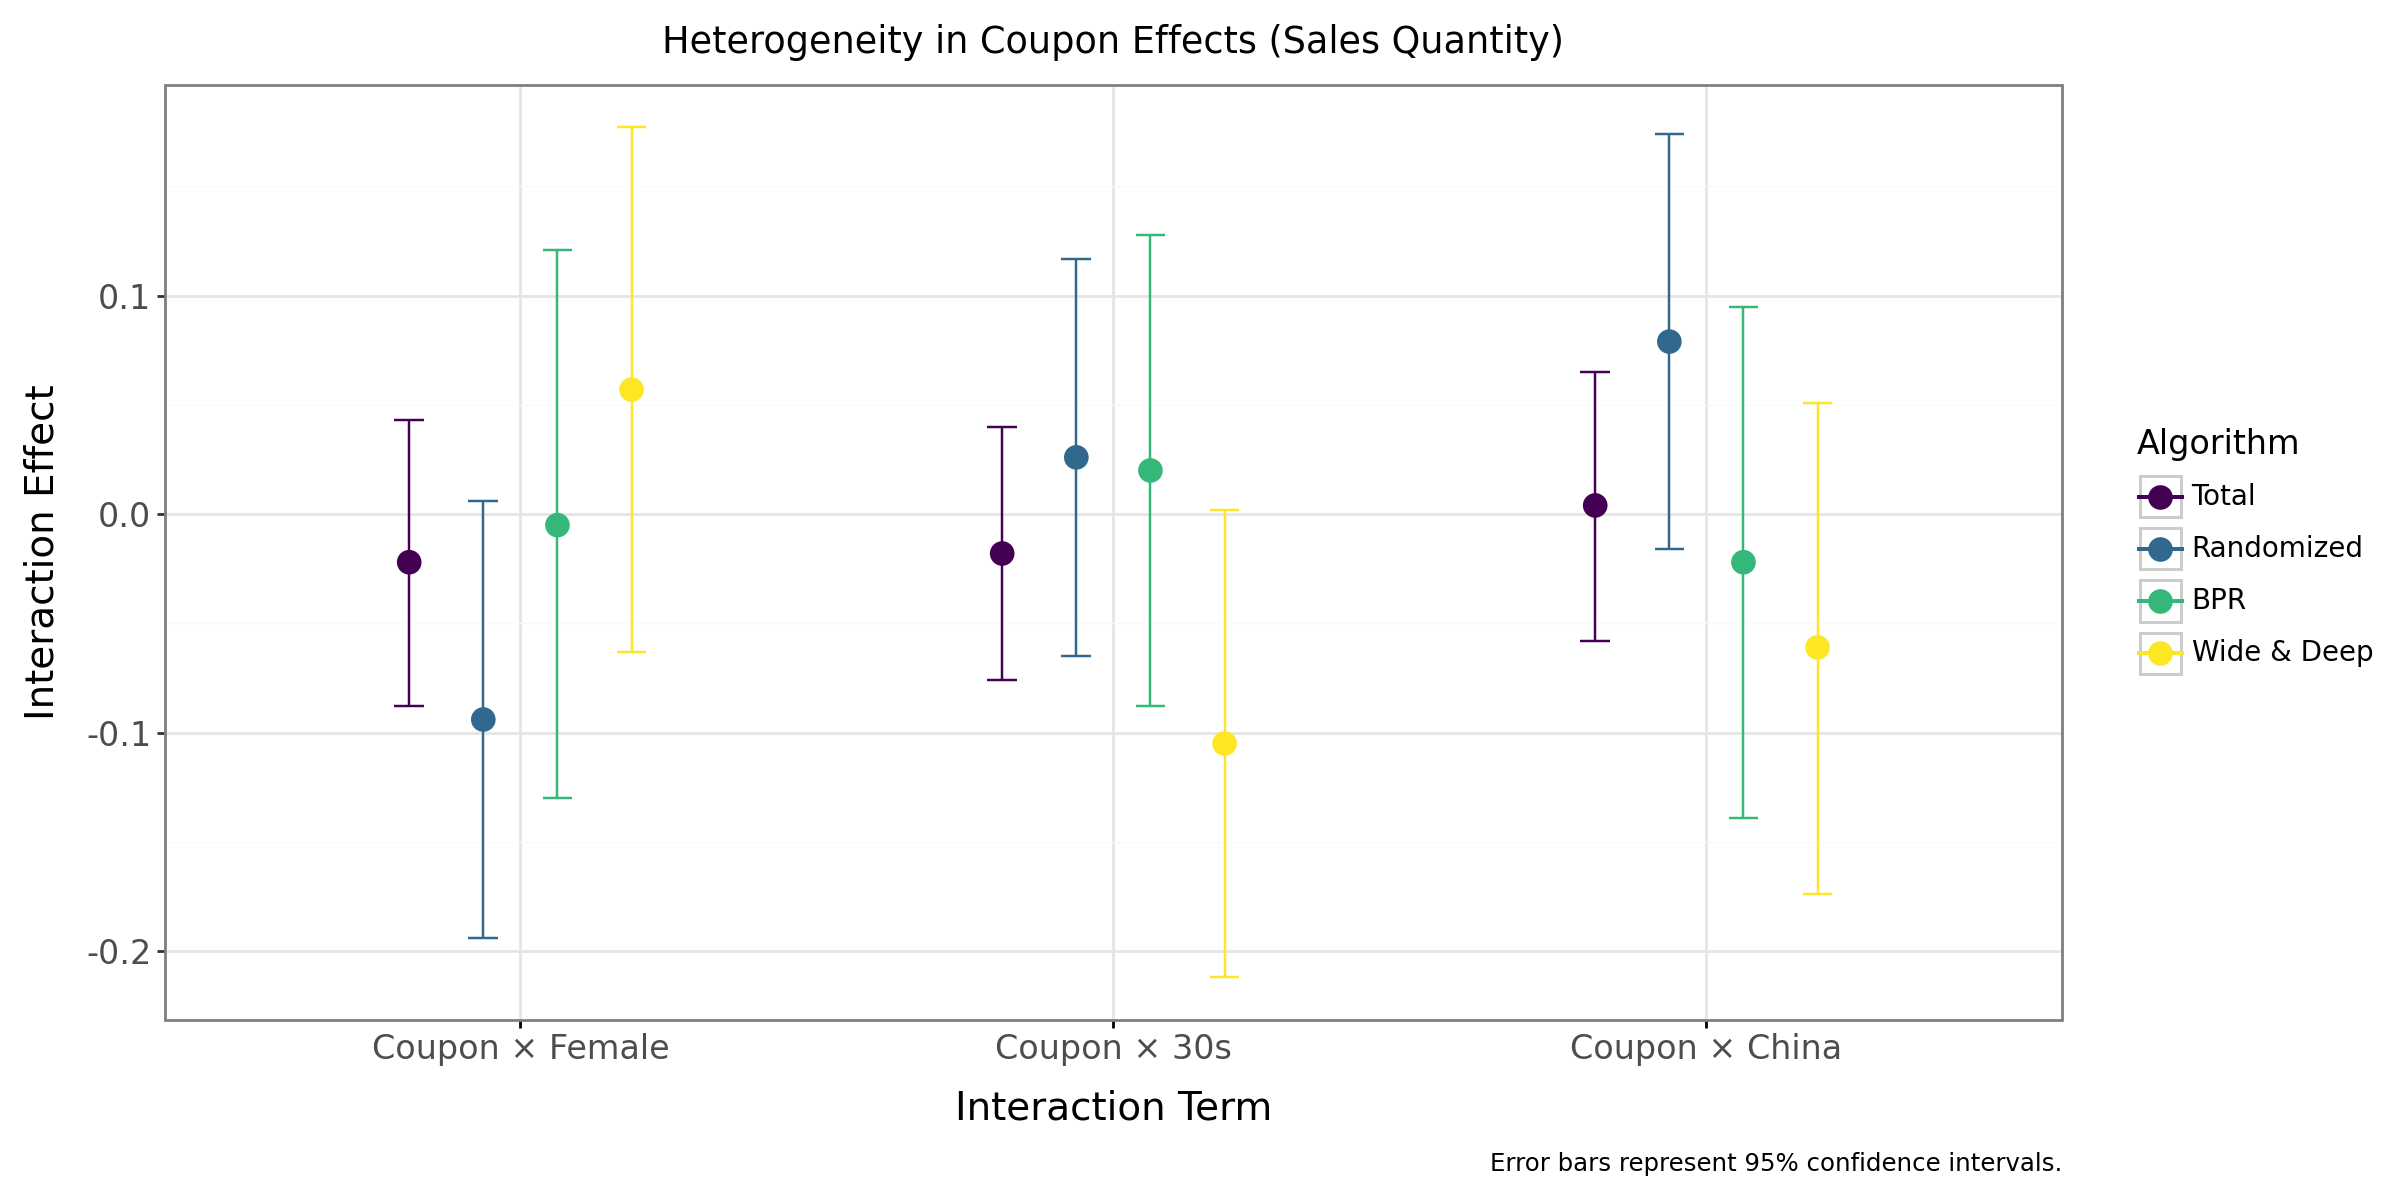

In [ ]:
# Maintain the model order for 'all_results_cross_quantity'
model_order_quantity = [name for name, _ in all_results_cross_quantity]

# Extract data for 'Coupon × Female', 'Coupon × 30s', 'Coupon × China'
coef_terms_quantity = ["Coupon × Female", "Coupon × 30s", "Coupon × China"]
coef_data_quantity = final_df_quantity_cross.loc[coef_terms_quantity].reset_index()
coef_data_quantity = coef_data_quantity.melt(id_vars='index', var_name='Model', value_name='Coefficient_CI')

# Parse confidence intervals
coef_data_quantity[['Coefficient', 'CI_Lower', 'CI_Upper']] = coef_data_quantity['Coefficient_CI'].str.extract(
    r'([-+]?\d*\.\d+|\d+)\s*\[([-+]?\d*\.\d+|\d+),\s*([-+]?\d*\.\d+|\d+)\]'
).astype(float)

# Reorder models based on predefined order
coef_data_quantity['Model'] = pd.Categorical(coef_data_quantity['Model'], categories=model_order_quantity, ordered=True)

# Reorder interaction terms (from left: "Coupon × Female", "Coupon × 30s", "Coupon × China")
coef_data_quantity['index'] = pd.Categorical(coef_data_quantity['index'], categories=coef_terms_quantity, ordered=True)

# Rename columns for clarity
coef_data_quantity.rename(columns={'Model': 'Algorithm'}, inplace=True)

# Create plot
p = (
    ggplot(coef_data_quantity, aes(x='index', y='Coefficient', color='Algorithm'))
    + geom_point(size=4, position=position_dodge(width=0.5))
    + geom_errorbar(aes(ymin='CI_Lower', ymax='CI_Upper'), width=0.2, position=position_dodge(width=0.5))
    + theme_bw()
    + theme(
        figure_size=(12, 6),
        axis_text=element_text(size=12),
        axis_title=element_text(size=14),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10)
    )
    + labs(
        title='Heterogeneity in Coupon Effects (Sales Quantity)',
        x='Interaction Term',
        y='Interaction Effect',
        caption='Error bars represent 95% confidence intervals.'
    )
)

# Display the plot
p